# **Project 4 - Q Learning**

For this project, you will be tasked with both implementing and explaining key components of the Q-learning algorithm.

All the code deliverables has to be provided within this notebook.

# 1 - Packages
Let's first import all the packages that you will need during this assignment.

* 
[numpy](https://numpy.org/) - is the main package for scientific computing with Python
*
[matplotlib](https://matplotlib.org/) - is a plotting library
*
[gym](https://gym.openai.com/docs/) - Gym is a toolkit for developing and comparing reinforcement learning algorithms.
*
[gym.spaces](http://gym.openai.com/docs/) - Every environment comes with an action_space and an observation_space. These attributes are of type Space, and they describe the format of valid actions and observations.
*
[time](https://docs.python.org/3/library/time.html?highlight=time#module-time) - will be used to track how much time each computation takes
*
[copy](https://docs.python.org/3/library/copy.html) - A copy is sometimes needed so one can change one copy without changing the other.
*
[Threading](https://docs.python.org/3/library/threading.html) - This module constructs higher-level threading interfaces on top of the lower level thread module.
*
[Collections](https://docs.python.org/2/library/collections.html) - This module implements specialized container datatypes providing alternatives to Python’s general purpose built-in containers, dict, list, set, and tuple.


In [54]:
#######################################################################
# Authors:
# Nathan Margaglio (nathanmargaglio@gmail.com)                                                          
# Mihir Hemant Chauhan (mihirhem@buffalo.edu)                       
# Qian Cheng (qcheng2@buffalo.edu)                            
#######################################################################
import numpy as np
import matplotlib.pyplot as plt
import gym
import gym.spaces
import time
import copy
import threading
import time
import collections

`## Basic Environment
Here we define our grid-world environment. No need to make any changes.

In [55]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': ['human'] }
    
    def __init__(self, normalize=False, size=4):
        self.observation_space = gym.spaces.Box(0, size, (size,))
        self.action_space = gym.spaces.Discrete(4)
        self.max_timesteps = size*2 + 1
        self.normalize = normalize
        self.size = size

        # Generate State Transition Table
        self.transition_matrix = []
        for x in range(size + 1):
            state_x = []
            for y in range(size + 1):
                state_y = []
                for a in range(4):
                    one_hot = np.zeros(4)
                    one_hot[a] = 1
                    state_y.append(one_hot)
                state_x.append(state_y)
            self.transition_matrix.append(state_x)
        
    def transition_func(self, x, y, action, return_probs=False):
        probs = self.transition_matrix[x][y][action]
        if return_probs:
            return probs
        else:
            return np.random.choice(len(probs), p=probs)

    def _get_distance(self, x, y):
        return abs(x[0] - y[0]) + abs(x[1] - y[1])
        
    def reset(self):
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [self.size, self.size]
        self.state = np.zeros((self.size + 1, self.size + 1))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.prev_distance = self._get_distance(self.agent_pos, self.goal_pos)
        return np.array(self.agent_pos)/1.
    
    def step(self, action):
        action_taken = self.transition_func(self.agent_pos[0], self.agent_pos[1], action)
        self.state = np.random.choice(self.observation_space.shape[0])
        if action_taken == 0:
            self.agent_pos[0] += 1
        if action_taken == 1:
            self.agent_pos[0] -= 1
        if action_taken == 2:
            self.agent_pos[1] += 1
        if action_taken == 3:
            self.agent_pos[1] -= 1
          
        self.agent_pos = np.clip(self.agent_pos, 0, self.size)
        self.state = np.zeros((self.size + 1, self.size + 1))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        
        current_distance = self._get_distance(self.agent_pos, self.goal_pos)
        if current_distance < self.prev_distance:
            reward = 1
        elif current_distance > self.prev_distance:
            reward = -1
        else:
            reward = -1
        self.prev_distance = current_distance
        
        self.timestep += 1
        if self.timestep >= self.max_timesteps or current_distance == 0:
            done = True
        else:
            done = False
        info = {}
        
        obs = self.agent_pos
        if self.normalize:
            obs = obs/self.size
        return obs, reward, done, info
        
    def render(self, mode='human'):
        plt.imshow(self.state)

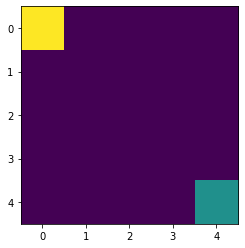

In [56]:
env = GridEnvironment()
obs = env.reset()
env.render()

## Random Agent
This runs the environment with a random agent that just takes random actions. Neither does he learn, nor remember anything. Try to run it!

In [57]:
class RandomAgent:
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def policy(self, observation):
        return np.random.choice(self.action_space.n)
        
    def step(self, observation, verbose=False):
        return self.policy(observation)

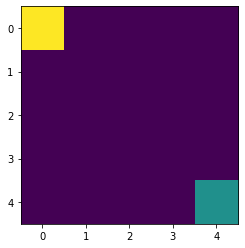

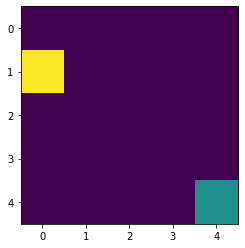

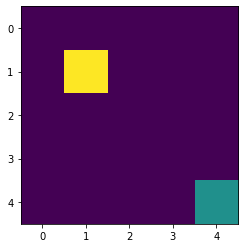

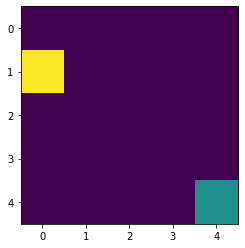

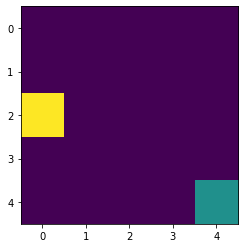

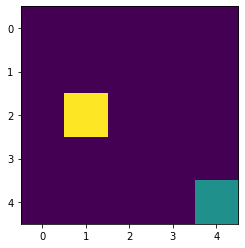

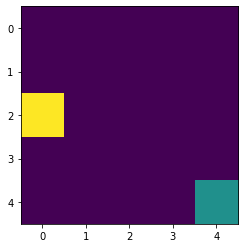

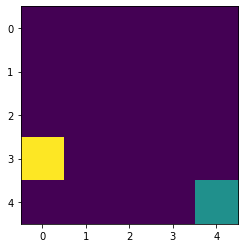

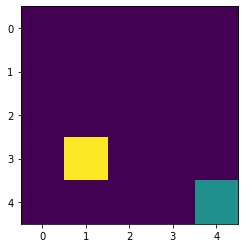

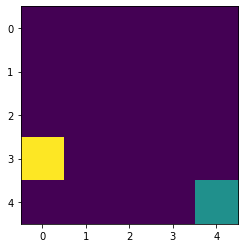

In [58]:
env = GridEnvironment(normalize=True)
agent = RandomAgent(env)

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()

while not done:
    action = agent.step(obs, verbose=True)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()

## Heuristic Agent
This runs the environment with a heuristic agent. No need to make any changes. Try to run it!

In [59]:
class HeuristicAgent:
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def policy(self, observation):
        # 0 - down
        # 1 - up
        # 2 - right
        # 3 - left
        if (observation[0] < 1.):
            return 0
        if (observation[1] < 1.):
            return 2
        return 0
        
    def step(self, observation, verbose=False):
        if verbose:
            print(observation)
        return self.policy(observation)

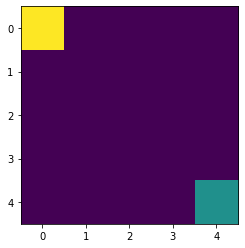

[0. 0.]


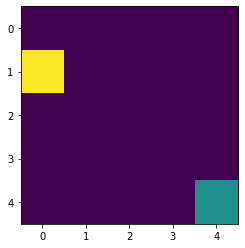

[0.25 0.  ]


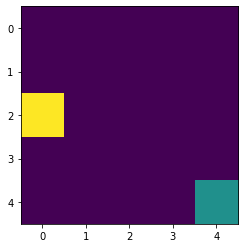

[0.5 0. ]


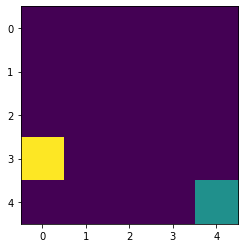

[0.75 0.  ]


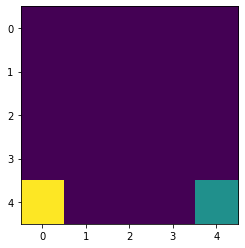

[1. 0.]


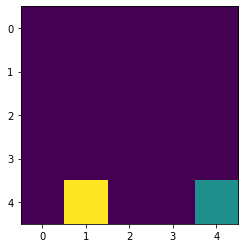

[1.   0.25]


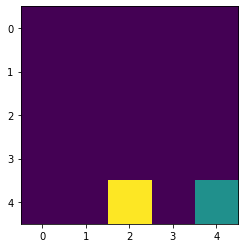

[1.  0.5]


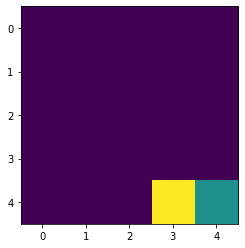

[1.   0.75]


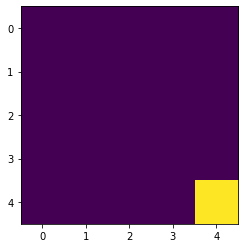

In [60]:
env = GridEnvironment(normalize=True)
agent = HeuristicAgent(env)

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()

while not done:
    action = agent.step(obs, verbose=True)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()

## Tabular Q-Learning
This is where you need to define policy and update Q tables.
For policy.

*  
[np.argmax](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html) - Returns the indices of the maximum values along an axis.

### Epsilon

Our agent will randomly select its action at first by a certain percentage, called ‘exploration rate’ or ‘epsilon’. This is because at first, it is better for the agent to try all kinds of things before it starts to see the patterns. When it is not deciding the action randomly, the agent will predict the reward value based on the current state and pick the action that will give the highest reward. We want our agent to decrease the number of random action, as it goes, so we indroduce an exponential-decay epsilon, that eventually will allow our agent to explore the evironment. \\



###  <font color='red'>Task 1: Implement policy function.</font>  <br>
**Instructions:**
- Our agent will randomly select its action at first by a certain percentage, called ‘exploration rate’ or ‘epsilon’. This is because at first, it is better for the agent to try all kinds of things before it starts to see the patterns. Select a random uniform number. If it's less than epsilon, return the random choice action space.
- When it is not deciding the action randomly, the agent will predict the reward value based on the current state and pick the action that will give the highest reward. 
\begin{align} \notag
\pi\left(s_{t}\right)=\underset{a \in A}{\operatorname{argmax}} Q_{\theta}\left(s_{t}, a\right)
\end{align} 
- Return the policy
- Please note, that the name for all the variables should start with <mark>self</mark>, thus </br> 

epsilon $\rightarrow$ self.epsilon </br> 
action_space $\rightarrow$ self.action_space

###  <font color='red'>Task 2: Update Q-table</font>  <br>
**Instructions:**
            \begin{align} \notag
            Q^{n e w}\left(s_{t}, a_{t}\right) \leftarrow(1-\alpha) \cdot \underbrace{Q\left(s_{t}, a_{t}\right)}_{\text {old value }}+\underbrace{\alpha}_{\text {learning rate }} \cdot \overbrace{(\underbrace{r_{t}}_{\text {reward }} + \underbrace{\gamma}_{\text {discount factor }} \underbrace{\max _{a} Q\left(s_{t+1}, a\right)}_{a})}^{\text {learned value }}
            \end{align} 

In [61]:
class QLearningAgent:
    def __init__(self, env, epsilon=1.0, lr=0.2, gamma=0.8):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        q_table_dim = env.observation_space.shape[0] + 1
        self.q_table = np.zeros((q_table_dim, q_table_dim, env.action_space.n))
        self.epsilon = epsilon
        self.lr = lr
        self.gamma = gamma

    def policy(self, observation):
      # Code for policy (Task 1) (30 points)
        mx_nxt_reward = 0
        action = ""
        print("Action:", self.action_space)
        print("Q_table:",self.q_table)
        if np.random.uniform(0, 1) <= self.epsilon:
            action = np.random.choice(self.action_space.n)
        else:
            for a in range(self.action_space.n):
                print("Observation:", int(observation[0]), int(observation[1]))
                current_position = self.env.state
                print("State:",current_position)
                print("Q_table:",self.q_table)
                nxt_reward = self.q_table[int(observation[0])][int(observation[1])][a]
                if nxt_reward >= mx_nxt_reward:
                    action = a
                    mx_nxt_reward = nxt_reward
        return action

    def step(self, observation):
        return self.policy(observation)

    def update(self, state, action, reward, next_state):
        state = state.astype(int)
        next_state = next_state.astype(int)
        # Code for updating Q Table (Task 2) (20 points)
        print("State", state)
        old_qvalue = self.q_table[state[0]][state[1]][action]
        max_qvalue = np.amax(self.q_table[next_state[0]][next_state[1]])
        new_qvalue = (1 - self.lr) * old_qvalue + self.lr * (reward + self.gamma * max_qvalue)
        self.q_table[state[0]][state[1]][action] = new_qvalue

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

### Training
### Environment
First, we initialize our environment.  The environment, loosely structured like [OpenAI's Gym Environments](https://gym.openai.com/), has three main methods: `reset`, `step` and `render`. You'll only need `reset` and `step` here.

- When we call **reset**, we initialize the environment with a fresh episode. This allows us to effectively run through episodes (only needing to call reset at the beginning of an episode), but, more importantly, `reset()` returns the environment's initial state.

- The **step** method accepts an action as a parameter (which, for this example, is an integer in [0, 3]), processes the action, and returns the new state, the reward for performing the action, and a boolean indicating if the run is over.

### Agent
When we initialize the agent, we must pass both a `environment` into QLearningAgent function.
###  <font color='red'>Task 3: Implement the training algorithm</font>  <br>
**Instructions:**
- After initialization, pass the initial state to obs. Then check if it's already done. If done = False, you'll keep going. While it's not done, you'll need to update `state`, `action`,`reward` and `next_state`. You can get action by `step` the current state on agent. Use `copy` to record the current state. `step` the current action on environment to return the new state, the reward for performing the action, a boolean indicating if the run is over and some other information. Add the new reward on the total rewards. Use `copy` to save the new state returned by `step`. Update the `state`, `action`, `reward`, `next_state` of agent.

Round 0
Action: Discrete(4)
Q_table: [[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
State [0 0]
State [1 0]


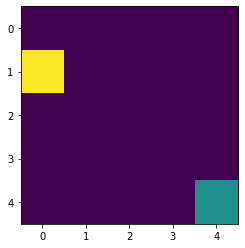

Action: Discrete(4)
Q_table: [[[0.2 0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]]

 [[0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]]

 [[0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]]

 [[0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]]

 [[0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]]]
State [1 0]
State [1 1]


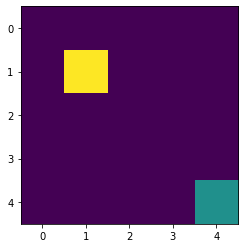

Action: Discrete(4)
Q_table: [[[0.2 0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]]

 [[0.  0.  0.2 0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]]

 [[0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]]

 [[0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]]

 [[0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]]]
State [1 1]
State [0 1]


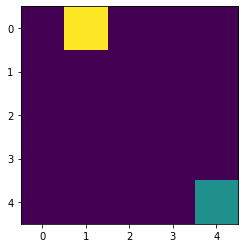

Action: Discrete(4)
Q_table: [[[ 0.2  0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]]

 [[ 0.   0.   0.2  0. ]
  [ 0.  -0.2  0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]]

 [[ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]]

 [[ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]]

 [[ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]]]
State [0 1]
State [1 1]


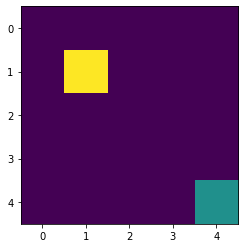

Action: Discrete(4)
Q_table: [[[ 0.2  0.   0.   0. ]
  [ 0.2  0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]]

 [[ 0.   0.   0.2  0. ]
  [ 0.  -0.2  0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]]

 [[ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]]

 [[ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]]

 [[ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]]]
State [1 1]
State [1 2]


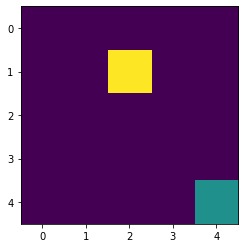

Action: Discrete(4)
Q_table: [[[ 0.2  0.   0.   0. ]
  [ 0.2  0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]]

 [[ 0.   0.   0.2  0. ]
  [ 0.  -0.2  0.2  0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]]

 [[ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]]

 [[ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]]

 [[ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]
  [ 0.   0.   0.   0. ]]]
State [1 2]
State [1 1]


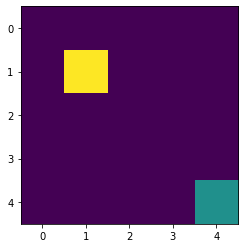

Action: Discrete(4)
Q_table: [[[ 0.2    0.     0.     0.   ]
  [ 0.2    0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]]

 [[ 0.     0.     0.2    0.   ]
  [ 0.    -0.2    0.2    0.   ]
  [ 0.     0.     0.    -0.168]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]]

 [[ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]]

 [[ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]]

 [[ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]]]
State [1 1]
State [0 1]


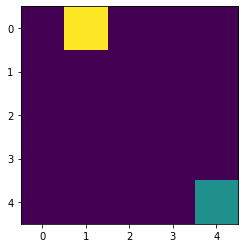

Action: Discrete(4)
Q_table: [[[ 0.2    0.     0.     0.   ]
  [ 0.2    0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]]

 [[ 0.     0.     0.2    0.   ]
  [ 0.    -0.328  0.2    0.   ]
  [ 0.     0.     0.    -0.168]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]]

 [[ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]]

 [[ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]]

 [[ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]]]
State [0 1]
State [1 1]


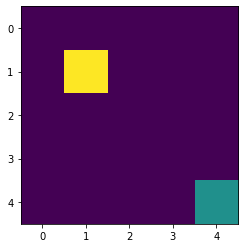

Action: Discrete(4)
Q_table: [[[ 0.2    0.     0.     0.   ]
  [ 0.392  0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]]

 [[ 0.     0.     0.2    0.   ]
  [ 0.    -0.328  0.2    0.   ]
  [ 0.     0.     0.    -0.168]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]]

 [[ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]]

 [[ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]]

 [[ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]]]
State [1 1]
State [2 1]


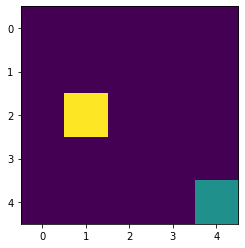

Round 1
Action: Discrete(4)
Q_table: [[[ 0.2    0.     0.     0.   ]
  [ 0.392  0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]]

 [[ 0.     0.     0.2    0.   ]
  [ 0.2   -0.328  0.2    0.   ]
  [ 0.     0.     0.    -0.168]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]]

 [[ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]]

 [[ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]]

 [[ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]]]
State [0 0]
State [0 1]


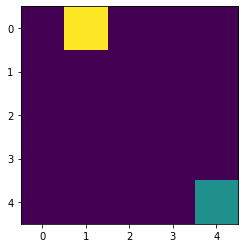

Action: Discrete(4)
Q_table: [[[ 0.2      0.       0.26272  0.     ]
  [ 0.392    0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.2      0.     ]
  [ 0.2     -0.328    0.2      0.     ]
  [ 0.       0.       0.      -0.168  ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [

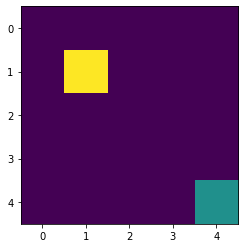

Action: Discrete(4)
Q_table: [[[ 0.2      0.       0.26272  0.     ]
  [ 0.5456   0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.2      0.     ]
  [ 0.2     -0.328    0.2      0.     ]
  [ 0.       0.       0.      -0.168  ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [

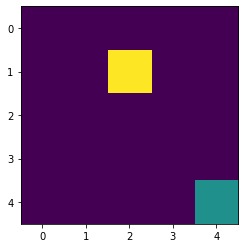

Action: Discrete(4)
Q_table: [[[ 0.2      0.       0.26272  0.     ]
  [ 0.5456   0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.2      0.     ]
  [ 0.2     -0.328    0.36     0.     ]
  [ 0.       0.       0.      -0.168  ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [

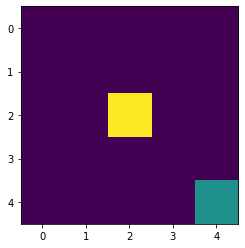

Action: Discrete(4)
Q_table: [[[ 0.2      0.       0.26272  0.     ]
  [ 0.5456   0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.2      0.     ]
  [ 0.2     -0.328    0.36     0.     ]
  [ 0.2      0.       0.      -0.168  ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [

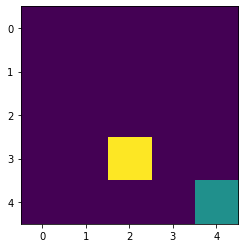

Action: Discrete(4)
Q_table: [[[ 0.2      0.       0.26272  0.     ]
  [ 0.5456   0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.2      0.     ]
  [ 0.2     -0.328    0.36     0.     ]
  [ 0.2      0.       0.      -0.168  ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.2      0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [

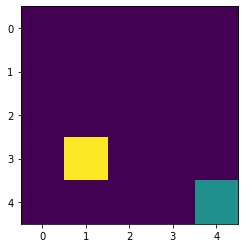

Action: Discrete(4)
Q_table: [[[ 0.2      0.       0.26272  0.     ]
  [ 0.5456   0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.2      0.     ]
  [ 0.2     -0.328    0.36     0.     ]
  [ 0.2      0.       0.      -0.168  ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.2      0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.      -0.2    ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [

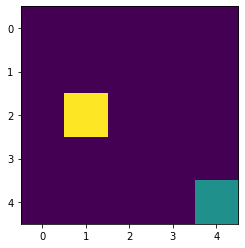

Action: Discrete(4)
Q_table: [[[ 0.2      0.       0.26272  0.     ]
  [ 0.5456   0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.2      0.     ]
  [ 0.2     -0.328    0.36     0.     ]
  [ 0.2      0.       0.      -0.168  ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.2      0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.      -0.2      0.       0.     ]
  [ 0.       0.       0.      -0.2    ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [

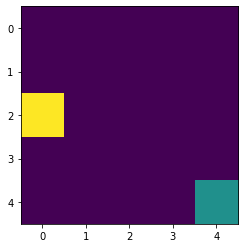

Action: Discrete(4)
Q_table: [[[ 0.2      0.       0.26272  0.     ]
  [ 0.5456   0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.2      0.     ]
  [ 0.2     -0.328    0.36     0.     ]
  [ 0.2      0.       0.      -0.168  ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.      -0.2    ]
  [ 0.2      0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.      -0.2      0.       0.     ]
  [ 0.       0.       0.      -0.2    ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [

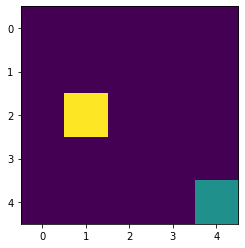

Round 2
Action: Discrete(4)
Q_table: [[[ 0.2      0.       0.26272  0.     ]
  [ 0.5456   0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.2      0.     ]
  [ 0.2     -0.328    0.36     0.     ]
  [ 0.2      0.       0.      -0.168  ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.2      0.     ]
  [ 0.       0.       0.      -0.2    ]
  [ 0.2      0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.      -0.2      0.       0.     ]
  [ 0.       0.       0.      -0.2    ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.  

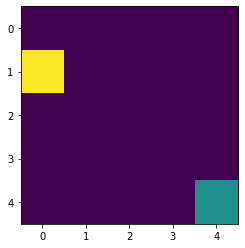

Action: Discrete(4)
Q_table: [[[ 0.392    0.       0.26272  0.     ]
  [ 0.5456   0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.2      0.     ]
  [ 0.2     -0.328    0.36     0.     ]
  [ 0.2      0.       0.      -0.168  ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.2      0.     ]
  [ 0.       0.       0.      -0.2    ]
  [ 0.2      0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.      -0.2      0.       0.     ]
  [ 0.       0.       0.      -0.2    ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [

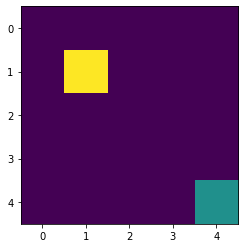

Action: Discrete(4)
Q_table: [[[ 0.392    0.       0.26272  0.     ]
  [ 0.5456   0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.4176   0.     ]
  [ 0.2     -0.328    0.36     0.     ]
  [ 0.2      0.       0.      -0.168  ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.2      0.     ]
  [ 0.       0.       0.      -0.2    ]
  [ 0.2      0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.      -0.2      0.       0.     ]
  [ 0.       0.       0.      -0.2    ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [

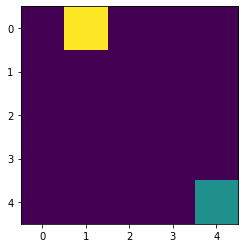

Action: Discrete(4)
Q_table: [[[ 0.392     0.        0.26272   0.      ]
  [ 0.5456    0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.4176    0.      ]
  [ 0.2      -0.375104  0.36      0.      ]
  [ 0.2       0.        0.       -0.168   ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.2       0.      ]
  [ 0.        0.        0.       -0.2     ]
  [ 0.2       0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.        0.      ]
  [ 0.       -0.2       0.        0.      ]
  [ 0.        0.        0.       -0.2     ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.   

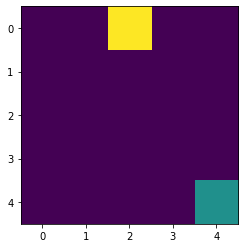

Action: Discrete(4)
Q_table: [[[ 0.392     0.        0.26272   0.      ]
  [ 0.5456    0.        0.2       0.      ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.4176    0.      ]
  [ 0.2      -0.375104  0.36      0.      ]
  [ 0.2       0.        0.       -0.168   ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.2       0.      ]
  [ 0.        0.        0.       -0.2     ]
  [ 0.2       0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.        0.      ]
  [ 0.       -0.2       0.        0.      ]
  [ 0.        0.        0.       -0.2     ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.   

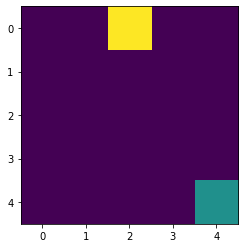

Action: Discrete(4)
Q_table: [[[ 0.392     0.        0.26272   0.      ]
  [ 0.5456    0.        0.2       0.      ]
  [ 0.       -0.2       0.        0.      ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.4176    0.      ]
  [ 0.2      -0.375104  0.36      0.      ]
  [ 0.2       0.        0.       -0.168   ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.2       0.      ]
  [ 0.        0.        0.       -0.2     ]
  [ 0.2       0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.        0.      ]
  [ 0.       -0.2       0.        0.      ]
  [ 0.        0.        0.       -0.2     ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.   

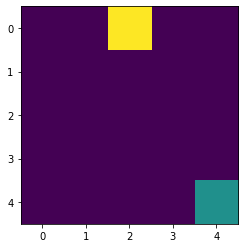

Action: Discrete(4)
Q_table: [[[ 0.392     0.        0.26272   0.      ]
  [ 0.5456    0.        0.2       0.      ]
  [ 0.       -0.36      0.        0.      ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.4176    0.      ]
  [ 0.2      -0.375104  0.36      0.      ]
  [ 0.2       0.        0.       -0.168   ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.2       0.      ]
  [ 0.        0.        0.       -0.2     ]
  [ 0.2       0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.        0.      ]
  [ 0.       -0.2       0.        0.      ]
  [ 0.        0.        0.       -0.2     ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.   

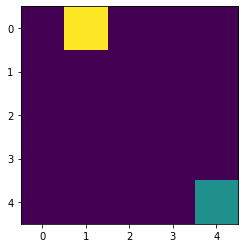

Action: Discrete(4)
Q_table: [[[ 0.392     0.        0.26272   0.      ]
  [ 0.5456    0.        0.2       0.      ]
  [ 0.       -0.36      0.       -0.112704]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.4176    0.      ]
  [ 0.2      -0.375104  0.36      0.      ]
  [ 0.2       0.        0.       -0.168   ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.2       0.      ]
  [ 0.        0.        0.       -0.2     ]
  [ 0.2       0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.        0.      ]
  [ 0.       -0.2       0.        0.      ]
  [ 0.        0.        0.       -0.2     ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.   

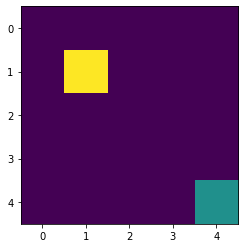

Action: Discrete(4)
Q_table: [[[ 0.392     0.        0.26272   0.      ]
  [ 0.69408   0.        0.2       0.      ]
  [ 0.       -0.36      0.       -0.112704]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.4176    0.      ]
  [ 0.2      -0.375104  0.36      0.      ]
  [ 0.2       0.        0.       -0.168   ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.2       0.      ]
  [ 0.        0.        0.       -0.2     ]
  [ 0.2       0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.        0.      ]
  [ 0.       -0.2       0.        0.      ]
  [ 0.        0.        0.       -0.2     ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.   

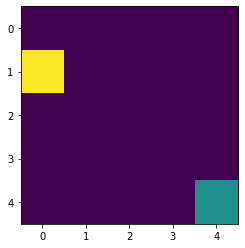

Round 3
Action: Discrete(4)
Q_table: [[[ 0.392     0.        0.26272   0.      ]
  [ 0.69408   0.        0.2       0.      ]
  [ 0.       -0.36      0.       -0.112704]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.4176    0.      ]
  [ 0.2      -0.375104  0.36     -0.133184]
  [ 0.2       0.        0.       -0.168   ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.2       0.      ]
  [ 0.        0.        0.       -0.2     ]
  [ 0.2       0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.        0.      ]
  [ 0.       -0.2       0.        0.      ]
  [ 0.        0.        0.       -0.2     ]
  [ 0.        0.        0.        0.      ]
  [ 0.        0.        0.        0.      ]]

 [[ 0.        0.        0.        0.      ]
  [ 0.        0.        0.     

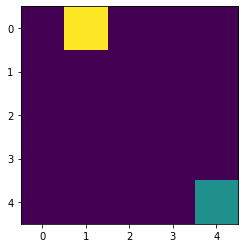

Action: Discrete(4)
Q_table: [[[ 0.392      0.         0.5212288  0.       ]
  [ 0.69408    0.         0.2        0.       ]
  [ 0.        -0.36       0.        -0.112704 ]
  [ 0.         0.         0.         0.       ]
  [ 0.         0.         0.         0.       ]]

 [[ 0.         0.         0.4176     0.       ]
  [ 0.2       -0.375104   0.36      -0.133184 ]
  [ 0.2        0.         0.        -0.168    ]
  [ 0.         0.         0.         0.       ]
  [ 0.         0.         0.         0.       ]]

 [[ 0.         0.         0.2        0.       ]
  [ 0.         0.         0.        -0.2      ]
  [ 0.2        0.         0.         0.       ]
  [ 0.         0.         0.         0.       ]
  [ 0.         0.         0.         0.       ]]

 [[ 0.         0.         0.         0.       ]
  [ 0.        -0.2        0.         0.       ]
  [ 0.         0.         0.        -0.2      ]
  [ 0.         0.         0.         0.       ]
  [ 0.         0.         0.         0.       ]]

 [[

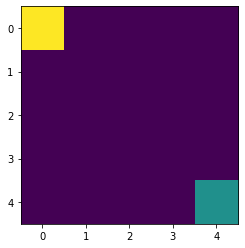

Action: Discrete(4)
Q_table: [[[ 0.392       0.          0.5212288   0.        ]
  [ 0.69408     0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4176      0.        ]
  [ 0.2        -0.375104    0.36       -0.133184  ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.         -0.2       ]
  [ 0.2         0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.2         0.          0.        ]
  [ 0.          0.          0.         -0.2       ]
  [ 0.          0.          0

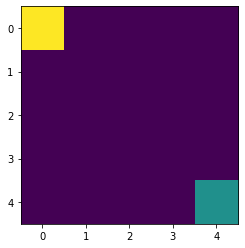

Action: Discrete(4)
Q_table: [[[ 0.392      -0.11660339  0.5212288   0.        ]
  [ 0.69408     0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4176      0.        ]
  [ 0.2        -0.375104    0.36       -0.133184  ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.         -0.2       ]
  [ 0.2         0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.2         0.          0.        ]
  [ 0.          0.          0.         -0.2       ]
  [ 0.          0.          0

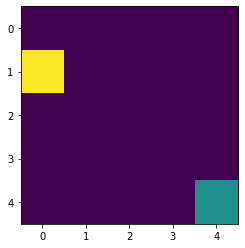

Action: Discrete(4)
Q_table: [[[ 0.580416   -0.11660339  0.5212288   0.        ]
  [ 0.69408     0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4176      0.        ]
  [ 0.2        -0.375104    0.36       -0.133184  ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.         -0.2       ]
  [ 0.2         0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.2         0.          0.        ]
  [ 0.          0.          0.         -0.2       ]
  [ 0.          0.          0

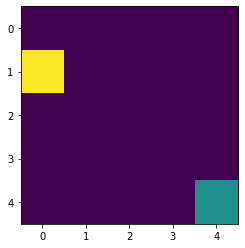

Action: Discrete(4)
Q_table: [[[ 0.580416   -0.11660339  0.5212288   0.        ]
  [ 0.69408     0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4176     -0.133184  ]
  [ 0.2        -0.375104    0.36       -0.133184  ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.         -0.2       ]
  [ 0.2         0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.2         0.          0.        ]
  [ 0.          0.          0.         -0.2       ]
  [ 0.          0.          0

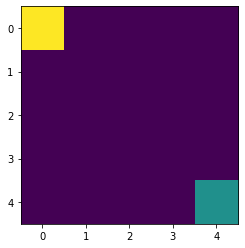

Action: Discrete(4)
Q_table: [[[ 0.580416   -0.11660339  0.5212288   0.        ]
  [ 0.69408     0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10713344  0.4176     -0.133184  ]
  [ 0.2        -0.375104    0.36       -0.133184  ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.         -0.2       ]
  [ 0.2         0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.2         0.          0.        ]
  [ 0.          0.          0.         -0.2       ]
  [ 0.          0.          0

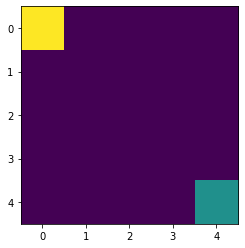

Action: Discrete(4)
Q_table: [[[ 0.580416   -0.20041615  0.5212288   0.        ]
  [ 0.69408     0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10713344  0.4176     -0.133184  ]
  [ 0.2        -0.375104    0.36       -0.133184  ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.         -0.2       ]
  [ 0.2         0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.2         0.          0.        ]
  [ 0.          0.          0.         -0.2       ]
  [ 0.          0.          0

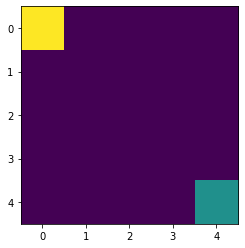

Action: Discrete(4)
Q_table: [[[ 0.580416   -0.26746636  0.5212288   0.        ]
  [ 0.69408     0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10713344  0.4176     -0.133184  ]
  [ 0.2        -0.375104    0.36       -0.133184  ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.         -0.2       ]
  [ 0.2         0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.2         0.          0.        ]
  [ 0.          0.          0.         -0.2       ]
  [ 0.          0.          0

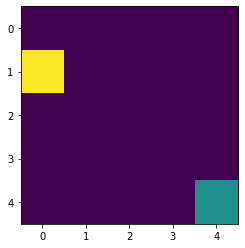

Round 4
Action: Discrete(4)
Q_table: [[[ 0.7311488  -0.26746636  0.5212288   0.        ]
  [ 0.69408     0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10713344  0.4176     -0.133184  ]
  [ 0.2        -0.375104    0.36       -0.133184  ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.         -0.2       ]
  [ 0.2         0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.2         0.          0.        ]
  [ 0.          0.          0.         -0.2       ]
  [ 0.          0.   

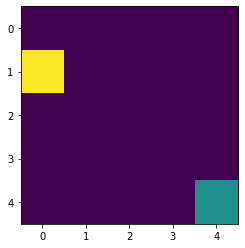

Action: Discrete(4)
Q_table: [[[ 0.85173504 -0.26746636  0.5212288   0.        ]
  [ 0.69408     0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10713344  0.4176     -0.133184  ]
  [ 0.2        -0.375104    0.36       -0.133184  ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.         -0.2       ]
  [ 0.2         0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.2         0.          0.        ]
  [ 0.          0.          0.         -0.2       ]
  [ 0.          0.          0

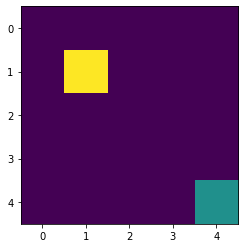

Action: Discrete(4)
Q_table: [[[ 0.85173504 -0.26746636  0.5212288   0.        ]
  [ 0.69408     0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10713344  0.59168    -0.133184  ]
  [ 0.2        -0.375104    0.36       -0.133184  ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.         -0.2       ]
  [ 0.2         0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.2         0.          0.        ]
  [ 0.          0.          0.         -0.2       ]
  [ 0.          0.          0

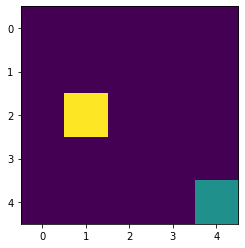

Action: Discrete(4)
Q_table: [[[ 0.85173504 -0.26746636  0.5212288   0.        ]
  [ 0.69408     0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10713344  0.59168    -0.133184  ]
  [ 0.36       -0.375104    0.36       -0.133184  ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.         -0.2       ]
  [ 0.2         0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.2         0.          0.        ]
  [ 0.          0.          0.         -0.2       ]
  [ 0.          0.          0

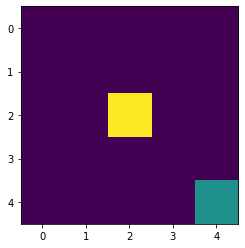

Action: Discrete(4)
Q_table: [[[ 0.85173504 -0.26746636  0.5212288   0.        ]
  [ 0.69408     0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10713344  0.59168    -0.133184  ]
  [ 0.36       -0.375104    0.36       -0.133184  ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.232      -0.2       ]
  [ 0.2         0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.2         0.          0.        ]
  [ 0.          0.          0.         -0.2       ]
  [ 0.          0.          0

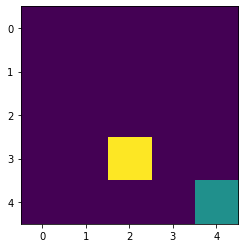

Action: Discrete(4)
Q_table: [[[ 0.85173504 -0.26746636  0.5212288   0.        ]
  [ 0.69408     0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10713344  0.59168    -0.133184  ]
  [ 0.36       -0.375104    0.36       -0.133184  ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.232      -0.2       ]
  [ 0.36        0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.2         0.          0.        ]
  [ 0.          0.          0.         -0.2       ]
  [ 0.          0.          0

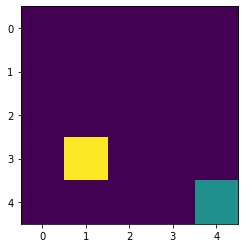

Action: Discrete(4)
Q_table: [[[ 0.85173504 -0.26746636  0.5212288   0.        ]
  [ 0.69408     0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10713344  0.59168    -0.133184  ]
  [ 0.36       -0.375104    0.36       -0.133184  ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.232      -0.2       ]
  [ 0.36        0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.2         0.          0.        ]
  [ 0.          0.          0.         -0.36      ]
  [ 0.          0.          0

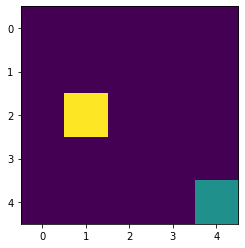

Action: Discrete(4)
Q_table: [[[ 0.85173504 -0.26746636  0.5212288   0.        ]
  [ 0.69408     0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10713344  0.59168    -0.133184  ]
  [ 0.36       -0.375104    0.36       -0.133184  ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.232      -0.2       ]
  [ 0.36        0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.         -0.36      ]
  [ 0.          0.          0

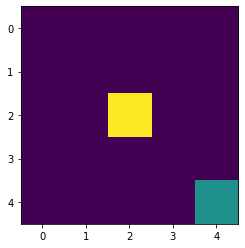

Action: Discrete(4)
Q_table: [[[ 0.85173504 -0.26746636  0.5212288   0.        ]
  [ 0.69408     0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10713344  0.59168    -0.133184  ]
  [ 0.36       -0.375104    0.36       -0.133184  ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.36        0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.         -0.36      ]
  [ 0.          0.          0

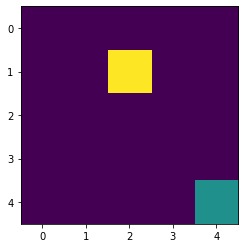

Round 5
Action: Discrete(4)
Q_table: [[[ 0.85173504 -0.26746636  0.5212288   0.        ]
  [ 0.69408     0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10713344  0.59168    -0.133184  ]
  [ 0.36       -0.375104    0.36       -0.133184  ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.36       -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.         -0.36      ]
  [ 0.          0.   

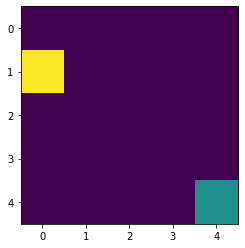

Action: Discrete(4)
Q_table: [[[ 0.97605683 -0.26746636  0.5212288   0.        ]
  [ 0.69408     0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10713344  0.59168    -0.133184  ]
  [ 0.36       -0.375104    0.36       -0.133184  ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.36       -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.         -0.36      ]
  [ 0.          0.          0

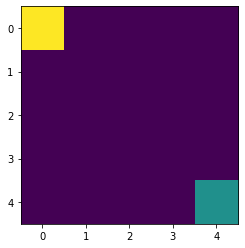

Action: Discrete(4)
Q_table: [[[ 0.97605683 -0.26746636  0.5212288   0.        ]
  [ 0.69408     0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.12953766  0.59168    -0.133184  ]
  [ 0.36       -0.375104    0.36       -0.133184  ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.36       -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.         -0.36      ]
  [ 0.          0.          0

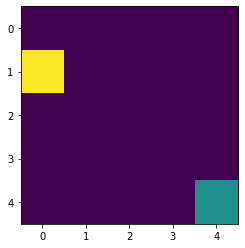

Action: Discrete(4)
Q_table: [[[ 1.07551427 -0.26746636  0.5212288   0.        ]
  [ 0.69408     0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.12953766  0.59168    -0.133184  ]
  [ 0.36       -0.375104    0.36       -0.133184  ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.36       -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.         -0.36      ]
  [ 0.          0.          0

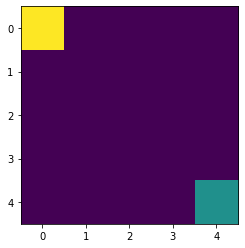

Action: Discrete(4)
Q_table: [[[ 1.07551427 -0.26746636  0.5212288   0.        ]
  [ 0.69408     0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.13154784  0.59168    -0.133184  ]
  [ 0.36       -0.375104    0.36       -0.133184  ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.36       -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.         -0.36      ]
  [ 0.          0.          0

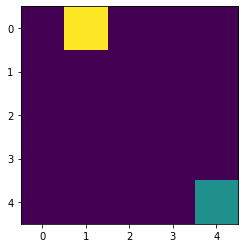

Action: Discrete(4)
Q_table: [[[ 1.07551427 -0.26746636  0.72803584  0.        ]
  [ 0.69408     0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.13154784  0.59168    -0.133184  ]
  [ 0.36       -0.375104    0.36       -0.133184  ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.36       -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.         -0.36      ]
  [ 0.          0.          0

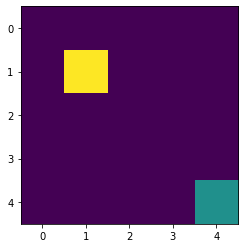

Action: Discrete(4)
Q_table: [[[ 1.07551427 -0.26746636  0.72803584  0.        ]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.13154784  0.59168    -0.133184  ]
  [ 0.36       -0.375104    0.36       -0.133184  ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.36       -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.         -0.36      ]
  [ 0.          0.          0

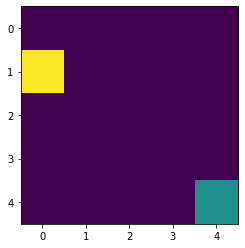

Action: Discrete(4)
Q_table: [[[ 1.07551427 -0.26746636  0.72803584  0.        ]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.13154784  0.59168    -0.133184  ]
  [ 0.36       -0.375104    0.36       -0.2118784 ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.36       -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.         -0.36      ]
  [ 0.          0.          0

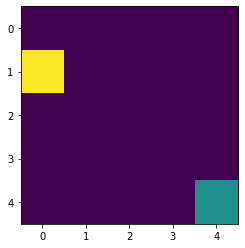

Action: Discrete(4)
Q_table: [[[ 1.07551427 -0.26746636  0.72803584  0.        ]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.13154784  0.59168    -0.2118784 ]
  [ 0.36       -0.375104    0.36       -0.2118784 ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.36       -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.         -0.36      ]
  [ 0.          0.          0

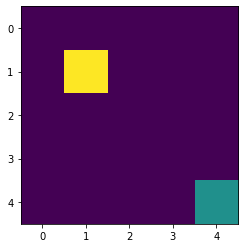

Round 6
Action: Discrete(4)
Q_table: [[[ 1.07551427 -0.26746636  0.72803584  0.        ]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.13154784  0.730944   -0.2118784 ]
  [ 0.36       -0.375104    0.36       -0.2118784 ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.36       -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.         -0.36      ]
  [ 0.          0.   

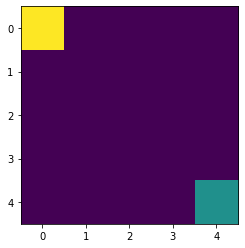

Action: Discrete(4)
Q_table: [[[ 1.07551427 -0.26746636  0.72803584 -0.02791772]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.13154784  0.730944   -0.2118784 ]
  [ 0.36       -0.375104    0.36       -0.2118784 ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.36       -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.         -0.36      ]
  [ 0.          0.          0

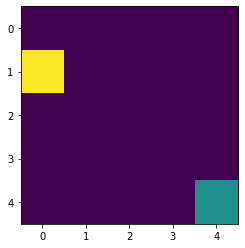

Action: Discrete(4)
Q_table: [[[ 1.17736245 -0.26746636  0.72803584 -0.02791772]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.13154784  0.730944   -0.2118784 ]
  [ 0.36       -0.375104    0.36       -0.2118784 ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.36       -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.         -0.36      ]
  [ 0.          0.          0

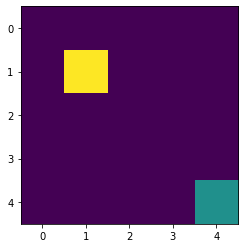

Action: Discrete(4)
Q_table: [[[ 1.17736245 -0.26746636  0.72803584 -0.02791772]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.13154784  0.8423552  -0.2118784 ]
  [ 0.36       -0.375104    0.36       -0.2118784 ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.36       -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.         -0.36      ]
  [ 0.          0.          0

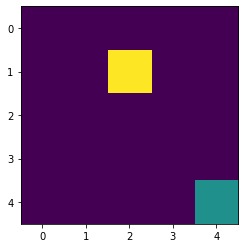

Action: Discrete(4)
Q_table: [[[ 1.17736245 -0.26746636  0.72803584 -0.02791772]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.13154784  0.8423552  -0.2118784 ]
  [ 0.36       -0.375104    0.52       -0.2118784 ]
  [ 0.2         0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.36       -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.         -0.36      ]
  [ 0.          0.          0

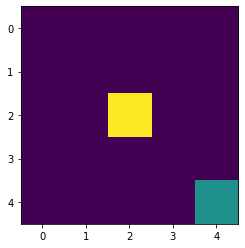

Action: Discrete(4)
Q_table: [[[ 1.17736245 -0.26746636  0.72803584 -0.02791772]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.13154784  0.8423552  -0.2118784 ]
  [ 0.36       -0.375104    0.52       -0.2118784 ]
  [ 0.4176      0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.36       -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.         -0.36      ]
  [ 0.          0.          0

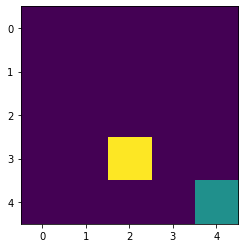

Action: Discrete(4)
Q_table: [[[ 1.17736245 -0.26746636  0.72803584 -0.02791772]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.13154784  0.8423552  -0.2118784 ]
  [ 0.36       -0.375104    0.52       -0.2118784 ]
  [ 0.4176      0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.488      -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.         -0.36      ]
  [ 0.          0.          0

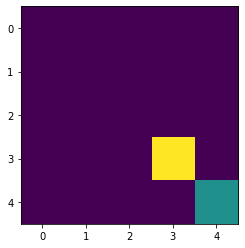

Action: Discrete(4)
Q_table: [[[ 1.17736245 -0.26746636  0.72803584 -0.02791772]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.13154784  0.8423552  -0.2118784 ]
  [ 0.36       -0.375104    0.52       -0.2118784 ]
  [ 0.4176      0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.488      -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.2        -0.36      ]
  [ 0.          0.          0

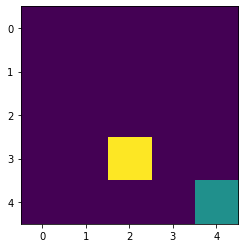

Action: Discrete(4)
Q_table: [[[ 1.17736245 -0.26746636  0.72803584 -0.02791772]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.13154784  0.8423552  -0.2118784 ]
  [ 0.36       -0.375104    0.52       -0.2118784 ]
  [ 0.4176      0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.488      -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.2        -0.36      ]
  [ 0.          0.          0

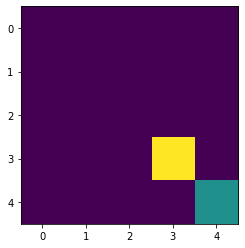

Round 7
Action: Discrete(4)
Q_table: [[[ 1.17736245 -0.26746636  0.72803584 -0.02791772]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.13154784  0.8423552  -0.2118784 ]
  [ 0.36       -0.375104    0.52       -0.2118784 ]
  [ 0.4176      0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.488      -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.36       -0.36      ]
  [ 0.          0.   

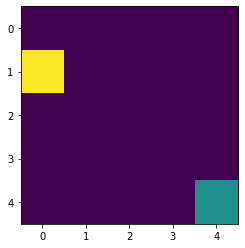

Action: Discrete(4)
Q_table: [[[ 1.27666679 -0.26746636  0.72803584 -0.02791772]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.13154784  0.8423552  -0.2118784 ]
  [ 0.36       -0.375104    0.52       -0.2118784 ]
  [ 0.4176      0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.488      -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.36       -0.36      ]
  [ 0.          0.          0

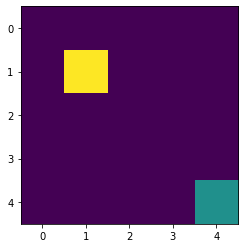

Action: Discrete(4)
Q_table: [[[ 1.27666679 -0.26746636  0.72803584 -0.02791772]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.13154784  0.95708416 -0.2118784 ]
  [ 0.36       -0.375104    0.52       -0.2118784 ]
  [ 0.4176      0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.488      -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.36       -0.36      ]
  [ 0.          0.          0

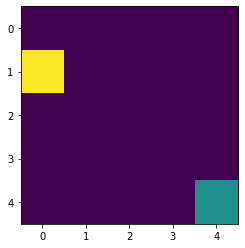

Action: Discrete(4)
Q_table: [[[ 1.27666679 -0.26746636  0.72803584 -0.02791772]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.13154784  0.95708416 -0.2118784 ]
  [ 0.36       -0.375104    0.52       -0.21636925]
  [ 0.4176      0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.488      -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.36       -0.36      ]
  [ 0.          0.          0

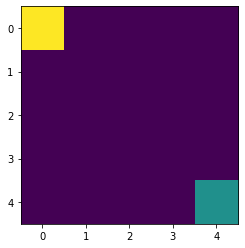

Action: Discrete(4)
Q_table: [[[ 1.27666679 -0.26746636  0.72803584 -0.02791772]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  0.95708416 -0.2118784 ]
  [ 0.36       -0.375104    0.52       -0.21636925]
  [ 0.4176      0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.488      -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.36       -0.36      ]
  [ 0.          0.          0

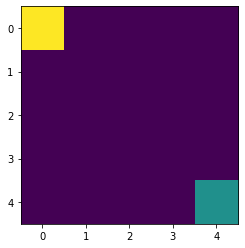

Action: Discrete(4)
Q_table: [[[ 1.27666679 -0.2097064   0.72803584 -0.02791772]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  0.95708416 -0.2118784 ]
  [ 0.36       -0.375104    0.52       -0.21636925]
  [ 0.4176      0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.488      -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.36       -0.36      ]
  [ 0.          0.          0

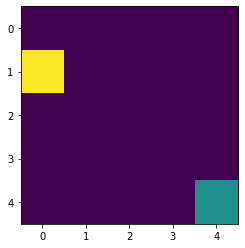

Action: Discrete(4)
Q_table: [[[ 1.3744669  -0.2097064   0.72803584 -0.02791772]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  0.95708416 -0.2118784 ]
  [ 0.36       -0.375104    0.52       -0.21636925]
  [ 0.4176      0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.488      -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.36       -0.36      ]
  [ 0.          0.          0

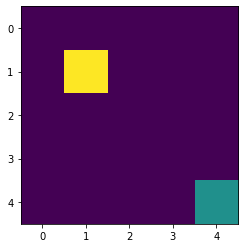

Action: Discrete(4)
Q_table: [[[ 1.3744669  -0.2097064   0.72803584 -0.02791772]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  1.04886733 -0.2118784 ]
  [ 0.36       -0.375104    0.52       -0.21636925]
  [ 0.4176      0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.488      -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.36       -0.36      ]
  [ 0.          0.          0

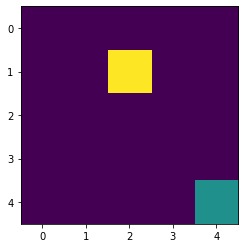

Action: Discrete(4)
Q_table: [[[ 1.3744669  -0.2097064   0.72803584 -0.02791772]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  1.04886733 -0.2118784 ]
  [ 0.36       -0.375104    0.682816   -0.21636925]
  [ 0.4176      0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.488      -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.36       -0.36      ]
  [ 0.          0.          0

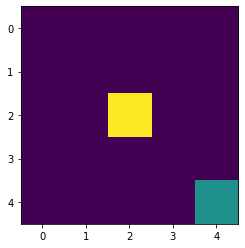

Round 8
Action: Discrete(4)
Q_table: [[[ 1.3744669  -0.2097064   0.72803584 -0.02791772]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  1.04886733 -0.2118784 ]
  [ 0.36       -0.375104    0.682816   -0.21636925]
  [ 0.61216     0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.488      -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.36       -0.36      ]
  [ 0.          0.   

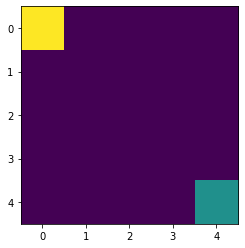

Action: Discrete(4)
Q_table: [[[ 1.3744669  -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  1.04886733 -0.2118784 ]
  [ 0.36       -0.375104    0.682816   -0.21636925]
  [ 0.61216     0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.488      -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.36       -0.36      ]
  [ 0.          0.          0

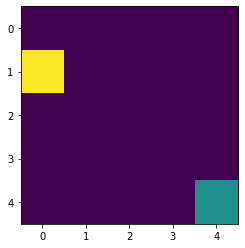

Action: Discrete(4)
Q_table: [[[ 1.46739229 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  1.04886733 -0.2118784 ]
  [ 0.36       -0.375104    0.682816   -0.21636925]
  [ 0.61216     0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.488      -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.36       -0.36      ]
  [ 0.          0.          0

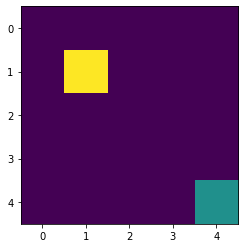

Action: Discrete(4)
Q_table: [[[ 1.46739229 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  1.14834442 -0.2118784 ]
  [ 0.36       -0.375104    0.682816   -0.21636925]
  [ 0.61216     0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.488      -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.36       -0.36      ]
  [ 0.          0.          0

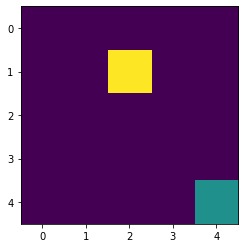

Action: Discrete(4)
Q_table: [[[ 1.46739229 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  1.14834442 -0.2118784 ]
  [ 0.36       -0.375104    0.8441984  -0.21636925]
  [ 0.61216     0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.488      -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.36       -0.36      ]
  [ 0.          0.          0

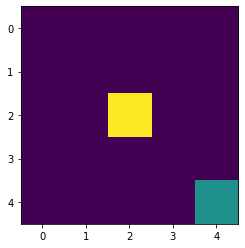

Action: Discrete(4)
Q_table: [[[ 1.46739229 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  1.14834442 -0.2118784 ]
  [ 0.36       -0.375104    0.8441984  -0.21636925]
  [ 0.767808    0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.488      -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.36       -0.36      ]
  [ 0.          0.          0

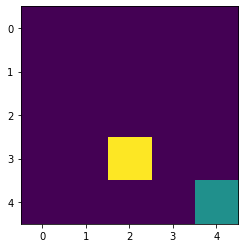

Action: Discrete(4)
Q_table: [[[ 1.46739229 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  1.14834442 -0.2118784 ]
  [ 0.36       -0.375104    0.8441984  -0.21636925]
  [ 0.767808    0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.648      -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.          0.          0.36       -0.36      ]
  [ 0.          0.          0

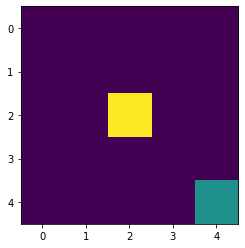

Action: Discrete(4)
Q_table: [[[ 1.46739229 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  1.14834442 -0.2118784 ]
  [ 0.36       -0.375104    0.8441984  -0.21636925]
  [ 0.767808    0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.648      -0.168       0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.         -0.09632     0.36       -0.36      ]
  [ 0.          0.          0

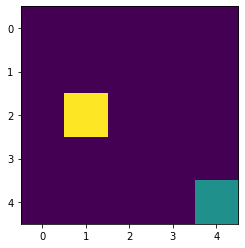

Action: Discrete(4)
Q_table: [[[ 1.46739229 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  1.14834442 -0.2118784 ]
  [ 0.36       -0.375104    0.8441984  -0.21636925]
  [ 0.767808    0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.4432     -0.2       ]
  [ 0.648      -0.168       0.         -0.129088  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.         -0.09632     0.36       -0.36      ]
  [ 0.          0.          0

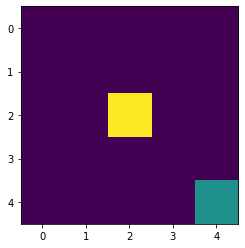

Round 9
Action: Discrete(4)
Q_table: [[[ 1.46739229 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  1.14834442 -0.2118784 ]
  [ 0.36       -0.375104    0.8441984  -0.21636925]
  [ 0.767808    0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.65824    -0.2       ]
  [ 0.648      -0.168       0.         -0.129088  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.         -0.09632     0.36       -0.36      ]
  [ 0.          0.   

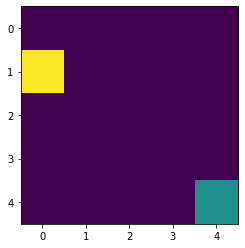

Action: Discrete(4)
Q_table: [[[ 1.55764894 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  1.14834442 -0.2118784 ]
  [ 0.36       -0.375104    0.8441984  -0.21636925]
  [ 0.767808    0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.65824    -0.2       ]
  [ 0.648      -0.168       0.         -0.129088  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.         -0.09632     0.36       -0.36      ]
  [ 0.          0.          0

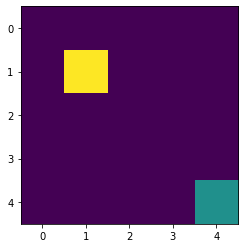

Action: Discrete(4)
Q_table: [[[ 1.55764894 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  1.25374728 -0.2118784 ]
  [ 0.36       -0.375104    0.8441984  -0.21636925]
  [ 0.767808    0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.65824    -0.2       ]
  [ 0.648      -0.168       0.         -0.129088  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.         -0.09632     0.36       -0.36      ]
  [ 0.          0.          0

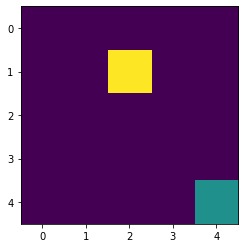

Action: Discrete(4)
Q_table: [[[ 1.55764894 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  1.25374728 -0.2118784 ]
  [ 0.36       -0.375104    0.998208   -0.21636925]
  [ 0.767808    0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.65824    -0.2       ]
  [ 0.648      -0.168       0.         -0.129088  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.         -0.09632     0.36       -0.36      ]
  [ 0.          0.          0

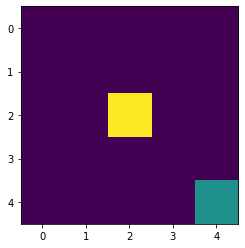

Action: Discrete(4)
Q_table: [[[ 1.55764894 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  1.25374728 -0.2118784 ]
  [ 0.36       -0.375104    0.998208   -0.21636925]
  [ 0.9179264   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.65824    -0.2       ]
  [ 0.648      -0.168       0.         -0.129088  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.         -0.09632     0.36       -0.36      ]
  [ 0.          0.          0

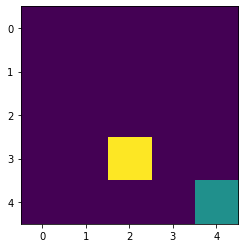

Action: Discrete(4)
Q_table: [[[ 1.55764894 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  1.25374728 -0.2118784 ]
  [ 0.36       -0.375104    0.998208   -0.21636925]
  [ 0.9179264   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.65824    -0.2       ]
  [ 0.776      -0.168       0.         -0.129088  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.         -0.09632     0.36       -0.36      ]
  [ 0.          0.          0

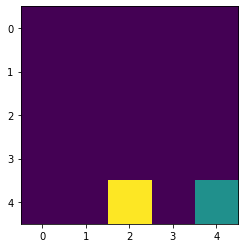

Action: Discrete(4)
Q_table: [[[ 1.55764894 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  1.25374728 -0.2118784 ]
  [ 0.36       -0.375104    0.998208   -0.21636925]
  [ 0.9179264   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.65824    -0.2       ]
  [ 0.776      -0.168       0.         -0.129088  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.36       -0.36      ]
  [ 0.          0.          0

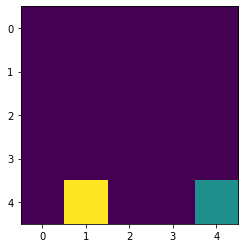

Action: Discrete(4)
Q_table: [[[ 1.55764894 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  1.25374728 -0.2118784 ]
  [ 0.36       -0.375104    0.998208   -0.21636925]
  [ 0.9179264   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.65824    -0.2       ]
  [ 0.776      -0.168       0.         -0.129088  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.36       -0.36      ]
  [ 0.          0.          0

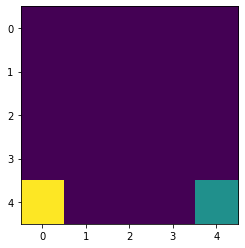

Action: Discrete(4)
Q_table: [[[ 1.55764894 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  1.25374728 -0.2118784 ]
  [ 0.36       -0.375104    0.998208   -0.21636925]
  [ 0.9179264   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.65824    -0.2       ]
  [ 0.776      -0.168       0.         -0.129088  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.36       -0.36      ]
  [ 0.          0.          0

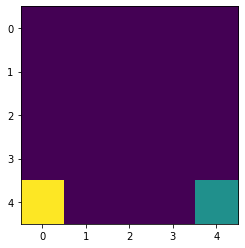

Round 10
Action: Discrete(4)
Q_table: [[[ 1.55764894 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  1.25374728 -0.2118784 ]
  [ 0.36       -0.375104    0.998208   -0.21636925]
  [ 0.9179264   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.65824    -0.2       ]
  [ 0.776      -0.168       0.         -0.129088  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.36       -0.36      ]
  [ 0.          0.  

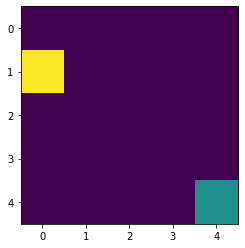

Action: Discrete(4)
Q_table: [[[ 1.64671872 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.10097159  1.25374728 -0.2118784 ]
  [ 0.36       -0.375104    0.998208   -0.21636925]
  [ 0.9179264   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.65824    -0.2       ]
  [ 0.776      -0.168       0.         -0.129088  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.36       -0.36      ]
  [ 0.          0.          0

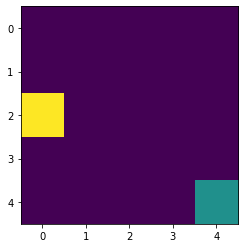

Action: Discrete(4)
Q_table: [[[ 1.64671872 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.25374728 -0.2118784 ]
  [ 0.36       -0.375104    0.998208   -0.21636925]
  [ 0.9179264   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2         0.        ]
  [ 0.          0.          0.65824    -0.2       ]
  [ 0.776      -0.168       0.         -0.129088  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.36       -0.36      ]
  [ 0.          0.          0

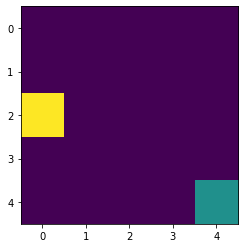

Action: Discrete(4)
Q_table: [[[ 1.64671872 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.25374728 -0.2118784 ]
  [ 0.36       -0.375104    0.998208   -0.21636925]
  [ 0.9179264   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.2        -0.168     ]
  [ 0.          0.          0.65824    -0.2       ]
  [ 0.776      -0.168       0.         -0.129088  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.36       -0.36      ]
  [ 0.          0.          0

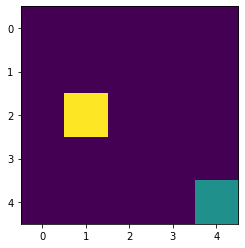

Action: Discrete(4)
Q_table: [[[ 1.64671872 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.25374728 -0.2118784 ]
  [ 0.36       -0.375104    0.998208   -0.21636925]
  [ 0.9179264   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          0.65824    -0.2       ]
  [ 0.776      -0.168       0.         -0.129088  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.36       -0.36      ]
  [ 0.          0.          0

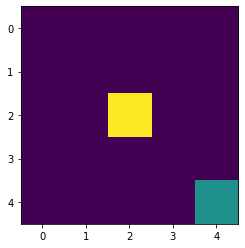

Action: Discrete(4)
Q_table: [[[ 1.64671872 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.25374728 -0.2118784 ]
  [ 0.36       -0.375104    0.998208   -0.21636925]
  [ 0.9179264   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          0.850752   -0.2       ]
  [ 0.776      -0.168       0.         -0.129088  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.36       -0.36      ]
  [ 0.          0.          0

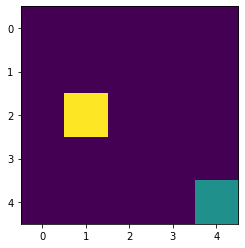

Action: Discrete(4)
Q_table: [[[ 1.64671872 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.25374728 -0.2118784 ]
  [ 0.36       -0.375104    0.998208   -0.21636925]
  [ 0.9179264   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          0.850752   -0.2       ]
  [ 0.776      -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.36       -0.36      ]
  [ 0.          0.          0

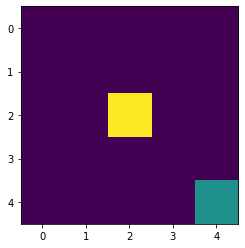

Action: Discrete(4)
Q_table: [[[ 1.64671872 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.25374728 -0.2118784 ]
  [ 0.36       -0.375104    0.998208   -0.21636925]
  [ 0.9179264   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.776      -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.36       -0.36      ]
  [ 0.          0.          0

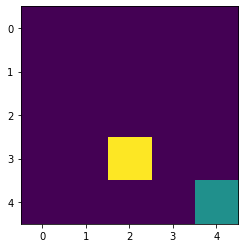

Action: Discrete(4)
Q_table: [[[ 1.64671872 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.25374728 -0.2118784 ]
  [ 0.36       -0.375104    0.998208   -0.21636925]
  [ 0.9179264   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.8784     -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.36       -0.36      ]
  [ 0.          0.          0

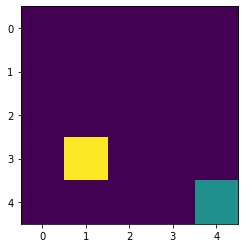

Round 11
Action: Discrete(4)
Q_table: [[[ 1.64671872 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.25374728 -0.2118784 ]
  [ 0.36       -0.375104    0.998208   -0.21636925]
  [ 0.9179264   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.8784     -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.36       -0.488     ]
  [ 0.          0.  

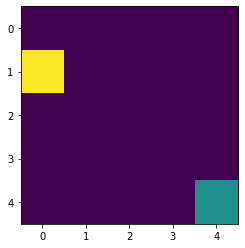

Action: Discrete(4)
Q_table: [[[ 1.71797454 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.25374728 -0.2118784 ]
  [ 0.36       -0.375104    0.998208   -0.21636925]
  [ 0.9179264   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.8784     -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.36       -0.488     ]
  [ 0.          0.          0

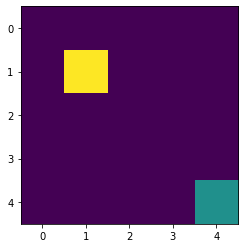

Action: Discrete(4)
Q_table: [[[ 1.71797454 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.36271111 -0.2118784 ]
  [ 0.36       -0.375104    0.998208   -0.21636925]
  [ 0.9179264   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.8784     -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.36       -0.488     ]
  [ 0.          0.          0

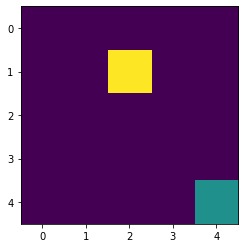

Action: Discrete(4)
Q_table: [[[ 1.71797454 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.36271111 -0.2118784 ]
  [ 0.36       -0.375104    1.14543462 -0.21636925]
  [ 0.9179264   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.8784     -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.36       -0.488     ]
  [ 0.          0.          0

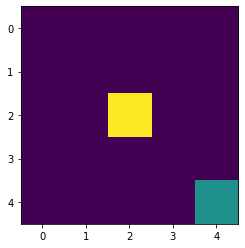

Action: Discrete(4)
Q_table: [[[ 1.71797454 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.36271111 -0.2118784 ]
  [ 0.36       -0.375104    1.14543462 -0.21636925]
  [ 1.07488512  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.8784     -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.36       -0.488     ]
  [ 0.          0.          0

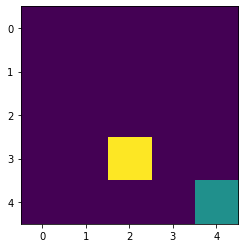

Action: Discrete(4)
Q_table: [[[ 1.71797454 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.36271111 -0.2118784 ]
  [ 0.36       -0.375104    1.14543462 -0.21636925]
  [ 1.07488512  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.96032    -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.36       -0.488     ]
  [ 0.          0.          0

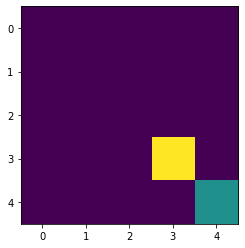

Action: Discrete(4)
Q_table: [[[ 1.71797454 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.36271111 -0.2118784 ]
  [ 0.36       -0.375104    1.14543462 -0.21636925]
  [ 1.07488512  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.96032    -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.488      -0.488     ]
  [ 0.          0.          0

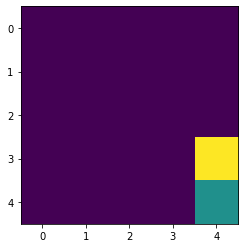

Action: Discrete(4)
Q_table: [[[ 1.71797454 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.36271111 -0.2118784 ]
  [ 0.36       -0.375104    1.14543462 -0.21636925]
  [ 1.07488512  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.96032    -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.488      -0.488     ]
  [ 0.          0.          0

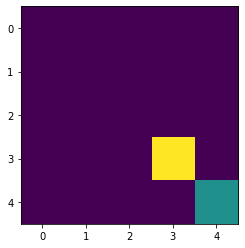

Action: Discrete(4)
Q_table: [[[ 1.71797454 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.36271111 -0.2118784 ]
  [ 0.36       -0.375104    1.14543462 -0.21636925]
  [ 1.07488512  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.96032    -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.488      -0.488     ]
  [ 0.          0.          0

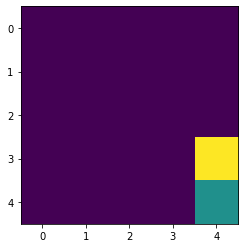

Round 12
Action: Discrete(4)
Q_table: [[[ 1.71797454 -0.2097064   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.36271111 -0.2118784 ]
  [ 0.36       -0.375104    1.14543462 -0.21636925]
  [ 1.07488512  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.96032    -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.488      -0.488     ]
  [ 0.          0.  

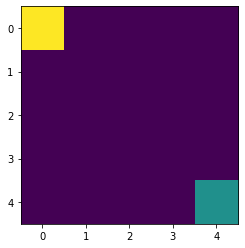

Action: Discrete(4)
Q_table: [[[ 1.71797454 -0.0928892   0.72803584 -0.00241947]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.36271111 -0.2118784 ]
  [ 0.36       -0.375104    1.14543462 -0.21636925]
  [ 1.07488512  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.96032    -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.488      -0.488     ]
  [ 0.          0.          0

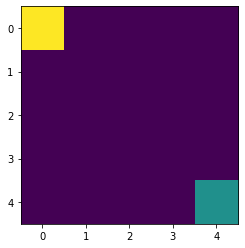

Action: Discrete(4)
Q_table: [[[ 1.71797454 -0.0928892   0.72803584  0.07294035]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.36271111 -0.2118784 ]
  [ 0.36       -0.375104    1.14543462 -0.21636925]
  [ 1.07488512  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.96032    -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.488      -0.488     ]
  [ 0.          0.          0

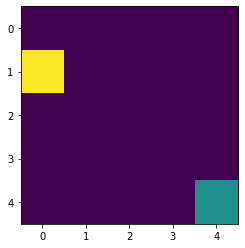

Action: Discrete(4)
Q_table: [[[ 1.79241341 -0.0928892   0.72803584  0.07294035]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.36271111 -0.2118784 ]
  [ 0.36       -0.375104    1.14543462 -0.21636925]
  [ 1.07488512  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.96032    -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.488      -0.488     ]
  [ 0.          0.          0

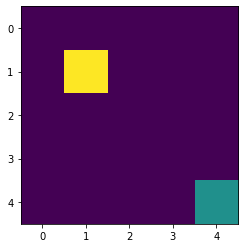

Action: Discrete(4)
Q_table: [[[ 1.79241341 -0.0928892   0.72803584  0.07294035]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.47343842 -0.2118784 ]
  [ 0.36       -0.375104    1.14543462 -0.21636925]
  [ 1.07488512  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.96032    -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.488      -0.488     ]
  [ 0.          0.          0

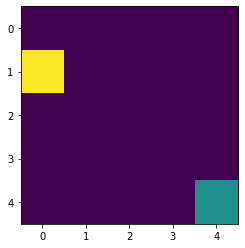

Action: Discrete(4)
Q_table: [[[ 1.79241341 -0.0928892   0.72803584  0.07294035]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.47343842 -0.2118784 ]
  [ 0.36       -0.375104    1.14543462 -0.13734526]
  [ 1.07488512  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.96032    -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.488      -0.488     ]
  [ 0.          0.          0

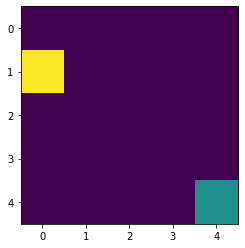

Action: Discrete(4)
Q_table: [[[ 1.79241341 -0.0928892   0.72803584  0.07294035]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.47343842 -0.13375257]
  [ 0.36       -0.375104    1.14543462 -0.13734526]
  [ 1.07488512  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.96032    -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.488      -0.488     ]
  [ 0.          0.          0

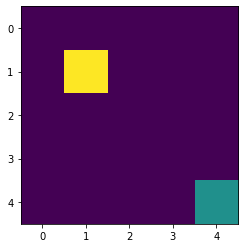

Action: Discrete(4)
Q_table: [[[ 1.79241341 -0.0928892   0.72803584  0.07294035]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.56202028 -0.13375257]
  [ 0.36       -0.375104    1.14543462 -0.13734526]
  [ 1.07488512  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.96032    -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.488      -0.488     ]
  [ 0.          0.          0

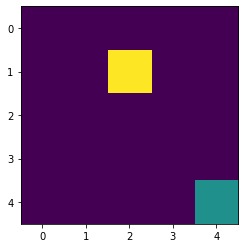

Action: Discrete(4)
Q_table: [[[ 1.79241341 -0.0928892   0.72803584  0.07294035]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.56202028 -0.13375257]
  [ 0.36       -0.375104    1.28832932 -0.13734526]
  [ 1.07488512  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.96032    -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.488      -0.488     ]
  [ 0.          0.          0

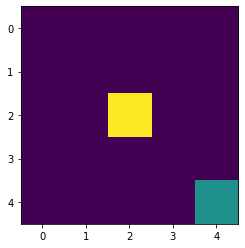

Round 13
Action: Discrete(4)
Q_table: [[[ 1.79241341 -0.0928892   0.72803584  0.07294035]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.56202028 -0.13375257]
  [ 0.36       -0.375104    1.28832932 -0.13734526]
  [ 1.2135593   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.96032    -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.488      -0.488     ]
  [ 0.          0.  

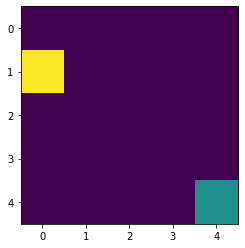

Action: Discrete(4)
Q_table: [[[ 1.88385397 -0.0928892   0.72803584  0.07294035]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.56202028 -0.13375257]
  [ 0.36       -0.375104    1.28832932 -0.13734526]
  [ 1.2135593   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.96032    -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.488      -0.488     ]
  [ 0.          0.          0

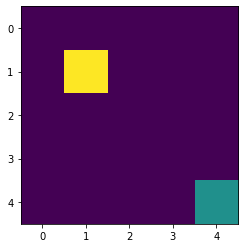

Action: Discrete(4)
Q_table: [[[ 1.88385397 -0.0928892   0.72803584  0.07294035]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.65574891 -0.13375257]
  [ 0.36       -0.375104    1.28832932 -0.13734526]
  [ 1.2135593   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.96032    -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.488      -0.488     ]
  [ 0.          0.          0

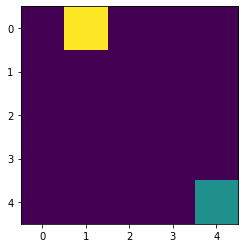

Action: Discrete(4)
Q_table: [[[ 1.88385397 -0.0928892   0.72803584  0.07294035]
  [ 0.812864    0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.65574891 -0.13375257]
  [ 0.36       -0.37002496  1.28832932 -0.13734526]
  [ 1.2135593   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.96032    -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.488      -0.488     ]
  [ 0.          0.          0

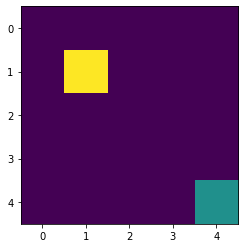

Action: Discrete(4)
Q_table: [[[ 1.88385397 -0.0928892   0.72803584  0.07294035]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.65574891 -0.13375257]
  [ 0.36       -0.37002496  1.28832932 -0.13734526]
  [ 1.2135593   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.96032    -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.488      -0.488     ]
  [ 0.          0.          0

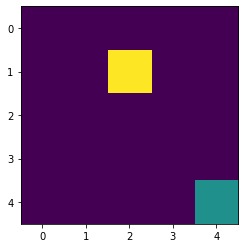

Action: Discrete(4)
Q_table: [[[ 1.88385397 -0.0928892   0.72803584  0.07294035]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.65574891 -0.13375257]
  [ 0.36       -0.37002496  1.42483294 -0.13734526]
  [ 1.2135593   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.96032    -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.488      -0.488     ]
  [ 0.          0.          0

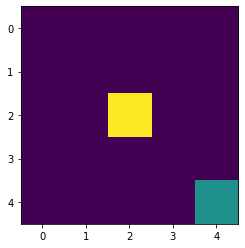

Action: Discrete(4)
Q_table: [[[ 1.88385397 -0.0928892   0.72803584  0.07294035]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.65574891 -0.13375257]
  [ 0.36       -0.37002496  1.42483294 -0.13734526]
  [ 1.32449864  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 0.96032    -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.488      -0.488     ]
  [ 0.          0.          0

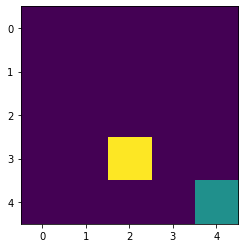

Action: Discrete(4)
Q_table: [[[ 1.88385397 -0.0928892   0.72803584  0.07294035]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.65574891 -0.13375257]
  [ 0.36       -0.37002496  1.42483294 -0.13734526]
  [ 1.32449864  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.046336   -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.488      -0.488     ]
  [ 0.          0.          0

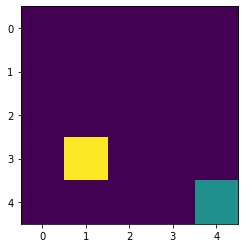

Action: Discrete(4)
Q_table: [[[ 1.88385397 -0.0928892   0.72803584  0.07294035]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.65574891 -0.13375257]
  [ 0.36       -0.37002496  1.42483294 -0.13734526]
  [ 1.32449864  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.046336   -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.          0.        ]
  [ 0.2        -0.09632     0.488      -0.5904    ]
  [ 0.          0.          0

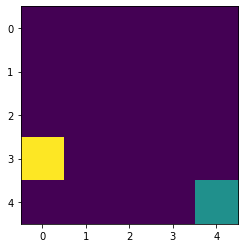

Round 14
Action: Discrete(4)
Q_table: [[[ 1.88385397 -0.0928892   0.72803584  0.07294035]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.65574891 -0.13375257]
  [ 0.36       -0.37002496  1.42483294 -0.13734526]
  [ 1.32449864  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.046336   -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.488      -0.5904    ]
  [ 0.          0.  

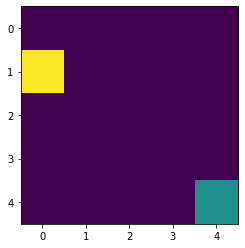

Action: Discrete(4)
Q_table: [[[ 1.972003   -0.0928892   0.72803584  0.07294035]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.65574891 -0.13375257]
  [ 0.36       -0.37002496  1.42483294 -0.13734526]
  [ 1.32449864  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.046336   -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.488      -0.5904    ]
  [ 0.          0.          0

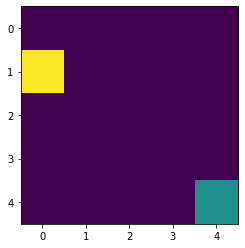

Action: Discrete(4)
Q_table: [[[ 1.972003   -0.0928892   0.72803584  0.07294035]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.65574891 -0.04208223]
  [ 0.36       -0.37002496  1.42483294 -0.13734526]
  [ 1.32449864  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.046336   -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.488      -0.5904    ]
  [ 0.          0.          0

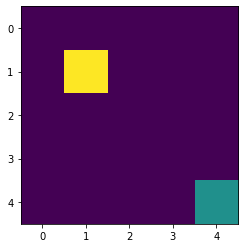

Action: Discrete(4)
Q_table: [[[ 1.972003   -0.0928892   0.72803584  0.07294035]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.7525724  -0.04208223]
  [ 0.36       -0.37002496  1.42483294 -0.13734526]
  [ 1.32449864  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.046336   -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.488      -0.5904    ]
  [ 0.          0.          0

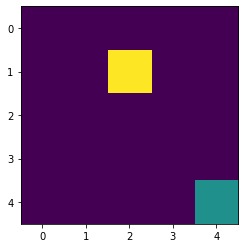

Action: Discrete(4)
Q_table: [[[ 1.972003   -0.0928892   0.72803584  0.07294035]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.7525724  -0.04208223]
  [ 0.36       -0.37002496  1.55178614 -0.13734526]
  [ 1.32449864  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.046336   -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.488      -0.5904    ]
  [ 0.          0.          0

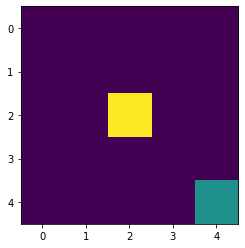

Action: Discrete(4)
Q_table: [[[ 1.972003   -0.0928892   0.72803584  0.07294035]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.7525724  -0.04208223]
  [ 0.36       -0.37002496  1.55178614 -0.13734526]
  [ 1.42701267  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.046336   -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.488      -0.5904    ]
  [ 0.          0.          0

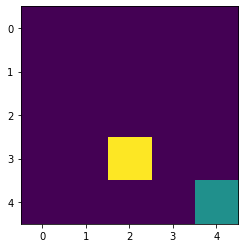

Action: Discrete(4)
Q_table: [[[ 1.972003   -0.0928892   0.72803584  0.07294035]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.7525724  -0.04208223]
  [ 0.36       -0.37002496  1.55178614 -0.13734526]
  [ 1.42701267  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.1151488  -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.488      -0.5904    ]
  [ 0.          0.          0

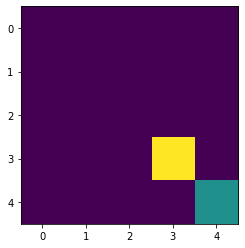

Action: Discrete(4)
Q_table: [[[ 1.972003   -0.0928892   0.72803584  0.07294035]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.7525724  -0.04208223]
  [ 0.36       -0.37002496  1.55178614 -0.13734526]
  [ 1.42701267  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.1151488  -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.648      -0.5904    ]
  [ 0.          0.          0

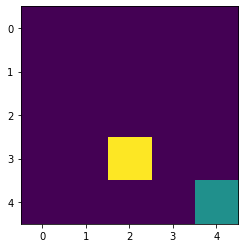

Action: Discrete(4)
Q_table: [[[ 1.972003   -0.0928892   0.72803584  0.07294035]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.7525724  -0.04208223]
  [ 0.36       -0.37002496  1.55178614 -0.13734526]
  [ 1.42701267  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.1151488  -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.648      -0.5904    ]
  [ 0.          0.          0

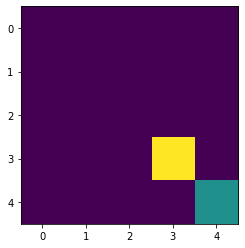

Round 15
Action: Discrete(4)
Q_table: [[[ 1.972003   -0.0928892   0.72803584  0.07294035]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.7525724  -0.04208223]
  [ 0.36       -0.37002496  1.55178614 -0.13734526]
  [ 1.42701267  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.1151488  -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.776      -0.5904    ]
  [ 0.          0.  

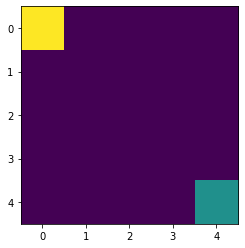

Action: Discrete(4)
Q_table: [[[ 1.972003   -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.7525724  -0.04208223]
  [ 0.36       -0.37002496  1.55178614 -0.13734526]
  [ 1.42701267  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.1151488  -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.776      -0.5904    ]
  [ 0.          0.          0

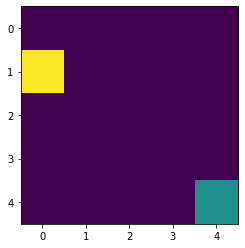

Action: Discrete(4)
Q_table: [[[ 2.05801399 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.7525724  -0.04208223]
  [ 0.36       -0.37002496  1.55178614 -0.13734526]
  [ 1.42701267  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.1151488  -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.776      -0.5904    ]
  [ 0.          0.          0

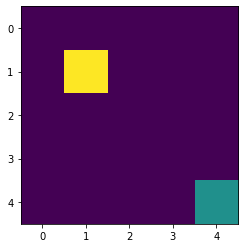

Action: Discrete(4)
Q_table: [[[ 2.05801399 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.8503437  -0.04208223]
  [ 0.36       -0.37002496  1.55178614 -0.13734526]
  [ 1.42701267  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.1151488  -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.776      -0.5904    ]
  [ 0.          0.          0

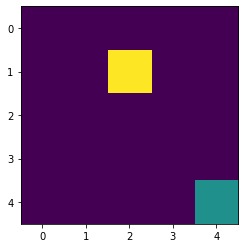

Action: Discrete(4)
Q_table: [[[ 2.05801399 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.8503437  -0.04208223]
  [ 0.36       -0.37002496  1.66975094 -0.13734526]
  [ 1.42701267  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.1151488  -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.776      -0.5904    ]
  [ 0.          0.          0

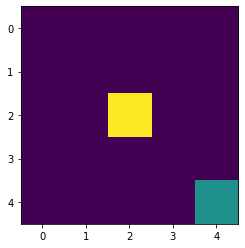

Action: Discrete(4)
Q_table: [[[ 2.05801399 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.8503437  -0.04208223]
  [ 0.36       -0.37002496  1.66975094 -0.13734526]
  [ 1.52003394  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.1151488  -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.776      -0.5904    ]
  [ 0.          0.          0

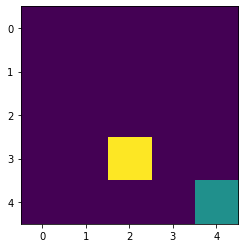

Action: Discrete(4)
Q_table: [[[ 2.05801399 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.8503437  -0.04208223]
  [ 0.36       -0.37002496  1.66975094 -0.13734526]
  [ 1.52003394  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.21627904 -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.776      -0.5904    ]
  [ 0.          0.          0

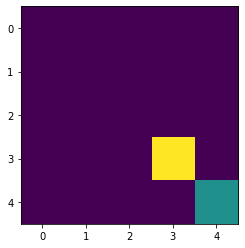

Action: Discrete(4)
Q_table: [[[ 2.05801399 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.8503437  -0.04208223]
  [ 0.36       -0.37002496  1.66975094 -0.13734526]
  [ 1.52003394  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.21627904 -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.8784     -0.5904    ]
  [ 0.          0.          0

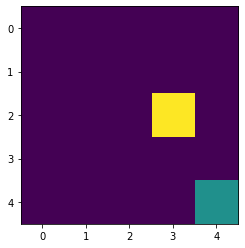

Action: Discrete(4)
Q_table: [[[ 2.05801399 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.8503437  -0.04208223]
  [ 0.36       -0.37002496  1.66975094 -0.13734526]
  [ 1.52003394  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.21627904 -0.168       0.         -0.16715008]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.8784     -0.5904    ]
  [ 0.         -0.2         0

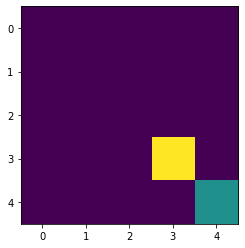

Round 16
Action: Discrete(4)
Q_table: [[[ 2.05801399 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.8503437  -0.04208223]
  [ 0.36       -0.37002496  1.66975094 -0.13734526]
  [ 1.52003394  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.21627904 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.8784     -0.5904    ]
  [ 0.         -0.2 

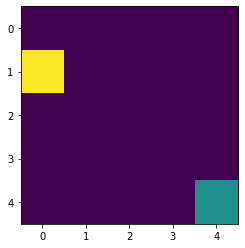

Action: Discrete(4)
Q_table: [[[ 2.14246618 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.8503437  -0.04208223]
  [ 0.36       -0.37002496  1.66975094 -0.13734526]
  [ 1.52003394  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.21627904 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.8784     -0.5904    ]
  [ 0.         -0.2         0

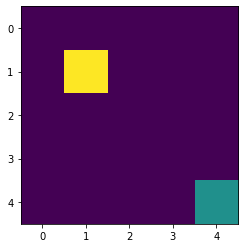

Action: Discrete(4)
Q_table: [[[ 2.14246618 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.94743511 -0.04208223]
  [ 0.36       -0.37002496  1.66975094 -0.13734526]
  [ 1.52003394  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.21627904 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.8784     -0.5904    ]
  [ 0.         -0.2         0

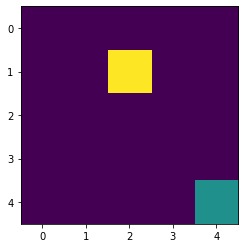

Action: Discrete(4)
Q_table: [[[ 2.14246618 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.94743511 -0.04208223]
  [ 0.36       -0.37002496  1.77900618 -0.13734526]
  [ 1.52003394  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.21627904 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.8784     -0.5904    ]
  [ 0.         -0.2         0

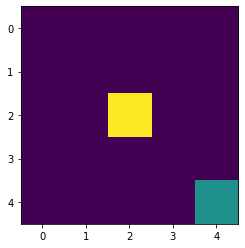

Action: Discrete(4)
Q_table: [[[ 2.14246618 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.94743511 -0.04208223]
  [ 0.36       -0.37002496  1.77900618 -0.13734526]
  [ 1.6106318   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.21627904 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.8784     -0.5904    ]
  [ 0.         -0.2         0

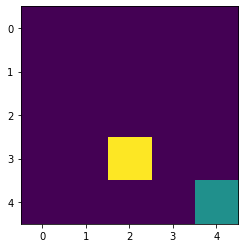

Action: Discrete(4)
Q_table: [[[ 2.14246618 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.94743511 -0.04208223]
  [ 0.36       -0.37002496  1.77900618 -0.13734526]
  [ 1.6106318   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.31356723 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.8784     -0.5904    ]
  [ 0.         -0.2         0

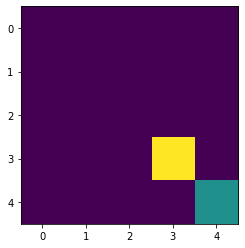

Action: Discrete(4)
Q_table: [[[ 2.14246618 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.94743511 -0.04208223]
  [ 0.36       -0.37002496  1.77900618 -0.13734526]
  [ 1.6106318   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.31356723 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.96032    -0.5904    ]
  [ 0.         -0.2         0

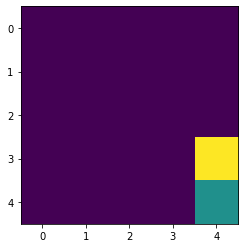

Action: Discrete(4)
Q_table: [[[ 2.14246618 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.94743511 -0.04208223]
  [ 0.36       -0.37002496  1.77900618 -0.13734526]
  [ 1.6106318   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.31356723 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.96032    -0.5904    ]
  [ 0.         -0.2         0

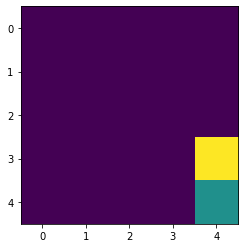

Action: Discrete(4)
Q_table: [[[ 2.14246618 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.94743511 -0.04208223]
  [ 0.36       -0.37002496  1.77900618 -0.13734526]
  [ 1.6106318   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.31356723 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.96032    -0.5904    ]
  [ 0.         -0.2         0

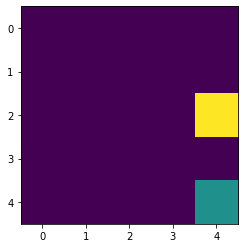

Round 17
Action: Discrete(4)
Q_table: [[[ 2.14246618 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.94743511 -0.04208223]
  [ 0.36       -0.37002496  1.77900618 -0.13734526]
  [ 1.6106318   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.31356723 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.96032    -0.5904    ]
  [ 0.         -0.2 

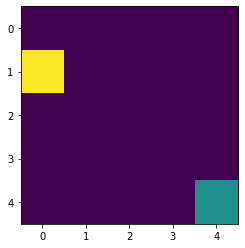

Action: Discrete(4)
Q_table: [[[ 2.22556256 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  1.94743511 -0.04208223]
  [ 0.36       -0.37002496  1.77900618 -0.13734526]
  [ 1.6106318   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.31356723 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.96032    -0.5904    ]
  [ 0.         -0.2         0

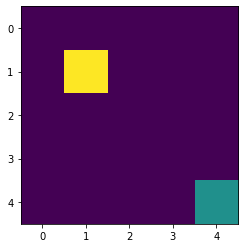

Action: Discrete(4)
Q_table: [[[ 2.22556256 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.04258908 -0.04208223]
  [ 0.36       -0.37002496  1.77900618 -0.13734526]
  [ 1.6106318   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.31356723 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.96032    -0.5904    ]
  [ 0.         -0.2         0

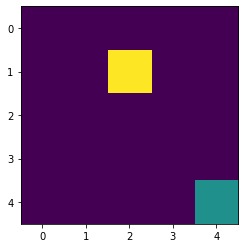

Action: Discrete(4)
Q_table: [[[ 2.22556256 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.04258908 -0.04208223]
  [ 0.36       -0.37002496  1.88090603 -0.13734526]
  [ 1.6106318   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.31356723 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.96032    -0.5904    ]
  [ 0.         -0.2         0

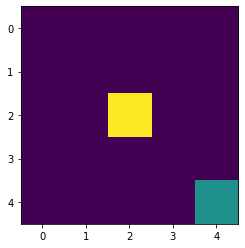

Action: Discrete(4)
Q_table: [[[ 2.22556256 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.04258908 -0.04208223]
  [ 0.36       -0.37002496  1.88090603 -0.13734526]
  [ 1.6986762   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.31356723 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.96032    -0.5904    ]
  [ 0.         -0.2         0

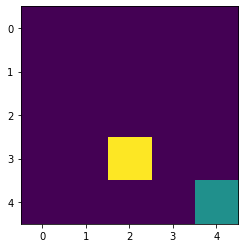

Action: Discrete(4)
Q_table: [[[ 2.22556256 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.04258908 -0.04208223]
  [ 0.36       -0.37002496  1.88090603 -0.13734526]
  [ 1.6986762   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.40450499 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     0.96032    -0.5904    ]
  [ 0.         -0.2         0

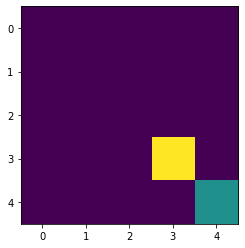

Action: Discrete(4)
Q_table: [[[ 2.22556256 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.04258908 -0.04208223]
  [ 0.36       -0.37002496  1.88090603 -0.13734526]
  [ 1.6986762   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.40450499 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.046336   -0.5904    ]
  [ 0.         -0.2         0

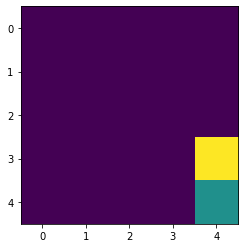

Action: Discrete(4)
Q_table: [[[ 2.22556256 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.04258908 -0.04208223]
  [ 0.36       -0.37002496  1.88090603 -0.13734526]
  [ 1.6986762   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.40450499 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.046336   -0.5904    ]
  [ 0.         -0.2         0

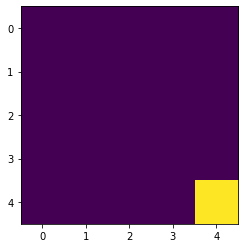

Round 18
Action: Discrete(4)
Q_table: [[[ 2.22556256 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.04258908 -0.04208223]
  [ 0.36       -0.37002496  1.88090603 -0.13734526]
  [ 1.6986762   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.40450499 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.046336   -0.5904    ]
  [ 0.         -0.2 

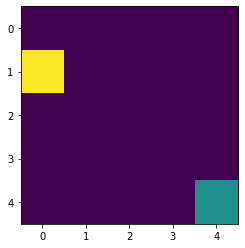

Action: Discrete(4)
Q_table: [[[ 2.3072643  -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.04258908 -0.04208223]
  [ 0.36       -0.37002496  1.88090603 -0.13734526]
  [ 1.6986762   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.40450499 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.046336   -0.5904    ]
  [ 0.         -0.2         0

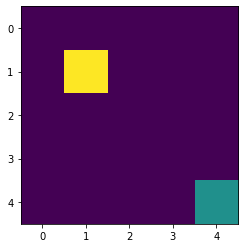

Action: Discrete(4)
Q_table: [[[ 2.3072643  -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.13501623 -0.04208223]
  [ 0.36       -0.37002496  1.88090603 -0.13734526]
  [ 1.6986762   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.40450499 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.046336   -0.5904    ]
  [ 0.         -0.2         0

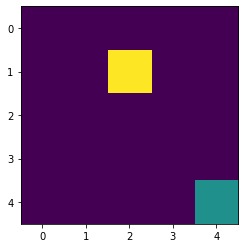

Action: Discrete(4)
Q_table: [[[ 2.3072643  -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.13501623 -0.04208223]
  [ 0.36       -0.37002496  1.97651302 -0.13734526]
  [ 1.6986762   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.40450499 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.046336   -0.5904    ]
  [ 0.         -0.2         0

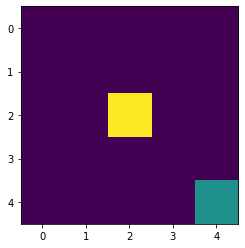

Action: Discrete(4)
Q_table: [[[ 2.3072643  -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.13501623 -0.04208223]
  [ 0.36       -0.37002496  1.97651302 -0.13734526]
  [ 1.78366176  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.40450499 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.046336   -0.5904    ]
  [ 0.         -0.2         0

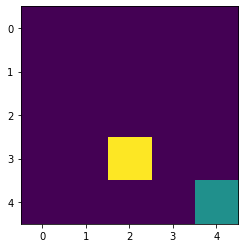

Action: Discrete(4)
Q_table: [[[ 2.3072643  -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.13501623 -0.04208223]
  [ 0.36       -0.37002496  1.97651302 -0.13734526]
  [ 1.78366176  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.49101775 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.046336   -0.5904    ]
  [ 0.         -0.2         0

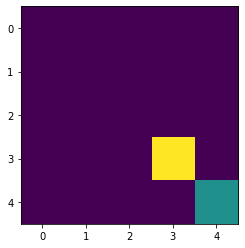

Action: Discrete(4)
Q_table: [[[ 2.3072643  -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.13501623 -0.04208223]
  [ 0.36       -0.37002496  1.97651302 -0.13734526]
  [ 1.78366176  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.49101775 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.1315328  -0.5904    ]
  [ 0.         -0.2         0

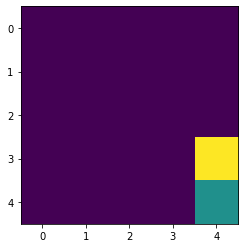

Action: Discrete(4)
Q_table: [[[ 2.3072643  -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.13501623 -0.04208223]
  [ 0.36       -0.37002496  1.97651302 -0.13734526]
  [ 1.78366176  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.49101775 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.1315328  -0.5904    ]
  [ 0.         -0.2         0

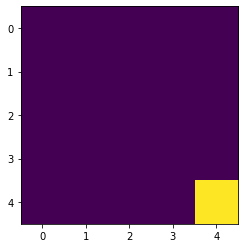

Round 19
Action: Discrete(4)
Q_table: [[[ 2.3072643  -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.13501623 -0.04208223]
  [ 0.36       -0.37002496  1.97651302 -0.13734526]
  [ 1.78366176  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.49101775 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.1315328  -0.5904    ]
  [ 0.         -0.2 

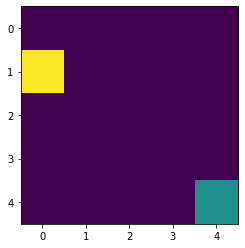

Action: Discrete(4)
Q_table: [[[ 2.38741404 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.13501623 -0.04208223]
  [ 0.36       -0.37002496  1.97651302 -0.13734526]
  [ 1.78366176  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.49101775 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.1315328  -0.5904    ]
  [ 0.         -0.2         0

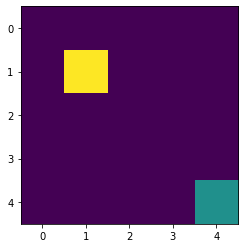

Action: Discrete(4)
Q_table: [[[ 2.38741404 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.22425507 -0.04208223]
  [ 0.36       -0.37002496  1.97651302 -0.13734526]
  [ 1.78366176  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.49101775 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.1315328  -0.5904    ]
  [ 0.         -0.2         0

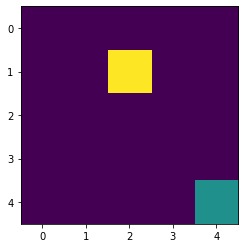

Action: Discrete(4)
Q_table: [[[ 2.38741404 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.22425507 -0.04208223]
  [ 0.36       -0.37002496  2.06659629 -0.13734526]
  [ 1.78366176  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.49101775 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.1315328  -0.5904    ]
  [ 0.         -0.2         0

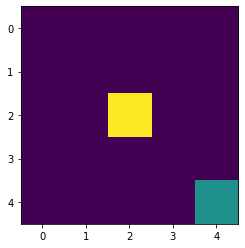

Action: Discrete(4)
Q_table: [[[ 2.38741404 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.22425507 -0.04208223]
  [ 0.36       -0.37002496  2.06659629 -0.13734526]
  [ 1.86549224  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.49101775 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.1315328  -0.5904    ]
  [ 0.         -0.2         0

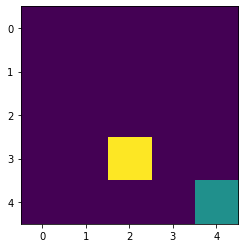

Action: Discrete(4)
Q_table: [[[ 2.38741404 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.22425507 -0.04208223]
  [ 0.36       -0.37002496  2.06659629 -0.13734526]
  [ 1.86549224  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.57385945 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.1315328  -0.5904    ]
  [ 0.         -0.2         0

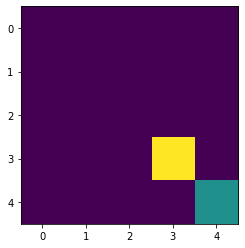

Action: Discrete(4)
Q_table: [[[ 2.38741404 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.22425507 -0.04208223]
  [ 0.36       -0.37002496  2.06659629 -0.13734526]
  [ 1.86549224  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.57385945 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.21791744 -0.5904    ]
  [ 0.         -0.2         0

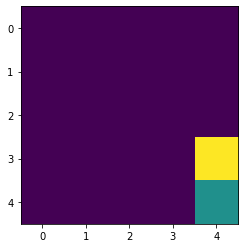

Action: Discrete(4)
Q_table: [[[ 2.38741404 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.22425507 -0.04208223]
  [ 0.36       -0.37002496  2.06659629 -0.13734526]
  [ 1.86549224  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.57385945 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.21791744 -0.5904    ]
  [ 0.         -0.2         0

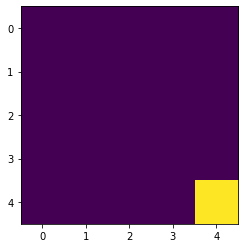

Round 20
Action: Discrete(4)
Q_table: [[[ 2.38741404 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.22425507 -0.04208223]
  [ 0.36       -0.37002496  2.06659629 -0.13734526]
  [ 1.86549224  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.57385945 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.21791744 -0.5904    ]
  [ 0.         -0.2 

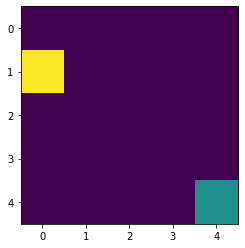

Action: Discrete(4)
Q_table: [[[ 2.46581204 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.22425507 -0.04208223]
  [ 0.36       -0.37002496  2.06659629 -0.13734526]
  [ 1.86549224  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.57385945 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.21791744 -0.5904    ]
  [ 0.         -0.2         0

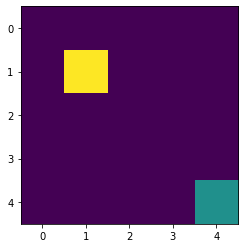

Action: Discrete(4)
Q_table: [[[ 2.46581204 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.31005946 -0.04208223]
  [ 0.36       -0.37002496  2.06659629 -0.13734526]
  [ 1.86549224  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.57385945 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.21791744 -0.5904    ]
  [ 0.         -0.2         0

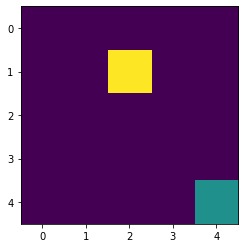

Action: Discrete(4)
Q_table: [[[ 2.46581204 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.31005946 -0.04208223]
  [ 0.36       -0.37002496  2.15175579 -0.13734526]
  [ 1.86549224  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.57385945 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.21791744 -0.5904    ]
  [ 0.         -0.2         0

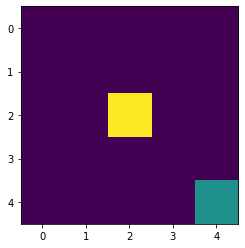

Action: Discrete(4)
Q_table: [[[ 2.46581204 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.31005946 -0.04208223]
  [ 0.36       -0.37002496  2.15175579 -0.13734526]
  [ 1.94421131  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.57385945 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.21791744 -0.5904    ]
  [ 0.         -0.2         0

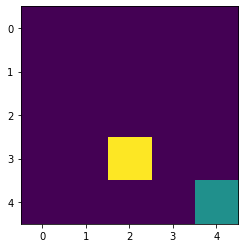

Action: Discrete(4)
Q_table: [[[ 2.46581204 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.31005946 -0.04208223]
  [ 0.36       -0.37002496  2.15175579 -0.13734526]
  [ 1.94421131  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.65395435 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.21791744 -0.5904    ]
  [ 0.         -0.2         0

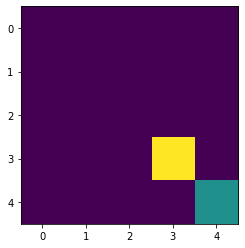

Action: Discrete(4)
Q_table: [[[ 2.46581204 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.31005946 -0.04208223]
  [ 0.36       -0.37002496  2.15175579 -0.13734526]
  [ 1.94421131  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.65395435 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.30570291 -0.5904    ]
  [ 0.         -0.2         0

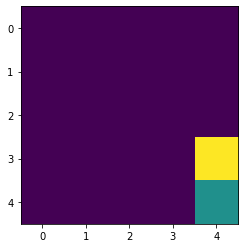

Action: Discrete(4)
Q_table: [[[ 2.46581204 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.31005946 -0.04208223]
  [ 0.36       -0.37002496  2.15175579 -0.13734526]
  [ 1.94421131  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.65395435 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.30570291 -0.5904    ]
  [ 0.         -0.2         0

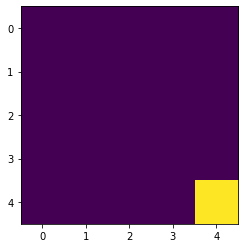

Round 21
Action: Discrete(4)
Q_table: [[[ 2.46581204 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.31005946 -0.04208223]
  [ 0.36       -0.37002496  2.15175579 -0.13734526]
  [ 1.94421131  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.65395435 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.30570291 -0.5904    ]
  [ 0.         -0.2 

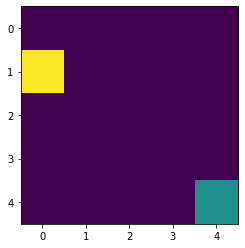

Action: Discrete(4)
Q_table: [[[ 2.54225915 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.31005946 -0.04208223]
  [ 0.36       -0.37002496  2.15175579 -0.13734526]
  [ 1.94421131  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.65395435 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.30570291 -0.5904    ]
  [ 0.         -0.2         0

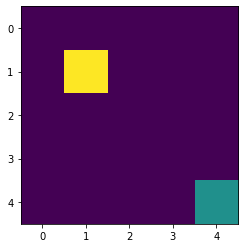

Action: Discrete(4)
Q_table: [[[ 2.54225915 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.39232849 -0.04208223]
  [ 0.36       -0.37002496  2.15175579 -0.13734526]
  [ 1.94421131  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.65395435 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.30570291 -0.5904    ]
  [ 0.         -0.2         0

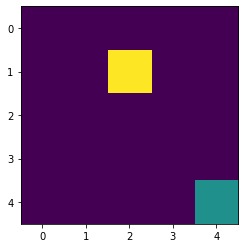

Action: Discrete(4)
Q_table: [[[ 2.54225915 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.39232849 -0.04208223]
  [ 0.36       -0.37002496  2.23247845 -0.13734526]
  [ 1.94421131  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.65395435 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.30570291 -0.5904    ]
  [ 0.         -0.2         0

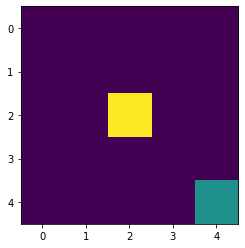

Action: Discrete(4)
Q_table: [[[ 2.54225915 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.39232849 -0.04208223]
  [ 0.36       -0.37002496  2.23247845 -0.13734526]
  [ 2.02000174  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.65395435 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.30570291 -0.5904    ]
  [ 0.         -0.2         0

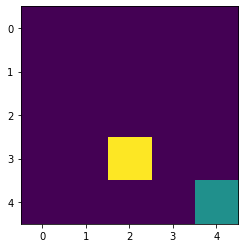

Action: Discrete(4)
Q_table: [[[ 2.54225915 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.39232849 -0.04208223]
  [ 0.36       -0.37002496  2.23247845 -0.13734526]
  [ 2.02000174  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.73207594 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.30570291 -0.5904    ]
  [ 0.         -0.2         0

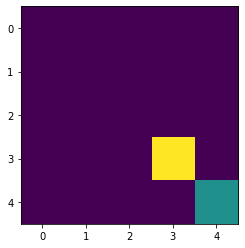

Action: Discrete(4)
Q_table: [[[ 2.54225915 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.39232849 -0.04208223]
  [ 0.36       -0.37002496  2.23247845 -0.13734526]
  [ 2.02000174  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.73207594 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.3941503  -0.5904    ]
  [ 0.         -0.2         0

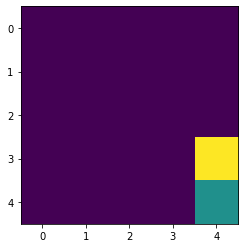

Action: Discrete(4)
Q_table: [[[ 2.54225915 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.39232849 -0.04208223]
  [ 0.36       -0.37002496  2.23247845 -0.13734526]
  [ 2.02000174  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.73207594 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.3941503  -0.5904    ]
  [ 0.         -0.2         1

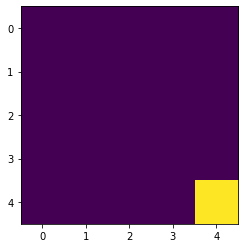

Round 22
Action: Discrete(4)
Q_table: [[[ 2.54225915 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.39232849 -0.04208223]
  [ 0.36       -0.37002496  2.23247845 -0.13734526]
  [ 2.02000174  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.73207594 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.3941503  -0.5904    ]
  [ 0.         -0.2 

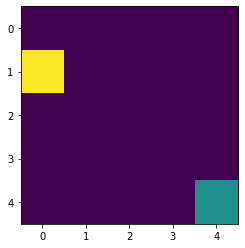

Action: Discrete(4)
Q_table: [[[ 2.61657988 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.39232849 -0.04208223]
  [ 0.36       -0.37002496  2.23247845 -0.13734526]
  [ 2.02000174  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.73207594 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.3941503  -0.5904    ]
  [ 0.         -0.2         1

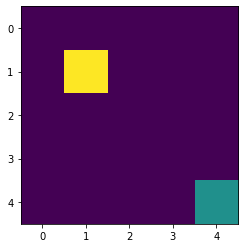

Action: Discrete(4)
Q_table: [[[ 2.61657988 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.47105935 -0.04208223]
  [ 0.36       -0.37002496  2.23247845 -0.13734526]
  [ 2.02000174  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.73207594 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.3941503  -0.5904    ]
  [ 0.         -0.2         1

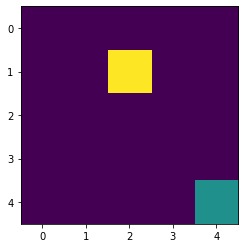

Action: Discrete(4)
Q_table: [[[ 2.61657988 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.47105935 -0.04208223]
  [ 0.36       -0.37002496  2.30918303 -0.13734526]
  [ 2.02000174  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.73207594 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.3941503  -0.5904    ]
  [ 0.         -0.2         1

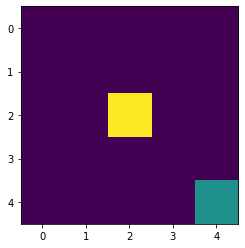

Action: Discrete(4)
Q_table: [[[ 2.61657988 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.47105935 -0.04208223]
  [ 0.36       -0.37002496  2.30918303 -0.13734526]
  [ 2.09313354  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.73207594 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.3941503  -0.5904    ]
  [ 0.         -0.2         1

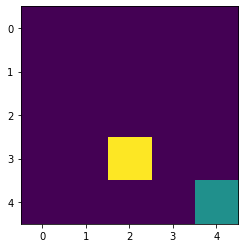

Action: Discrete(4)
Q_table: [[[ 2.61657988 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.47105935 -0.04208223]
  [ 0.36       -0.37002496  2.30918303 -0.13734526]
  [ 2.09313354  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.8087248  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.3941503  -0.5904    ]
  [ 0.         -0.2         1

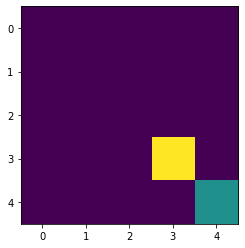

Action: Discrete(4)
Q_table: [[[ 2.61657988 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.47105935 -0.04208223]
  [ 0.36       -0.37002496  2.30918303 -0.13734526]
  [ 2.09313354  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.8087248  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.48210485 -0.5904    ]
  [ 0.         -0.2         1

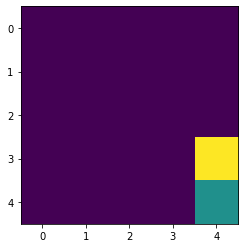

Action: Discrete(4)
Q_table: [[[ 2.61657988 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.47105935 -0.04208223]
  [ 0.36       -0.37002496  2.30918303 -0.13734526]
  [ 2.09313354  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.8087248  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.48210485 -0.5904    ]
  [ 0.         -0.2         1

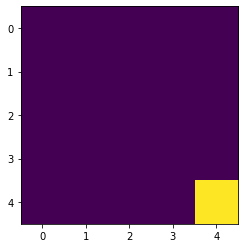

Round 23
Action: Discrete(4)
Q_table: [[[ 2.61657988 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.47105935 -0.04208223]
  [ 0.36       -0.37002496  2.30918303 -0.13734526]
  [ 2.09313354  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.8087248  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.48210485 -0.5904    ]
  [ 0.         -0.2 

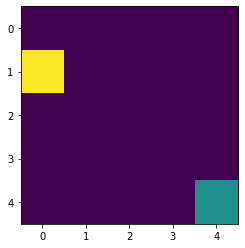

Action: Discrete(4)
Q_table: [[[ 2.6886334  -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.47105935 -0.04208223]
  [ 0.36       -0.37002496  2.30918303 -0.13734526]
  [ 2.09313354  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.8087248  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.48210485 -0.5904    ]
  [ 0.         -0.2         1

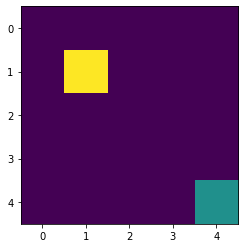

Action: Discrete(4)
Q_table: [[[ 2.6886334  -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.54631676 -0.04208223]
  [ 0.36       -0.37002496  2.30918303 -0.13734526]
  [ 2.09313354  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.8087248  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.48210485 -0.5904    ]
  [ 0.         -0.2         1

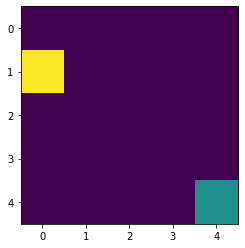

Action: Discrete(4)
Q_table: [[[ 2.6886334  -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.54631676 -0.04208223]
  [ 0.36       -0.37002496  2.30918303  0.09753448]
  [ 2.09313354  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.8087248  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.48210485 -0.5904    ]
  [ 0.         -0.2         1

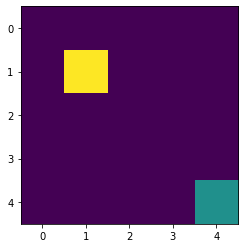

Action: Discrete(4)
Q_table: [[[ 2.6886334  -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.6065227  -0.04208223]
  [ 0.36       -0.37002496  2.30918303  0.09753448]
  [ 2.09313354  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.8087248  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.48210485 -0.5904    ]
  [ 0.         -0.2         1

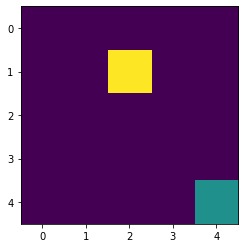

Action: Discrete(4)
Q_table: [[[ 2.6886334  -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.6065227  -0.04208223]
  [ 0.36       -0.37002496  2.38224779  0.09753448]
  [ 2.09313354  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.8087248  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.48210485 -0.5904    ]
  [ 0.         -0.2         1

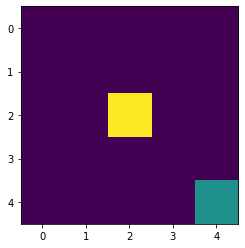

Action: Discrete(4)
Q_table: [[[ 2.6886334  -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.6065227  -0.04208223]
  [ 0.36       -0.37002496  2.38224779  0.09753448]
  [ 2.1639028   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.8087248  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.48210485 -0.5904    ]
  [ 0.         -0.2         1

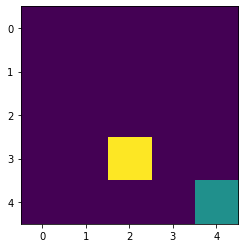

Action: Discrete(4)
Q_table: [[[ 2.6886334  -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.6065227  -0.04208223]
  [ 0.36       -0.37002496  2.38224779  0.09753448]
  [ 2.1639028   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.88411662 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.48210485 -0.5904    ]
  [ 0.         -0.2         1

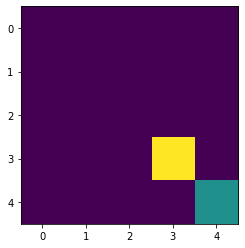

Action: Discrete(4)
Q_table: [[[ 2.6886334  -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.6065227  -0.04208223]
  [ 0.36       -0.37002496  2.38224779  0.09753448]
  [ 2.1639028   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.88411662 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.56832297 -0.5904    ]
  [ 0.         -0.2         1

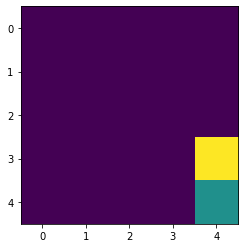

Round 24
Action: Discrete(4)
Q_table: [[[ 2.6886334  -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.6065227  -0.04208223]
  [ 0.36       -0.37002496  2.38224779  0.09753448]
  [ 2.1639028   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.88411662 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.56832297 -0.5904    ]
  [ 0.         -0.2 

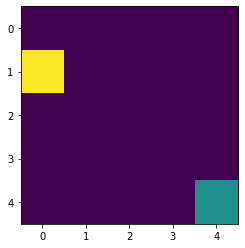

Action: Discrete(4)
Q_table: [[[ 2.76795035 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.6065227  -0.04208223]
  [ 0.36       -0.37002496  2.38224779  0.09753448]
  [ 2.1639028   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.88411662 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.56832297 -0.5904    ]
  [ 0.         -0.2         1

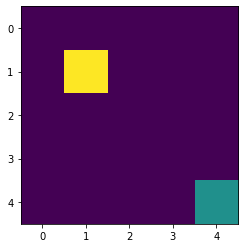

Action: Discrete(4)
Q_table: [[[ 2.76795035 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.6663778  -0.04208223]
  [ 0.36       -0.37002496  2.38224779  0.09753448]
  [ 2.1639028   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.88411662 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.56832297 -0.5904    ]
  [ 0.         -0.2         1

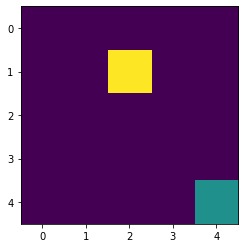

Action: Discrete(4)
Q_table: [[[ 2.76795035 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.6663778  -0.04208223]
  [ 0.36       -0.37002496  2.45202268  0.09753448]
  [ 2.1639028   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.88411662 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.56832297 -0.5904    ]
  [ 0.         -0.2         1

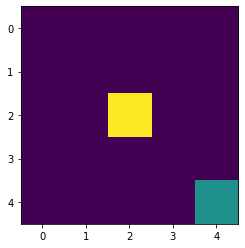

Action: Discrete(4)
Q_table: [[[ 2.76795035 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.6663778  -0.04208223]
  [ 0.36       -0.37002496  2.45202268  0.09753448]
  [ 2.2325809   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.88411662 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.56832297 -0.5904    ]
  [ 0.         -0.2         1

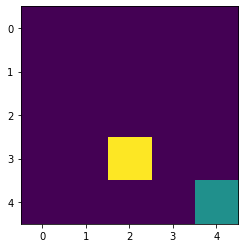

Action: Discrete(4)
Q_table: [[[ 2.76795035 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.6663778  -0.04208223]
  [ 0.36       -0.37002496  2.45202268  0.09753448]
  [ 2.2325809   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.95822497 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.56832297 -0.5904    ]
  [ 0.         -0.2         1

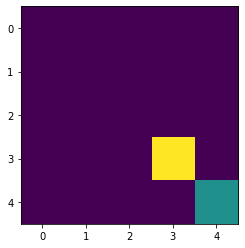

Action: Discrete(4)
Q_table: [[[ 2.76795035 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.6663778  -0.04208223]
  [ 0.36       -0.37002496  2.45202268  0.09753448]
  [ 2.2325809   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.95822497 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.65165875 -0.5904    ]
  [ 0.         -0.2         1

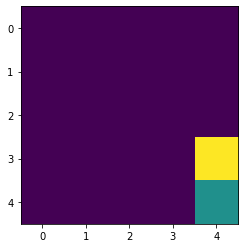

Action: Discrete(4)
Q_table: [[[ 2.76795035 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.6663778  -0.04208223]
  [ 0.36       -0.37002496  2.45202268  0.09753448]
  [ 2.2325809   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.95822497 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.65165875 -0.5904    ]
  [ 0.         -0.2         1

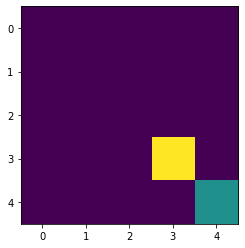

Action: Discrete(4)
Q_table: [[[ 2.76795035 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.6663778  -0.04208223]
  [ 0.36       -0.37002496  2.45202268  0.09753448]
  [ 2.2325809   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.95822497 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.65165875 -0.5904    ]
  [ 0.         -0.2         1

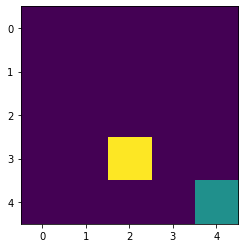

Round 25
Action: Discrete(4)
Q_table: [[[ 2.76795035 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.6663778  -0.04208223]
  [ 0.36       -0.37002496  2.45202268  0.09753448]
  [ 2.2325809   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.95822497 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.65165875 -0.5904    ]
  [ 0.         -0.2 

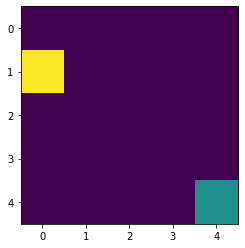

Action: Discrete(4)
Q_table: [[[ 2.84098073 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.6663778  -0.04208223]
  [ 0.36       -0.37002496  2.45202268  0.09753448]
  [ 2.2325809   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.95822497 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.65165875 -0.5904    ]
  [ 0.         -0.2         1

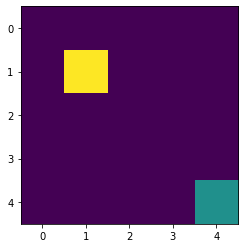

Action: Discrete(4)
Q_table: [[[ 2.84098073 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.72542587 -0.04208223]
  [ 0.36       -0.37002496  2.45202268  0.09753448]
  [ 2.2325809   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.95822497 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.65165875 -0.5904    ]
  [ 0.         -0.2         1

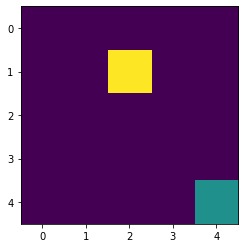

Action: Discrete(4)
Q_table: [[[ 2.84098073 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.72542587 -0.04208223]
  [ 0.36       -0.37002496  2.51883109  0.09753448]
  [ 2.2325809   0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.95822497 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.65165875 -0.5904    ]
  [ 0.         -0.2         1

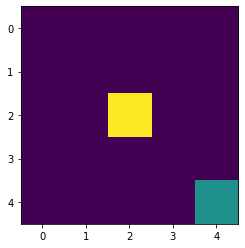

Action: Discrete(4)
Q_table: [[[ 2.84098073 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.72542587 -0.04208223]
  [ 0.36       -0.37002496  2.51883109  0.09753448]
  [ 2.29938072  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 1.95822497 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.65165875 -0.5904    ]
  [ 0.         -0.2         1

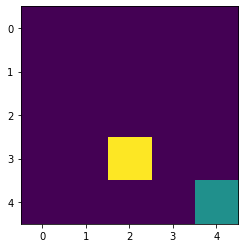

Action: Discrete(4)
Q_table: [[[ 2.84098073 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.72542587 -0.04208223]
  [ 0.36       -0.37002496  2.51883109  0.09753448]
  [ 2.29938072  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.03084538 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.65165875 -0.5904    ]
  [ 0.         -0.2         1

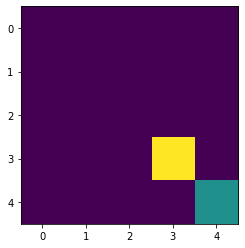

Action: Discrete(4)
Q_table: [[[ 2.84098073 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.72542587 -0.04208223]
  [ 0.36       -0.37002496  2.51883109  0.09753448]
  [ 2.29938072  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.03084538 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.72981642 -0.5904    ]
  [ 0.         -0.2         1

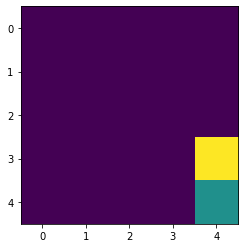

Action: Discrete(4)
Q_table: [[[ 2.84098073 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.72542587 -0.04208223]
  [ 0.36       -0.37002496  2.51883109  0.09753448]
  [ 2.29938072  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.03084538 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.72981642 -0.5904    ]
  [ 0.         -0.2         1

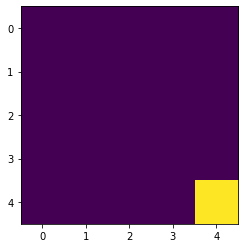

Round 26
Action: Discrete(4)
Q_table: [[[ 2.84098073 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.72542587 -0.04208223]
  [ 0.36       -0.37002496  2.51883109  0.09753448]
  [ 2.29938072  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.03084538 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.72981642 -0.5904    ]
  [ 0.         -0.2 

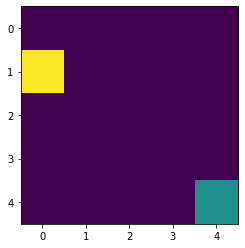

Action: Discrete(4)
Q_table: [[[ 2.90885272 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.72542587 -0.04208223]
  [ 0.36       -0.37002496  2.51883109  0.09753448]
  [ 2.29938072  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.03084538 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.72981642 -0.5904    ]
  [ 0.         -0.2         1

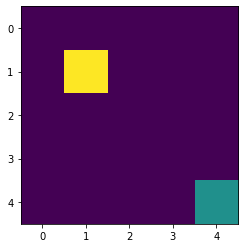

Action: Discrete(4)
Q_table: [[[ 2.90885272 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.78335367 -0.04208223]
  [ 0.36       -0.37002496  2.51883109  0.09753448]
  [ 2.29938072  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.03084538 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.72981642 -0.5904    ]
  [ 0.         -0.2         1

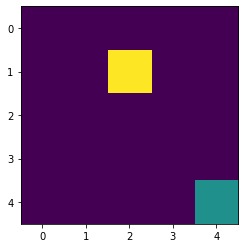

Action: Discrete(4)
Q_table: [[[ 2.90885272 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.78335367 -0.04208223]
  [ 0.36       -0.37002496  2.58296579  0.09753448]
  [ 2.29938072  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.03084538 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.72981642 -0.5904    ]
  [ 0.         -0.2         1

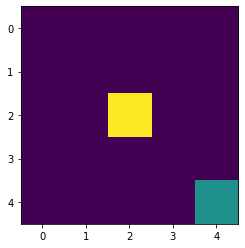

Action: Discrete(4)
Q_table: [[[ 2.90885272 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.78335367 -0.04208223]
  [ 0.36       -0.37002496  2.58296579  0.09753448]
  [ 2.36443983  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.03084538 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.72981642 -0.5904    ]
  [ 0.         -0.2         1

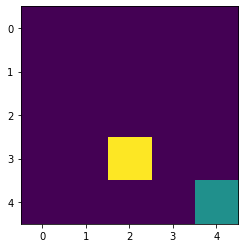

Action: Discrete(4)
Q_table: [[[ 2.90885272 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.78335367 -0.04208223]
  [ 0.36       -0.37002496  2.58296579  0.09753448]
  [ 2.36443983  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.10144693 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.72981642 -0.5904    ]
  [ 0.         -0.2         1

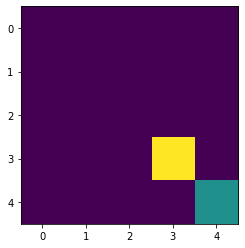

Action: Discrete(4)
Q_table: [[[ 2.90885272 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.78335367 -0.04208223]
  [ 0.36       -0.37002496  2.58296579  0.09753448]
  [ 2.36443983  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.10144693 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.80153378 -0.5904    ]
  [ 0.         -0.2         1

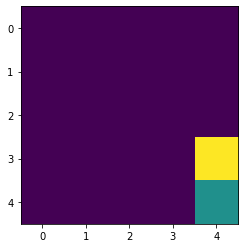

Action: Discrete(4)
Q_table: [[[ 2.90885272 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.78335367 -0.04208223]
  [ 0.36       -0.37002496  2.58296579  0.09753448]
  [ 2.36443983  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.10144693 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.80153378 -0.5904    ]
  [ 0.         -0.2         1

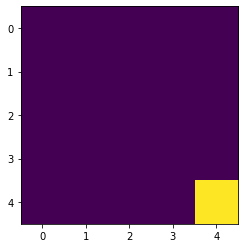

Round 27
Action: Discrete(4)
Q_table: [[[ 2.90885272 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.78335367 -0.04208223]
  [ 0.36       -0.37002496  2.58296579  0.09753448]
  [ 2.36443983  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.10144693 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.80153378 -0.5904    ]
  [ 0.         -0.2 

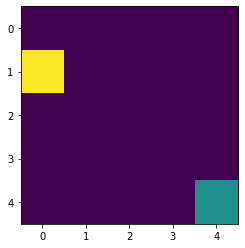

Action: Discrete(4)
Q_table: [[[ 2.97241877 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.78335367 -0.04208223]
  [ 0.36       -0.37002496  2.58296579  0.09753448]
  [ 2.36443983  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.10144693 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.80153378 -0.5904    ]
  [ 0.         -0.2         1

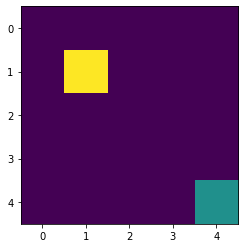

Action: Discrete(4)
Q_table: [[[ 2.97241877 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.83995746 -0.04208223]
  [ 0.36       -0.37002496  2.58296579  0.09753448]
  [ 2.36443983  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.10144693 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.80153378 -0.5904    ]
  [ 0.         -0.2         1

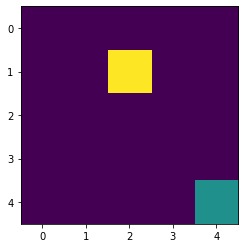

Action: Discrete(4)
Q_table: [[[ 2.97241877 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.83995746 -0.04208223]
  [ 0.36       -0.37002496  2.644683    0.09753448]
  [ 2.36443983  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.10144693 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.80153378 -0.5904    ]
  [ 0.         -0.2         1

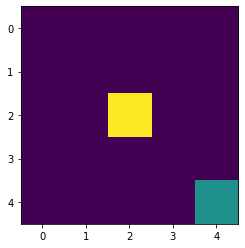

Action: Discrete(4)
Q_table: [[[ 2.97241877 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.83995746 -0.04208223]
  [ 0.36       -0.37002496  2.644683    0.09753448]
  [ 2.42778338  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.10144693 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.80153378 -0.5904    ]
  [ 0.         -0.2         1

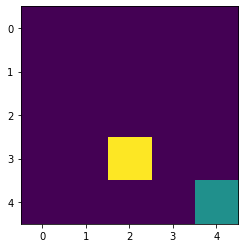

Action: Discrete(4)
Q_table: [[[ 2.97241877 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.83995746 -0.04208223]
  [ 0.36       -0.37002496  2.644683    0.09753448]
  [ 2.42778338  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.16940295 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.80153378 -0.5904    ]
  [ 0.         -0.2         1

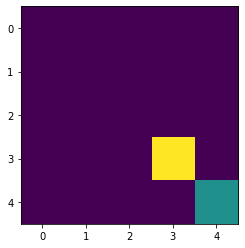

Action: Discrete(4)
Q_table: [[[ 2.97241877 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.83995746 -0.04208223]
  [ 0.36       -0.37002496  2.644683    0.09753448]
  [ 2.42778338  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.16940295 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.86760284 -0.5904    ]
  [ 0.         -0.2         1

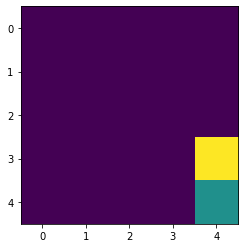

Action: Discrete(4)
Q_table: [[[ 2.97241877 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.83995746 -0.04208223]
  [ 0.36       -0.37002496  2.644683    0.09753448]
  [ 2.42778338  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.16940295 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.86760284 -0.5904    ]
  [ 0.         -0.2         1

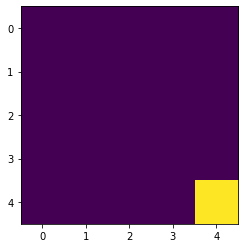

Round 28
Action: Discrete(4)
Q_table: [[[ 2.97241877 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.83995746 -0.04208223]
  [ 0.36       -0.37002496  2.644683    0.09753448]
  [ 2.42778338  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.16940295 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.86760284 -0.5904    ]
  [ 0.         -0.2 

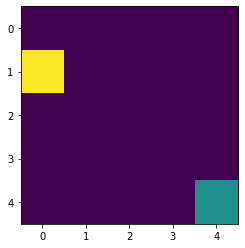

Action: Discrete(4)
Q_table: [[[ 3.03232821 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.83995746 -0.04208223]
  [ 0.36       -0.37002496  2.644683    0.09753448]
  [ 2.42778338  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.16940295 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.86760284 -0.5904    ]
  [ 0.         -0.2         1

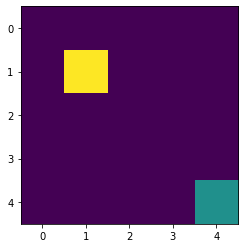

Action: Discrete(4)
Q_table: [[[ 3.03232821 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.89511525 -0.04208223]
  [ 0.36       -0.37002496  2.644683    0.09753448]
  [ 2.42778338  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.16940295 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.86760284 -0.5904    ]
  [ 0.         -0.2         1

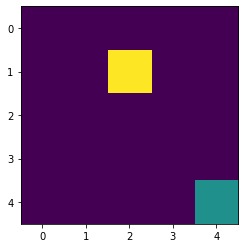

Action: Discrete(4)
Q_table: [[[ 3.03232821 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.89511525 -0.04208223]
  [ 0.36       -0.37002496  2.70419174  0.09753448]
  [ 2.42778338  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.16940295 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.86760284 -0.5904    ]
  [ 0.         -0.2         1

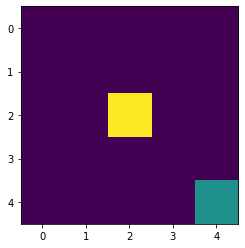

Action: Discrete(4)
Q_table: [[[ 3.03232821 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.89511525 -0.04208223]
  [ 0.36       -0.37002496  2.70419174  0.09753448]
  [ 2.48933117  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.16940295 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.86760284 -0.5904    ]
  [ 0.         -0.2         1

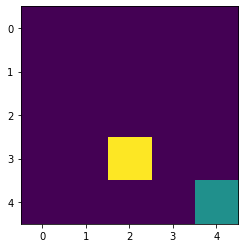

Action: Discrete(4)
Q_table: [[[ 3.03232821 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.89511525 -0.04208223]
  [ 0.36       -0.37002496  2.70419174  0.09753448]
  [ 2.48933117  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.23433881 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.86760284 -0.5904    ]
  [ 0.         -0.2         1

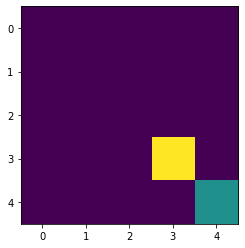

Action: Discrete(4)
Q_table: [[[ 3.03232821 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.89511525 -0.04208223]
  [ 0.36       -0.37002496  2.70419174  0.09753448]
  [ 2.48933117  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.23433881 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.92848795 -0.5904    ]
  [ 0.         -0.2         1

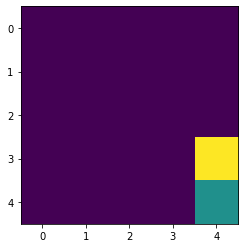

Action: Discrete(4)
Q_table: [[[ 3.03232821 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.89511525 -0.04208223]
  [ 0.36       -0.37002496  2.70419174  0.09753448]
  [ 2.48933117  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.23433881 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.92848795 -0.5904    ]
  [ 0.         -0.2         1

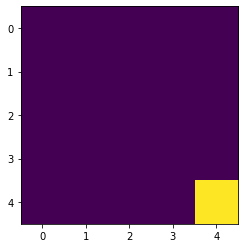

Round 29
Action: Discrete(4)
Q_table: [[[ 3.03232821 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.89511525 -0.04208223]
  [ 0.36       -0.37002496  2.70419174  0.09753448]
  [ 2.48933117  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.23433881 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.92848795 -0.5904    ]
  [ 0.         -0.2 

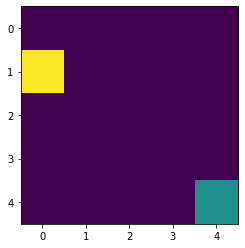

Action: Discrete(4)
Q_table: [[[ 3.08908101 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.89511525 -0.04208223]
  [ 0.36       -0.37002496  2.70419174  0.09753448]
  [ 2.48933117  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.23433881 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.92848795 -0.5904    ]
  [ 0.         -0.2         1

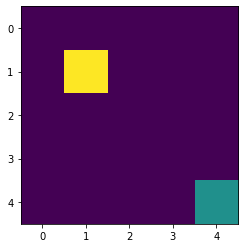

Action: Discrete(4)
Q_table: [[[ 3.08908101 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.94876288 -0.04208223]
  [ 0.36       -0.37002496  2.70419174  0.09753448]
  [ 2.48933117  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.23433881 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.92848795 -0.5904    ]
  [ 0.         -0.2         1

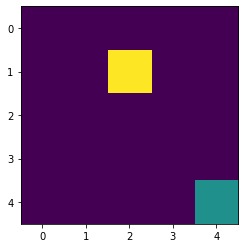

Action: Discrete(4)
Q_table: [[[ 3.08908101 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.94876288 -0.04208223]
  [ 0.36       -0.37002496  2.76164638  0.09753448]
  [ 2.48933117  0.          0.         -0.168     ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.23433881 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.92848795 -0.5904    ]
  [ 0.         -0.2         1

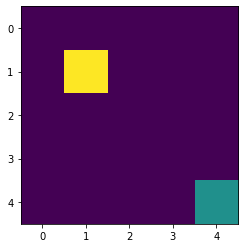

Action: Discrete(4)
Q_table: [[[ 3.08908101 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.94876288 -0.04208223]
  [ 0.36       -0.37002496  2.76164638  0.09753448]
  [ 2.48933117  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.23433881 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.92848795 -0.5904    ]
  [ 0.         -0.2         1

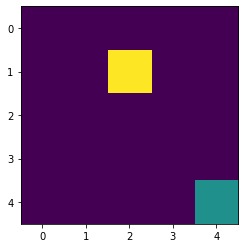

Action: Discrete(4)
Q_table: [[[ 3.08908101 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.94876288 -0.04208223]
  [ 0.36       -0.37002496  2.80761009  0.09753448]
  [ 2.48933117  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.23433881 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.92848795 -0.5904    ]
  [ 0.         -0.2         1

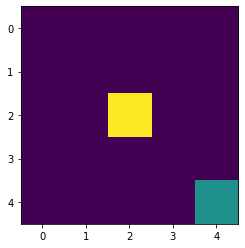

Action: Discrete(4)
Q_table: [[[ 3.08908101 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.94876288 -0.04208223]
  [ 0.36       -0.37002496  2.80761009  0.09753448]
  [ 2.54895915  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.23433881 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.92848795 -0.5904    ]
  [ 0.         -0.2         1

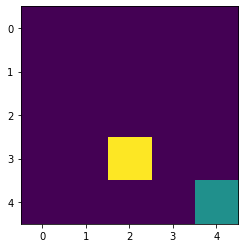

Action: Discrete(4)
Q_table: [[[ 3.08908101 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.94876288 -0.04208223]
  [ 0.36       -0.37002496  2.80761009  0.09753448]
  [ 2.54895915  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.29602912 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.92848795 -0.5904    ]
  [ 0.         -0.2         1

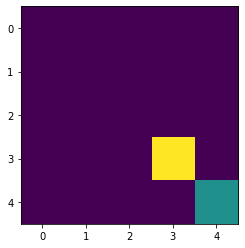

Action: Discrete(4)
Q_table: [[[ 3.08908101 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.94876288 -0.04208223]
  [ 0.36       -0.37002496  2.80761009  0.09753448]
  [ 2.54895915  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.29602912 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.98447893 -0.5904    ]
  [ 0.         -0.2         1

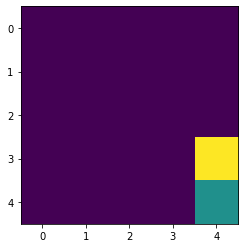

Round 30
Action: Discrete(4)
Q_table: [[[ 3.08908101 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.94876288 -0.04208223]
  [ 0.36       -0.37002496  2.80761009  0.09753448]
  [ 2.54895915  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.29602912 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.98447893 -0.5904    ]
  [ 0.         -0.2 

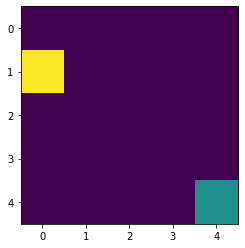

Action: Discrete(4)
Q_table: [[[ 3.14306687 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  2.94876288 -0.04208223]
  [ 0.36       -0.37002496  2.80761009  0.09753448]
  [ 2.54895915  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.29602912 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.98447893 -0.5904    ]
  [ 0.         -0.2         1

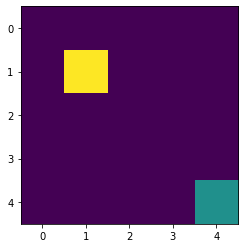

Action: Discrete(4)
Q_table: [[[ 3.14306687 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.00822792 -0.04208223]
  [ 0.36       -0.37002496  2.80761009  0.09753448]
  [ 2.54895915  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.29602912 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.98447893 -0.5904    ]
  [ 0.         -0.2         1

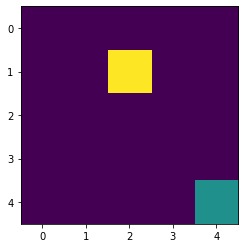

Action: Discrete(4)
Q_table: [[[ 3.14306687 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.00822792 -0.04208223]
  [ 0.36       -0.37002496  2.85392154  0.09753448]
  [ 2.54895915  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.29602912 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.98447893 -0.5904    ]
  [ 0.         -0.2         1

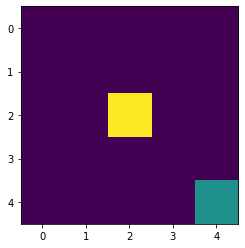

Action: Discrete(4)
Q_table: [[[ 3.14306687 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.00822792 -0.04208223]
  [ 0.36       -0.37002496  2.85392154  0.09753448]
  [ 2.60653198  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.29602912 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.98447893 -0.5904    ]
  [ 0.         -0.2         1

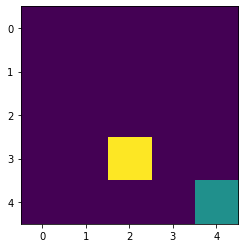

Action: Discrete(4)
Q_table: [[[ 3.14306687 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.00822792 -0.04208223]
  [ 0.36       -0.37002496  2.85392154  0.09753448]
  [ 2.60653198  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.35433993 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     1.98447893 -0.5904    ]
  [ 0.         -0.2         1

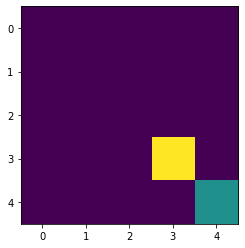

Action: Discrete(4)
Q_table: [[[ 3.14306687 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.00822792 -0.04208223]
  [ 0.36       -0.37002496  2.85392154  0.09753448]
  [ 2.60653198  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.35433993 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.03578522 -0.5904    ]
  [ 0.         -0.2         1

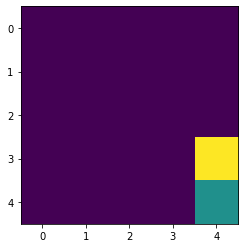

Action: Discrete(4)
Q_table: [[[ 3.14306687 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.00822792 -0.04208223]
  [ 0.36       -0.37002496  2.85392154  0.09753448]
  [ 2.60653198  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.35433993 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.03578522 -0.5904    ]
  [ 0.         -0.2         1

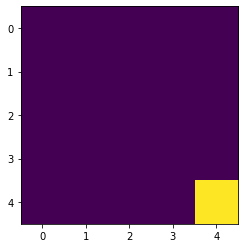

Round 31
Action: Discrete(4)
Q_table: [[[ 3.14306687 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.00822792 -0.04208223]
  [ 0.36       -0.37002496  2.85392154  0.09753448]
  [ 2.60653198  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.35433993 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.03578522 -0.5904    ]
  [ 0.         -0.2 

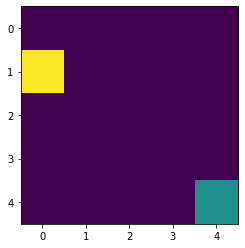

Action: Discrete(4)
Q_table: [[[ 3.19576996 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.00822792 -0.04208223]
  [ 0.36       -0.37002496  2.85392154  0.09753448]
  [ 2.60653198  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.35433993 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.03578522 -0.5904    ]
  [ 0.         -0.2         1

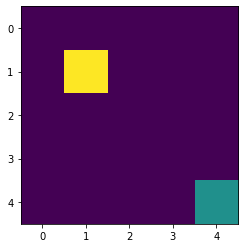

Action: Discrete(4)
Q_table: [[[ 3.19576996 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.06320978 -0.04208223]
  [ 0.36       -0.37002496  2.85392154  0.09753448]
  [ 2.60653198  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.35433993 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.03578522 -0.5904    ]
  [ 0.         -0.2         1

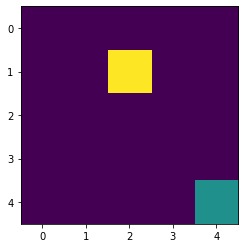

Action: Discrete(4)
Q_table: [[[ 3.19576996 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.06320978 -0.04208223]
  [ 0.36       -0.37002496  2.90018235  0.09753448]
  [ 2.60653198  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.35433993 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.03578522 -0.5904    ]
  [ 0.         -0.2         1

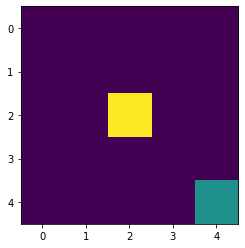

Action: Discrete(4)
Q_table: [[[ 3.19576996 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.06320978 -0.04208223]
  [ 0.36       -0.37002496  2.90018235  0.09753448]
  [ 2.66191997  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.35433993 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.03578522 -0.5904    ]
  [ 0.         -0.2         1

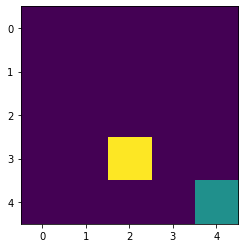

Action: Discrete(4)
Q_table: [[[ 3.19576996 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.06320978 -0.04208223]
  [ 0.36       -0.37002496  2.90018235  0.09753448]
  [ 2.66191997  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.40919758 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.03578522 -0.5904    ]
  [ 0.         -0.2         1

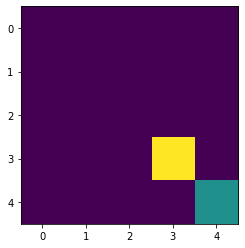

Action: Discrete(4)
Q_table: [[[ 3.19576996 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.06320978 -0.04208223]
  [ 0.36       -0.37002496  2.90018235  0.09753448]
  [ 2.66191997  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.40919758 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.08204106 -0.5904    ]
  [ 0.         -0.2         1

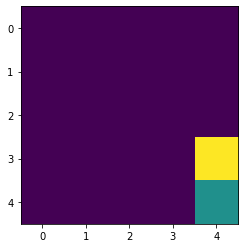

Action: Discrete(4)
Q_table: [[[ 3.19576996 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.06320978 -0.04208223]
  [ 0.36       -0.37002496  2.90018235  0.09753448]
  [ 2.66191997  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.40919758 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.08204106 -0.5904    ]
  [ 0.         -0.2         1

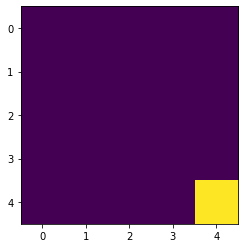

Round 32
Action: Discrete(4)
Q_table: [[[ 3.19576996 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.06320978 -0.04208223]
  [ 0.36       -0.37002496  2.90018235  0.09753448]
  [ 2.66191997  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.40919758 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.08204106 -0.5904    ]
  [ 0.         -0.2 

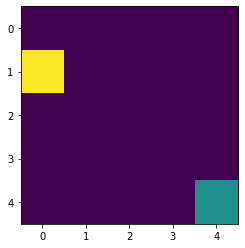

Action: Discrete(4)
Q_table: [[[ 3.24672953 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.06320978 -0.04208223]
  [ 0.36       -0.37002496  2.90018235  0.09753448]
  [ 2.66191997  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.40919758 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.08204106 -0.5904    ]
  [ 0.         -0.2         1

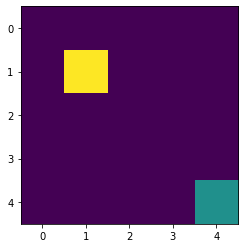

Action: Discrete(4)
Q_table: [[[ 3.24672953 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.114597   -0.04208223]
  [ 0.36       -0.37002496  2.90018235  0.09753448]
  [ 2.66191997  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.40919758 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.08204106 -0.5904    ]
  [ 0.         -0.2         1

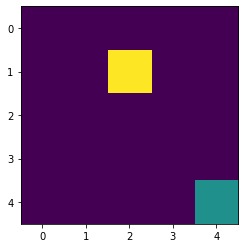

Action: Discrete(4)
Q_table: [[[ 3.24672953 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.114597   -0.04208223]
  [ 0.36       -0.37002496  2.94605307  0.09753448]
  [ 2.66191997  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.40919758 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.08204106 -0.5904    ]
  [ 0.         -0.2         1

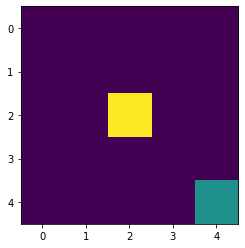

Action: Discrete(4)
Q_table: [[[ 3.24672953 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.114597   -0.04208223]
  [ 0.36       -0.37002496  2.94605307  0.09753448]
  [ 2.71500759  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.40919758 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.08204106 -0.5904    ]
  [ 0.         -0.2         1

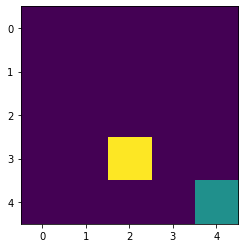

Action: Discrete(4)
Q_table: [[[ 3.24672953 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.114597   -0.04208223]
  [ 0.36       -0.37002496  2.94605307  0.09753448]
  [ 2.71500759  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.46048463 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.08204106 -0.5904    ]
  [ 0.         -0.2         1

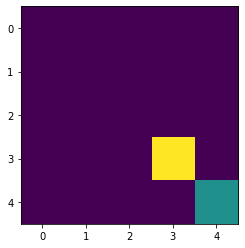

Action: Discrete(4)
Q_table: [[[ 3.24672953 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.114597   -0.04208223]
  [ 0.36       -0.37002496  2.94605307  0.09753448]
  [ 2.71500759  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.46048463 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.12376413 -0.5904    ]
  [ 0.         -0.2         1

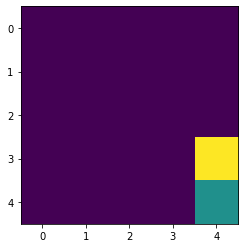

Action: Discrete(4)
Q_table: [[[ 3.24672953 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.114597   -0.04208223]
  [ 0.36       -0.37002496  2.94605307  0.09753448]
  [ 2.71500759  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.46048463 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.12376413 -0.5904    ]
  [ 0.         -0.2         1

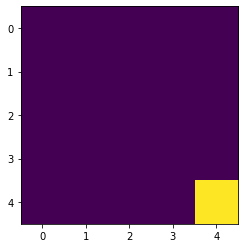

Round 33
Action: Discrete(4)
Q_table: [[[ 3.24672953 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.114597   -0.04208223]
  [ 0.36       -0.37002496  2.94605307  0.09753448]
  [ 2.71500759  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.46048463 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.12376413 -0.5904    ]
  [ 0.         -0.2 

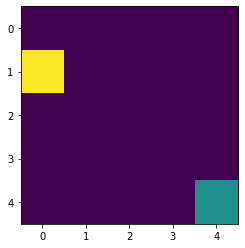

Action: Discrete(4)
Q_table: [[[ 3.29571915 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.114597   -0.04208223]
  [ 0.36       -0.37002496  2.94605307  0.09753448]
  [ 2.71500759  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.46048463 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.12376413 -0.5904    ]
  [ 0.         -0.2         1

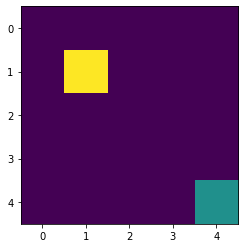

Action: Discrete(4)
Q_table: [[[ 3.29571915 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.16304609 -0.04208223]
  [ 0.36       -0.37002496  2.94605307  0.09753448]
  [ 2.71500759  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.46048463 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.12376413 -0.5904    ]
  [ 0.         -0.2         1

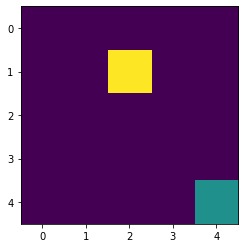

Action: Discrete(4)
Q_table: [[[ 3.29571915 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.16304609 -0.04208223]
  [ 0.36       -0.37002496  2.99124367  0.09753448]
  [ 2.71500759  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.46048463 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.12376413 -0.5904    ]
  [ 0.         -0.2         1

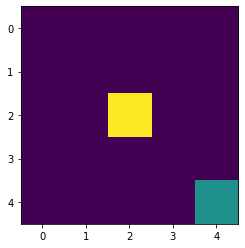

Action: Discrete(4)
Q_table: [[[ 3.29571915 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.16304609 -0.04208223]
  [ 0.36       -0.37002496  2.99124367  0.09753448]
  [ 2.76568361  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.46048463 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.12376413 -0.5904    ]
  [ 0.         -0.2         1

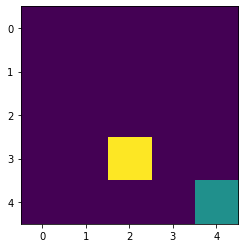

Action: Discrete(4)
Q_table: [[[ 3.29571915 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.16304609 -0.04208223]
  [ 0.36       -0.37002496  2.99124367  0.09753448]
  [ 2.76568361  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.50818997 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.12376413 -0.5904    ]
  [ 0.         -0.2         1

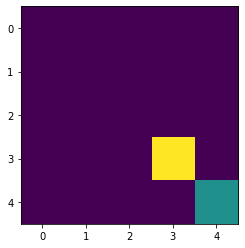

Action: Discrete(4)
Q_table: [[[ 3.29571915 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.16304609 -0.04208223]
  [ 0.36       -0.37002496  2.99124367  0.09753448]
  [ 2.76568361  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.50818997 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.16135711 -0.5904    ]
  [ 0.         -0.2         1

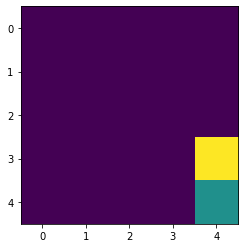

Action: Discrete(4)
Q_table: [[[ 3.29571915 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.16304609 -0.04208223]
  [ 0.36       -0.37002496  2.99124367  0.09753448]
  [ 2.76568361  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.50818997 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.16135711 -0.5904    ]
  [ 0.         -0.2         1

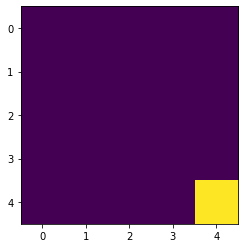

Round 34
Action: Discrete(4)
Q_table: [[[ 3.29571915 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.16304609 -0.04208223]
  [ 0.36       -0.37002496  2.99124367  0.09753448]
  [ 2.76568361  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.50818997 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.16135711 -0.5904    ]
  [ 0.         -0.2 

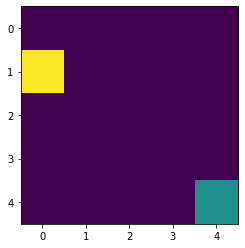

Action: Discrete(4)
Q_table: [[[ 3.34266269 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.16304609 -0.04208223]
  [ 0.36       -0.37002496  2.99124367  0.09753448]
  [ 2.76568361  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.50818997 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.16135711 -0.5904    ]
  [ 0.         -0.2         1

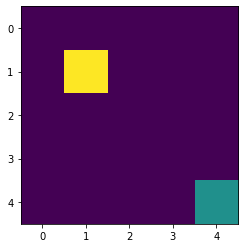

Action: Discrete(4)
Q_table: [[[ 3.34266269 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.20903586 -0.04208223]
  [ 0.36       -0.37002496  2.99124367  0.09753448]
  [ 2.76568361  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.50818997 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.16135711 -0.5904    ]
  [ 0.         -0.2         1

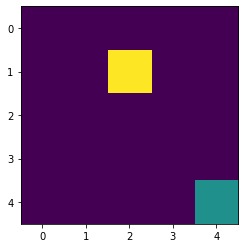

Action: Discrete(4)
Q_table: [[[ 3.34266269 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.20903586 -0.04208223]
  [ 0.36       -0.37002496  3.03550432  0.09753448]
  [ 2.76568361  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.50818997 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.16135711 -0.5904    ]
  [ 0.         -0.2         1

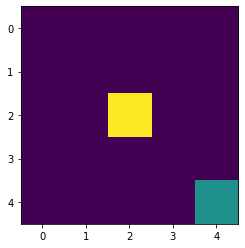

Action: Discrete(4)
Q_table: [[[ 3.34266269 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.20903586 -0.04208223]
  [ 0.36       -0.37002496  3.03550432  0.09753448]
  [ 2.81385728  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.50818997 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.16135711 -0.5904    ]
  [ 0.         -0.2         1

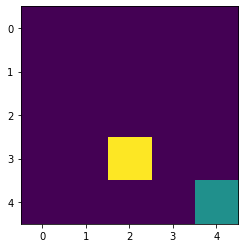

Action: Discrete(4)
Q_table: [[[ 3.34266269 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.20903586 -0.04208223]
  [ 0.36       -0.37002496  3.03550432  0.09753448]
  [ 2.81385728  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.55236911 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.16135711 -0.5904    ]
  [ 0.         -0.2         1

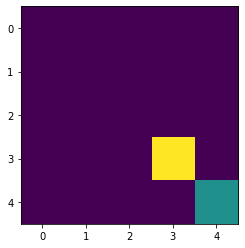

Action: Discrete(4)
Q_table: [[[ 3.34266269 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.20903586 -0.04208223]
  [ 0.36       -0.37002496  3.03550432  0.09753448]
  [ 2.81385728  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.55236911 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.19515496 -0.5904    ]
  [ 0.         -0.2         1

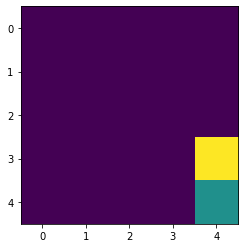

Action: Discrete(4)
Q_table: [[[ 3.34266269 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.20903586 -0.04208223]
  [ 0.36       -0.37002496  3.03550432  0.09753448]
  [ 2.81385728  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.55236911 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.19515496 -0.5904    ]
  [ 0.         -0.2         1

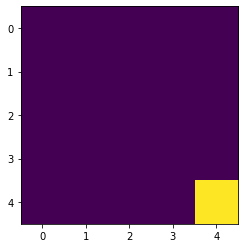

Round 35
Action: Discrete(4)
Q_table: [[[ 3.34266269 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.20903586 -0.04208223]
  [ 0.36       -0.37002496  3.03550432  0.09753448]
  [ 2.81385728  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.55236911 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.19515496 -0.5904    ]
  [ 0.         -0.2 

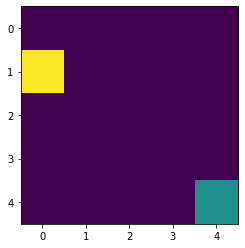

Action: Discrete(4)
Q_table: [[[ 3.38757589 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.20903586 -0.04208223]
  [ 0.36       -0.37002496  3.03550432  0.09753448]
  [ 2.81385728  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.55236911 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.19515496 -0.5904    ]
  [ 0.         -0.2         1

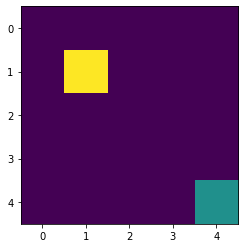

Action: Discrete(4)
Q_table: [[[ 3.38757589 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.25290938 -0.04208223]
  [ 0.36       -0.37002496  3.03550432  0.09753448]
  [ 2.81385728  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.55236911 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.19515496 -0.5904    ]
  [ 0.         -0.2         1

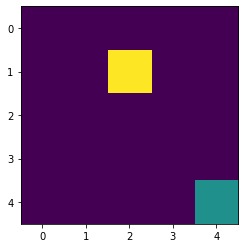

Action: Discrete(4)
Q_table: [[[ 3.38757589 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.25290938 -0.04208223]
  [ 0.36       -0.37002496  3.07862062  0.09753448]
  [ 2.81385728  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.55236911 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.19515496 -0.5904    ]
  [ 0.         -0.2         1

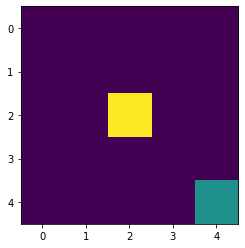

Action: Discrete(4)
Q_table: [[[ 3.38757589 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.25290938 -0.04208223]
  [ 0.36       -0.37002496  3.07862062  0.09753448]
  [ 2.85946488  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.55236911 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.19515496 -0.5904    ]
  [ 0.         -0.2         1

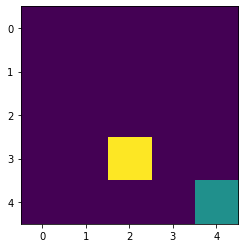

Action: Discrete(4)
Q_table: [[[ 3.38757589 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.25290938 -0.04208223]
  [ 0.36       -0.37002496  3.07862062  0.09753448]
  [ 2.85946488  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.59312008 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.19515496 -0.5904    ]
  [ 0.         -0.2         1

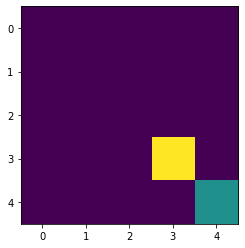

Action: Discrete(4)
Q_table: [[[ 3.38757589 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.25290938 -0.04208223]
  [ 0.36       -0.37002496  3.07862062  0.09753448]
  [ 2.85946488  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.59312008 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.22545349 -0.5904    ]
  [ 0.         -0.2         1

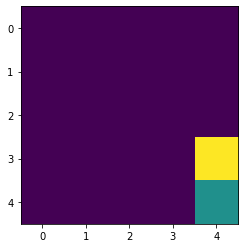

Action: Discrete(4)
Q_table: [[[ 3.38757589 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.25290938 -0.04208223]
  [ 0.36       -0.37002496  3.07862062  0.09753448]
  [ 2.85946488  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.59312008 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.22545349 -0.5904    ]
  [ 0.         -0.2         1

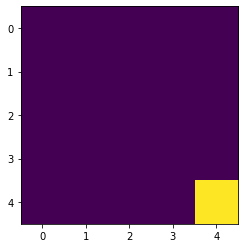

Round 36
Action: Discrete(4)
Q_table: [[[ 3.38757589 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.25290938 -0.04208223]
  [ 0.36       -0.37002496  3.07862062  0.09753448]
  [ 2.85946488  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.59312008 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.22545349 -0.5904    ]
  [ 0.         -0.2 

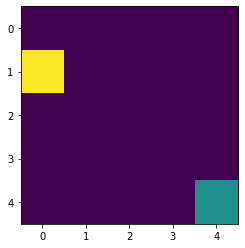

Action: Discrete(4)
Q_table: [[[ 3.43052621 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.25290938 -0.04208223]
  [ 0.36       -0.37002496  3.07862062  0.09753448]
  [ 2.85946488  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.59312008 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.22545349 -0.5904    ]
  [ 0.         -0.2         1

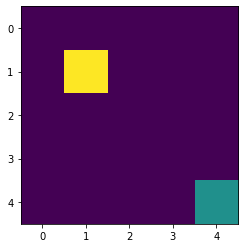

Action: Discrete(4)
Q_table: [[[ 3.43052621 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.2949068  -0.04208223]
  [ 0.36       -0.37002496  3.07862062  0.09753448]
  [ 2.85946488  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.59312008 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.22545349 -0.5904    ]
  [ 0.         -0.2         1

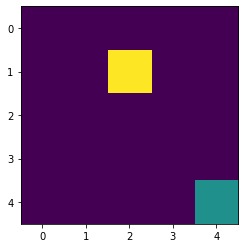

Action: Discrete(4)
Q_table: [[[ 3.43052621 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.2949068  -0.04208223]
  [ 0.36       -0.37002496  3.12041088  0.09753448]
  [ 2.85946488  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.59312008 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.22545349 -0.5904    ]
  [ 0.         -0.2         1

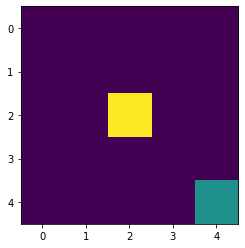

Action: Discrete(4)
Q_table: [[[ 3.43052621 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.2949068  -0.04208223]
  [ 0.36       -0.37002496  3.12041088  0.09753448]
  [ 2.90247112  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.59312008 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.22545349 -0.5904    ]
  [ 0.         -0.2         1

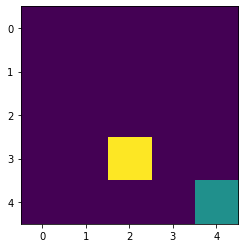

Action: Discrete(4)
Q_table: [[[ 3.43052621 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.2949068  -0.04208223]
  [ 0.36       -0.37002496  3.12041088  0.09753448]
  [ 2.90247112  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.63056862 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.22545349 -0.5904    ]
  [ 0.         -0.2         1

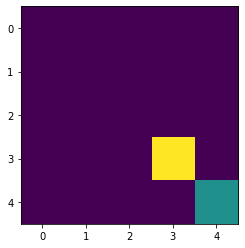

Action: Discrete(4)
Q_table: [[[ 3.43052621 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.2949068  -0.04208223]
  [ 0.36       -0.37002496  3.12041088  0.09753448]
  [ 2.90247112  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.63056862 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.25252568 -0.5904    ]
  [ 0.         -0.2         1

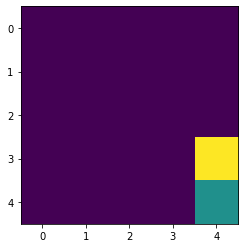

Action: Discrete(4)
Q_table: [[[ 3.43052621 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.2949068  -0.04208223]
  [ 0.36       -0.37002496  3.12041088  0.09753448]
  [ 2.90247112  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.63056862 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.25252568 -0.5904    ]
  [ 0.         -0.2         1

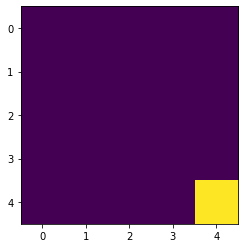

Round 37
Action: Discrete(4)
Q_table: [[[ 3.43052621 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.2949068  -0.04208223]
  [ 0.36       -0.37002496  3.12041088  0.09753448]
  [ 2.90247112  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.63056862 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.25252568 -0.5904    ]
  [ 0.         -0.2 

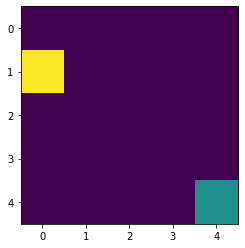

Action: Discrete(4)
Q_table: [[[ 3.47160606 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.2949068  -0.04208223]
  [ 0.36       -0.37002496  3.12041088  0.09753448]
  [ 2.90247112  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.63056862 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.25252568 -0.5904    ]
  [ 0.         -0.2         1

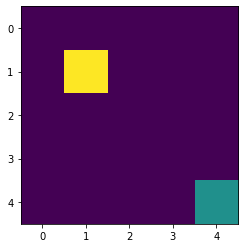

Action: Discrete(4)
Q_table: [[[ 3.47160606 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.33519118 -0.04208223]
  [ 0.36       -0.37002496  3.12041088  0.09753448]
  [ 2.90247112  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.63056862 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.25252568 -0.5904    ]
  [ 0.         -0.2         1

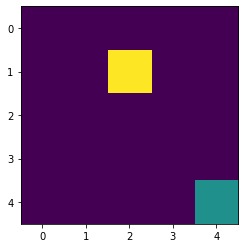

Action: Discrete(4)
Q_table: [[[ 3.47160606 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.33519118 -0.04208223]
  [ 0.36       -0.37002496  3.16072408  0.09753448]
  [ 2.90247112  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.63056862 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.25252568 -0.5904    ]
  [ 0.         -0.2         1

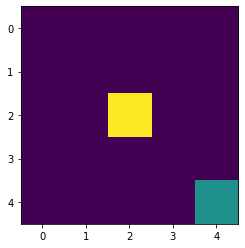

Action: Discrete(4)
Q_table: [[[ 3.47160606 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.33519118 -0.04208223]
  [ 0.36       -0.37002496  3.16072408  0.09753448]
  [ 2.94286788  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.63056862 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.25252568 -0.5904    ]
  [ 0.         -0.2         1

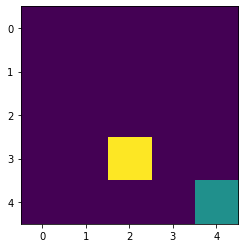

Action: Discrete(4)
Q_table: [[[ 3.47160606 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.33519118 -0.04208223]
  [ 0.36       -0.37002496  3.16072408  0.09753448]
  [ 2.94286788  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.66485901 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.25252568 -0.5904    ]
  [ 0.         -0.2         1

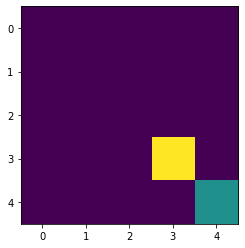

Action: Discrete(4)
Q_table: [[[ 3.47160606 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.33519118 -0.04208223]
  [ 0.36       -0.37002496  3.16072408  0.09753448]
  [ 2.94286788  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.66485901 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.27663028 -0.5904    ]
  [ 0.         -0.2         1

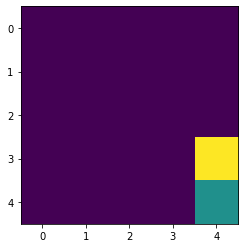

Action: Discrete(4)
Q_table: [[[ 3.47160606 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.33519118 -0.04208223]
  [ 0.36       -0.37002496  3.16072408  0.09753448]
  [ 2.94286788  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.66485901 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.27663028 -0.5904    ]
  [ 0.         -0.2         1

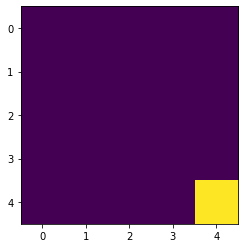

Round 38
Action: Discrete(4)
Q_table: [[[ 3.47160606 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.33519118 -0.04208223]
  [ 0.36       -0.37002496  3.16072408  0.09753448]
  [ 2.94286788  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.66485901 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.27663028 -0.5904    ]
  [ 0.         -0.2 

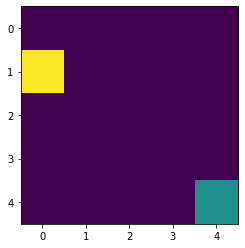

Action: Discrete(4)
Q_table: [[[ 3.51091544 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.33519118 -0.04208223]
  [ 0.36       -0.37002496  3.16072408  0.09753448]
  [ 2.94286788  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.66485901 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.27663028 -0.5904    ]
  [ 0.         -0.2         1

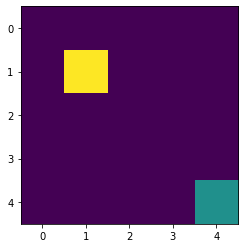

Action: Discrete(4)
Q_table: [[[ 3.51091544 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.3738688  -0.04208223]
  [ 0.36       -0.37002496  3.16072408  0.09753448]
  [ 2.94286788  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.66485901 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.27663028 -0.5904    ]
  [ 0.         -0.2         1

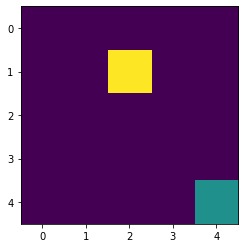

Action: Discrete(4)
Q_table: [[[ 3.51091544 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.3738688  -0.04208223]
  [ 0.36       -0.37002496  3.19943812  0.09753448]
  [ 2.94286788  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.66485901 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.27663028 -0.5904    ]
  [ 0.         -0.2         1

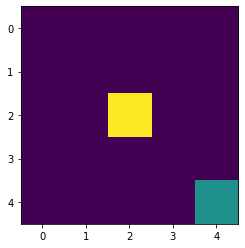

Action: Discrete(4)
Q_table: [[[ 3.51091544 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.3738688  -0.04208223]
  [ 0.36       -0.37002496  3.19943812  0.09753448]
  [ 2.98067174  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.66485901 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.27663028 -0.5904    ]
  [ 0.         -0.2         1

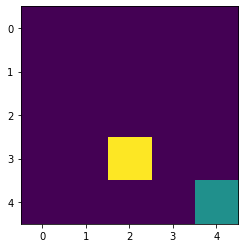

Action: Discrete(4)
Q_table: [[[ 3.51091544 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.3738688  -0.04208223]
  [ 0.36       -0.37002496  3.19943812  0.09753448]
  [ 2.98067174  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.69614805 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.27663028 -0.5904    ]
  [ 0.         -0.2         1

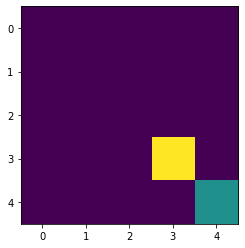

Action: Discrete(4)
Q_table: [[[ 3.51091544 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.3738688  -0.04208223]
  [ 0.36       -0.37002496  3.19943812  0.09753448]
  [ 2.98067174  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.69614805 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.29801556 -0.5904    ]
  [ 0.         -0.2         1

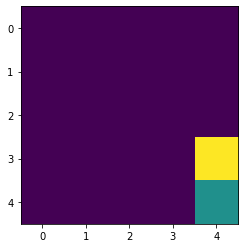

Action: Discrete(4)
Q_table: [[[ 3.51091544 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.3738688  -0.04208223]
  [ 0.36       -0.37002496  3.19943812  0.09753448]
  [ 2.98067174  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.69614805 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.29801556 -0.5904    ]
  [ 0.         -0.2         1

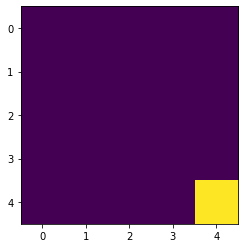

Round 39
Action: Discrete(4)
Q_table: [[[ 3.51091544 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.3738688  -0.04208223]
  [ 0.36       -0.37002496  3.19943812  0.09753448]
  [ 2.98067174  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.69614805 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.29801556 -0.5904    ]
  [ 0.         -0.2 

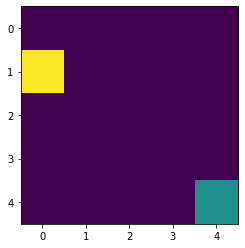

Action: Discrete(4)
Q_table: [[[ 3.54855136 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.3738688  -0.04208223]
  [ 0.36       -0.37002496  3.19943812  0.09753448]
  [ 2.98067174  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.69614805 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.29801556 -0.5904    ]
  [ 0.         -0.2         1

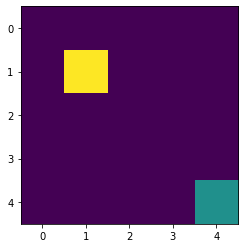

Action: Discrete(4)
Q_table: [[[ 3.54855136 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.41100514 -0.04208223]
  [ 0.36       -0.37002496  3.19943812  0.09753448]
  [ 2.98067174  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.69614805 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.29801556 -0.5904    ]
  [ 0.         -0.2         1

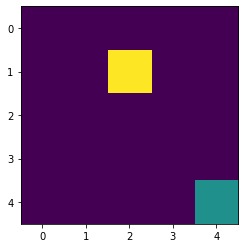

Action: Discrete(4)
Q_table: [[[ 3.54855136 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.41100514 -0.04208223]
  [ 0.36       -0.37002496  3.23645798  0.09753448]
  [ 2.98067174  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.69614805 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.29801556 -0.5904    ]
  [ 0.         -0.2         1

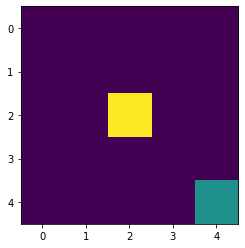

Action: Discrete(4)
Q_table: [[[ 3.54855136 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.41100514 -0.04208223]
  [ 0.36       -0.37002496  3.23645798  0.09753448]
  [ 3.01592108  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.69614805 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.29801556 -0.5904    ]
  [ 0.         -0.2         1

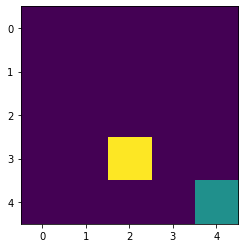

Action: Discrete(4)
Q_table: [[[ 3.54855136 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.41100514 -0.04208223]
  [ 0.36       -0.37002496  3.23645798  0.09753448]
  [ 3.01592108  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.72460093 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.29801556 -0.5904    ]
  [ 0.         -0.2         1

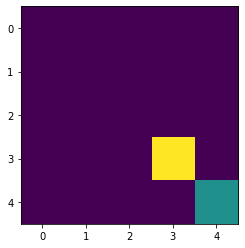

Action: Discrete(4)
Q_table: [[[ 3.54855136 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.41100514 -0.04208223]
  [ 0.36       -0.37002496  3.23645798  0.09753448]
  [ 3.01592108  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.72460093 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.31692034 -0.5904    ]
  [ 0.         -0.2         1

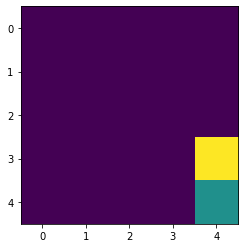

Action: Discrete(4)
Q_table: [[[ 3.54855136 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.41100514 -0.04208223]
  [ 0.36       -0.37002496  3.23645798  0.09753448]
  [ 3.01592108  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.72460093 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.31692034 -0.5904    ]
  [ 0.         -0.2         1

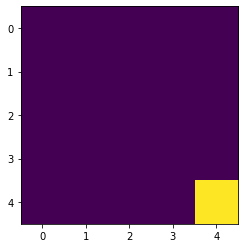

Round 40
Action: Discrete(4)
Q_table: [[[ 3.54855136 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.41100514 -0.04208223]
  [ 0.36       -0.37002496  3.23645798  0.09753448]
  [ 3.01592108  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.72460093 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.31692034 -0.5904    ]
  [ 0.         -0.2 

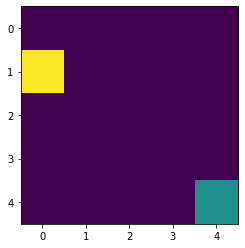

Action: Discrete(4)
Q_table: [[[ 3.58460191 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.41100514 -0.04208223]
  [ 0.36       -0.37002496  3.23645798  0.09753448]
  [ 3.01592108  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.72460093 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.31692034 -0.5904    ]
  [ 0.         -0.2         1

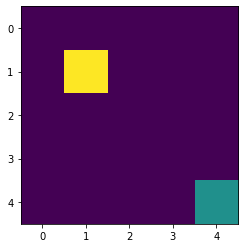

Action: Discrete(4)
Q_table: [[[ 3.58460191 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.44663739 -0.04208223]
  [ 0.36       -0.37002496  3.23645798  0.09753448]
  [ 3.01592108  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.72460093 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.31692034 -0.5904    ]
  [ 0.         -0.2         1

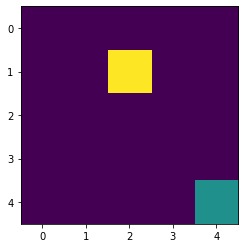

Action: Discrete(4)
Q_table: [[[ 3.58460191 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.44663739 -0.04208223]
  [ 0.36       -0.37002496  3.27171376  0.09753448]
  [ 3.01592108  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.72460093 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.31692034 -0.5904    ]
  [ 0.         -0.2         1

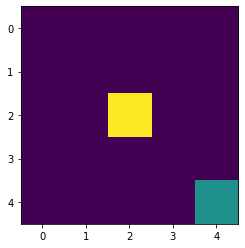

Action: Discrete(4)
Q_table: [[[ 3.58460191 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.44663739 -0.04208223]
  [ 0.36       -0.37002496  3.27171376  0.09753448]
  [ 3.04867301  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.72460093 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.31692034 -0.5904    ]
  [ 0.         -0.2         1

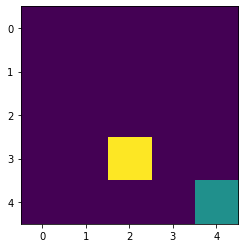

Action: Discrete(4)
Q_table: [[[ 3.58460191 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.44663739 -0.04208223]
  [ 0.36       -0.37002496  3.27171376  0.09753448]
  [ 3.04867301  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.750388   -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.31692034 -0.5904    ]
  [ 0.         -0.2         1

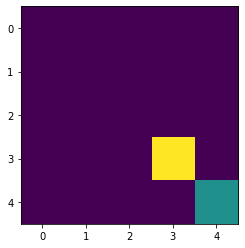

Action: Discrete(4)
Q_table: [[[ 3.58460191 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.44663739 -0.04208223]
  [ 0.36       -0.37002496  3.27171376  0.09753448]
  [ 3.04867301  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.750388   -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.33357366 -0.5904    ]
  [ 0.         -0.2         1

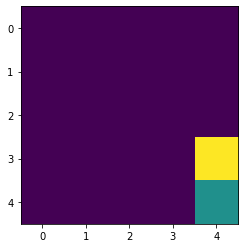

Action: Discrete(4)
Q_table: [[[ 3.58460191 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.44663739 -0.04208223]
  [ 0.36       -0.37002496  3.27171376  0.09753448]
  [ 3.04867301  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.750388   -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.33357366 -0.5904    ]
  [ 0.         -0.2         1

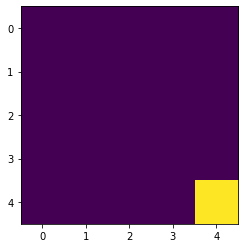

Round 41
Action: Discrete(4)
Q_table: [[[ 3.58460191 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.44663739 -0.04208223]
  [ 0.36       -0.37002496  3.27171376  0.09753448]
  [ 3.04867301  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.750388   -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.33357366 -0.5904    ]
  [ 0.         -0.2 

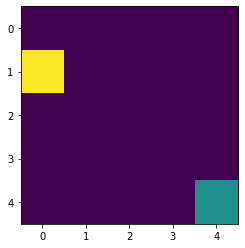

Action: Discrete(4)
Q_table: [[[ 3.61914351 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.44663739 -0.04208223]
  [ 0.36       -0.37002496  3.27171376  0.09753448]
  [ 3.04867301  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.750388   -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.33357366 -0.5904    ]
  [ 0.         -0.2         1

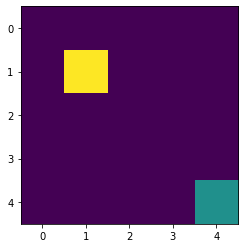

Action: Discrete(4)
Q_table: [[[ 3.61914351 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.48078411 -0.04208223]
  [ 0.36       -0.37002496  3.27171376  0.09753448]
  [ 3.04867301  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.750388   -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.33357366 -0.5904    ]
  [ 0.         -0.2         1

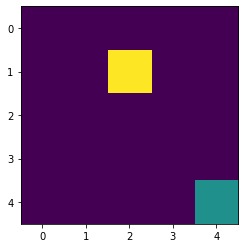

Action: Discrete(4)
Q_table: [[[ 3.61914351 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.48078411 -0.04208223]
  [ 0.36       -0.37002496  3.30515869  0.09753448]
  [ 3.04867301  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.750388   -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.33357366 -0.5904    ]
  [ 0.         -0.2         1

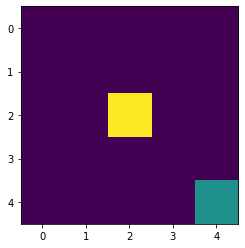

Action: Discrete(4)
Q_table: [[[ 3.61914351 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.48078411 -0.04208223]
  [ 0.36       -0.37002496  3.30515869  0.09753448]
  [ 3.07900049  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.750388   -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.33357366 -0.5904    ]
  [ 0.         -0.2         1

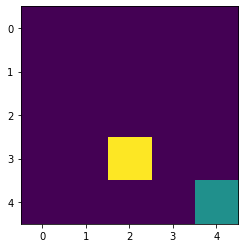

Action: Discrete(4)
Q_table: [[[ 3.61914351 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.48078411 -0.04208223]
  [ 0.36       -0.37002496  3.30515869  0.09753448]
  [ 3.07900049  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.77368218 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.33357366 -0.5904    ]
  [ 0.         -0.2         1

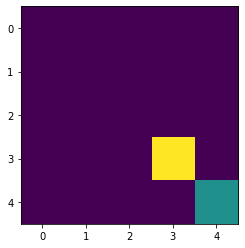

Action: Discrete(4)
Q_table: [[[ 3.61914351 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.48078411 -0.04208223]
  [ 0.36       -0.37002496  3.30515869  0.09753448]
  [ 3.07900049  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.77368218 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.34819368 -0.5904    ]
  [ 0.         -0.2         1

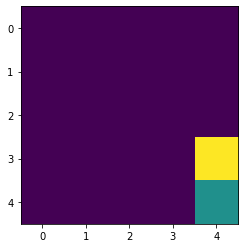

Action: Discrete(4)
Q_table: [[[ 3.61914351 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.48078411 -0.04208223]
  [ 0.36       -0.37002496  3.30515869  0.09753448]
  [ 3.07900049  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.77368218 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.34819368 -0.5904    ]
  [ 0.         -0.2         1

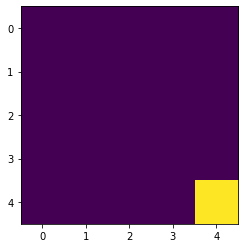

Round 42
Action: Discrete(4)
Q_table: [[[ 3.61914351 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.48078411 -0.04208223]
  [ 0.36       -0.37002496  3.30515869  0.09753448]
  [ 3.07900049  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.77368218 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.34819368 -0.5904    ]
  [ 0.         -0.2 

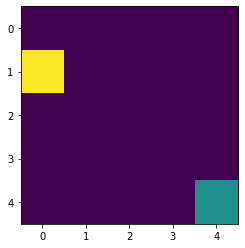

Action: Discrete(4)
Q_table: [[[ 3.65224026 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.48078411 -0.04208223]
  [ 0.36       -0.37002496  3.30515869  0.09753448]
  [ 3.07900049  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.77368218 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.34819368 -0.5904    ]
  [ 0.         -0.2         1

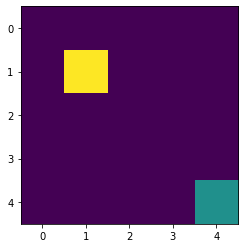

Action: Discrete(4)
Q_table: [[[ 3.65224026 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.51345268 -0.04208223]
  [ 0.36       -0.37002496  3.30515869  0.09753448]
  [ 3.07900049  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.77368218 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.34819368 -0.5904    ]
  [ 0.         -0.2         1

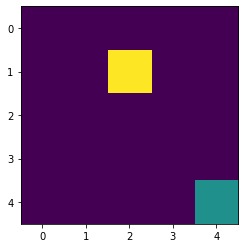

Action: Discrete(4)
Q_table: [[[ 3.65224026 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.51345268 -0.04208223]
  [ 0.36       -0.37002496  3.33676703  0.09753448]
  [ 3.07900049  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.77368218 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.34819368 -0.5904    ]
  [ 0.         -0.2         1

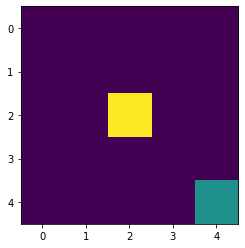

Action: Discrete(4)
Q_table: [[[ 3.65224026 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.51345268 -0.04208223]
  [ 0.36       -0.37002496  3.33676703  0.09753448]
  [ 3.10698954  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.77368218 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.34819368 -0.5904    ]
  [ 0.         -0.2         1

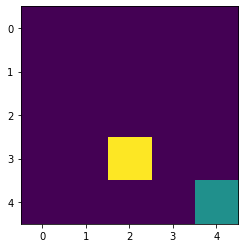

Action: Discrete(4)
Q_table: [[[ 3.65224026 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.51345268 -0.04208223]
  [ 0.36       -0.37002496  3.33676703  0.09753448]
  [ 3.10698954  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.79465674 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.34819368 -0.5904    ]
  [ 0.         -0.2         1

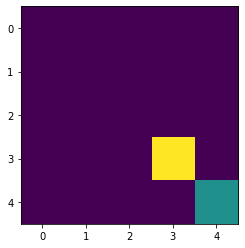

Action: Discrete(4)
Q_table: [[[ 3.65224026 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.51345268 -0.04208223]
  [ 0.36       -0.37002496  3.33676703  0.09753448]
  [ 3.10698954  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.79465674 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.36098663 -0.5904    ]
  [ 0.         -0.2         1

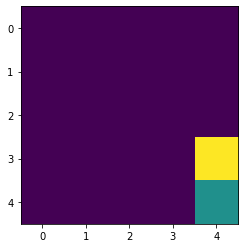

Action: Discrete(4)
Q_table: [[[ 3.65224026 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.51345268 -0.04208223]
  [ 0.36       -0.37002496  3.33676703  0.09753448]
  [ 3.10698954  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.79465674 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.36098663 -0.5904    ]
  [ 0.         -0.2         1

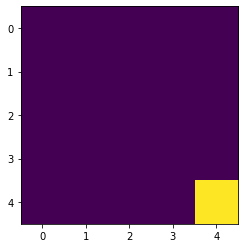

Round 43
Action: Discrete(4)
Q_table: [[[ 3.65224026 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.51345268 -0.04208223]
  [ 0.36       -0.37002496  3.33676703  0.09753448]
  [ 3.10698954  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.79465674 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.36098663 -0.5904    ]
  [ 0.         -0.2 

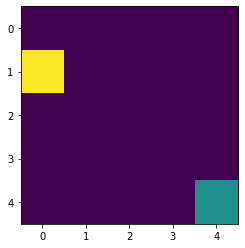

Action: Discrete(4)
Q_table: [[[ 3.68394464 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.51345268 -0.04208223]
  [ 0.36       -0.37002496  3.33676703  0.09753448]
  [ 3.10698954  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.79465674 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.36098663 -0.5904    ]
  [ 0.         -0.2         1

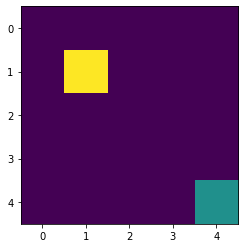

Action: Discrete(4)
Q_table: [[[ 3.68394464 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.54464487 -0.04208223]
  [ 0.36       -0.37002496  3.33676703  0.09753448]
  [ 3.10698954  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.79465674 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.36098663 -0.5904    ]
  [ 0.         -0.2         1

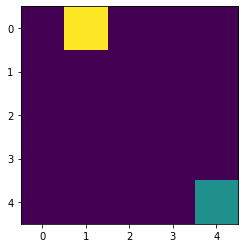

Action: Discrete(4)
Q_table: [[[ 3.68394464 -0.0928892   0.72803584  0.17387276]
  [ 1.05642389  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.54464487 -0.04208223]
  [ 0.36       -0.32699215  3.33676703  0.09753448]
  [ 3.10698954  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.79465674 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.36098663 -0.5904    ]
  [ 0.         -0.2         1

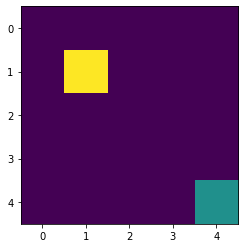

Action: Discrete(4)
Q_table: [[[ 3.68394464 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.54464487 -0.04208223]
  [ 0.36       -0.32699215  3.33676703  0.09753448]
  [ 3.10698954  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.79465674 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.36098663 -0.5904    ]
  [ 0.         -0.2         1

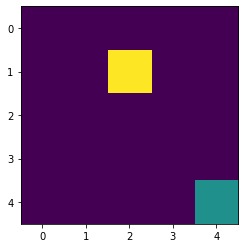

Action: Discrete(4)
Q_table: [[[ 3.68394464 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.54464487 -0.04208223]
  [ 0.36       -0.32699215  3.36653195  0.09753448]
  [ 3.10698954  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.79465674 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.36098663 -0.5904    ]
  [ 0.         -0.2         1

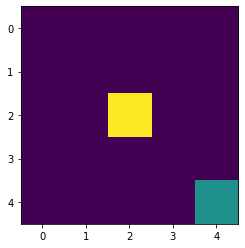

Action: Discrete(4)
Q_table: [[[ 3.68394464 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.54464487 -0.04208223]
  [ 0.36       -0.32699215  3.36653195  0.09753448]
  [ 3.13273671  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.79465674 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.36098663 -0.5904    ]
  [ 0.         -0.2         1

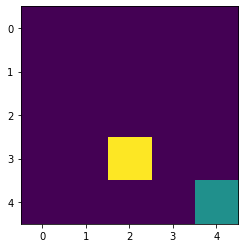

Action: Discrete(4)
Q_table: [[[ 3.68394464 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.54464487 -0.04208223]
  [ 0.36       -0.32699215  3.36653195  0.09753448]
  [ 3.13273671  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.81348325 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.36098663 -0.5904    ]
  [ 0.         -0.2         1

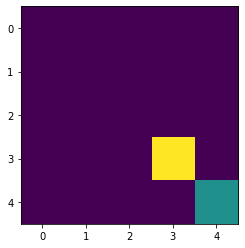

Action: Discrete(4)
Q_table: [[[ 3.68394464 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.54464487 -0.04208223]
  [ 0.36       -0.32699215  3.36653195  0.09753448]
  [ 3.13273671  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.81348325 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.37214576 -0.5904    ]
  [ 0.         -0.2         1

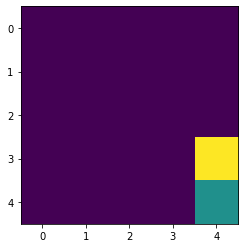

Round 44
Action: Discrete(4)
Q_table: [[[ 3.68394464 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.54464487 -0.04208223]
  [ 0.36       -0.32699215  3.36653195  0.09753448]
  [ 3.13273671  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.81348325 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.37214576 -0.5904    ]
  [ 0.         -0.2 

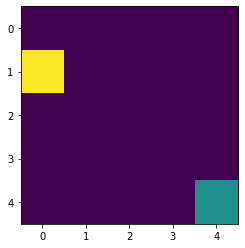

Action: Discrete(4)
Q_table: [[[ 3.71429889 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.54464487 -0.04208223]
  [ 0.36       -0.32699215  3.36653195  0.09753448]
  [ 3.13273671  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.81348325 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.37214576 -0.5904    ]
  [ 0.         -0.2         1

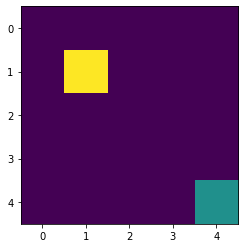

Action: Discrete(4)
Q_table: [[[ 3.71429889 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.57436101 -0.04208223]
  [ 0.36       -0.32699215  3.36653195  0.09753448]
  [ 3.13273671  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.81348325 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.37214576 -0.5904    ]
  [ 0.         -0.2         1

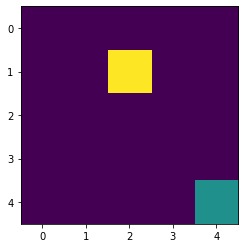

Action: Discrete(4)
Q_table: [[[ 3.71429889 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.57436101 -0.04208223]
  [ 0.36       -0.32699215  3.39446343  0.09753448]
  [ 3.13273671  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.81348325 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.37214576 -0.5904    ]
  [ 0.         -0.2         1

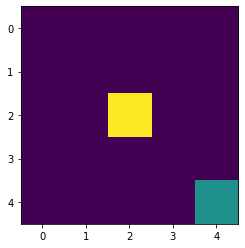

Action: Discrete(4)
Q_table: [[[ 3.71429889 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.57436101 -0.04208223]
  [ 0.36       -0.32699215  3.39446343  0.09753448]
  [ 3.15634669  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.81348325 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.37214576 -0.5904    ]
  [ 0.         -0.2         1

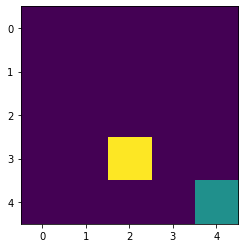

Action: Discrete(4)
Q_table: [[[ 3.71429889 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.57436101 -0.04208223]
  [ 0.36       -0.32699215  3.39446343  0.09753448]
  [ 3.15634669  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.83032992 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.37214576 -0.5904    ]
  [ 0.         -0.2         1

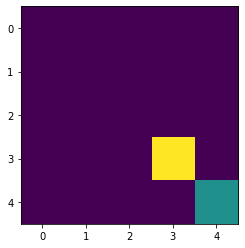

Action: Discrete(4)
Q_table: [[[ 3.71429889 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.57436101 -0.04208223]
  [ 0.36       -0.32699215  3.39446343  0.09753448]
  [ 3.15634669  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.83032992 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.38185066 -0.5904    ]
  [ 0.         -0.2         1

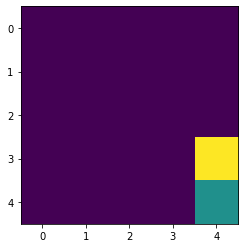

Action: Discrete(4)
Q_table: [[[ 3.71429889 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.57436101 -0.04208223]
  [ 0.36       -0.32699215  3.39446343  0.09753448]
  [ 3.15634669  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.83032992 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.38185066 -0.5904    ]
  [ 0.         -0.2         1

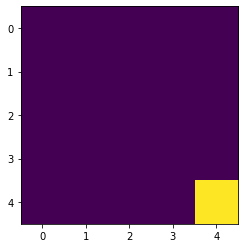

Round 45
Action: Discrete(4)
Q_table: [[[ 3.71429889 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.57436101 -0.04208223]
  [ 0.36       -0.32699215  3.39446343  0.09753448]
  [ 3.15634669  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.83032992 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.38185066 -0.5904    ]
  [ 0.         -0.2 

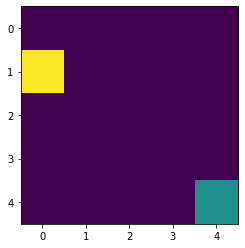

Action: Discrete(4)
Q_table: [[[ 3.74333687 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.57436101 -0.04208223]
  [ 0.36       -0.32699215  3.39446343  0.09753448]
  [ 3.15634669  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.83032992 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.38185066 -0.5904    ]
  [ 0.         -0.2         1

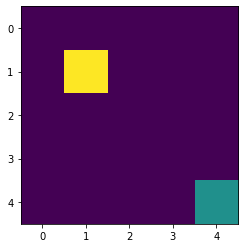

Action: Discrete(4)
Q_table: [[[ 3.74333687 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.60260295 -0.04208223]
  [ 0.36       -0.32699215  3.39446343  0.09753448]
  [ 3.15634669  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.83032992 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.38185066 -0.5904    ]
  [ 0.         -0.2         1

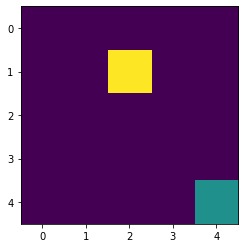

Action: Discrete(4)
Q_table: [[[ 3.74333687 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.60260295 -0.04208223]
  [ 0.36       -0.32699215  3.42058622  0.09753448]
  [ 3.15634669  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.83032992 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.38185066 -0.5904    ]
  [ 0.         -0.2         1

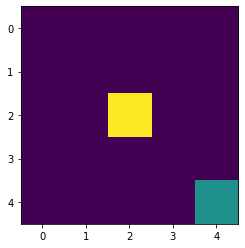

Action: Discrete(4)
Q_table: [[[ 3.74333687 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.60260295 -0.04208223]
  [ 0.36       -0.32699215  3.42058622  0.09753448]
  [ 3.17793014  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.83032992 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.38185066 -0.5904    ]
  [ 0.         -0.2         1

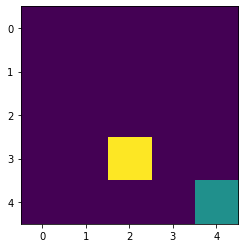

Action: Discrete(4)
Q_table: [[[ 3.74333687 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.60260295 -0.04208223]
  [ 0.36       -0.32699215  3.42058622  0.09753448]
  [ 3.17793014  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.84536004 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.38185066 -0.5904    ]
  [ 0.         -0.2         1

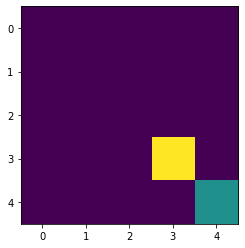

Action: Discrete(4)
Q_table: [[[ 3.74333687 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.60260295 -0.04208223]
  [ 0.36       -0.32699215  3.42058622  0.09753448]
  [ 3.17793014  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.84536004 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.39023665 -0.5904    ]
  [ 0.         -0.2         1

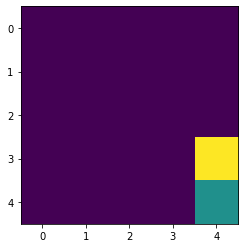

Action: Discrete(4)
Q_table: [[[ 3.74333687 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.60260295 -0.04208223]
  [ 0.36       -0.32699215  3.42058622  0.09753448]
  [ 3.17793014  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.84536004 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.39023665 -0.5904    ]
  [ 0.         -0.2         1

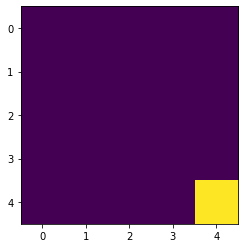

Round 46
Action: Discrete(4)
Q_table: [[[ 3.74333687 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.60260295 -0.04208223]
  [ 0.36       -0.32699215  3.42058622  0.09753448]
  [ 3.17793014  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.84536004 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.39023665 -0.5904    ]
  [ 0.         -0.2 

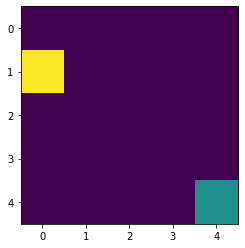

Action: Discrete(4)
Q_table: [[[ 3.77108597 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.60260295 -0.04208223]
  [ 0.36       -0.32699215  3.42058622  0.09753448]
  [ 3.17793014  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.84536004 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.39023665 -0.5904    ]
  [ 0.         -0.2         1

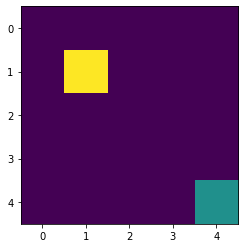

Action: Discrete(4)
Q_table: [[[ 3.77108597 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.62937616 -0.04208223]
  [ 0.36       -0.32699215  3.42058622  0.09753448]
  [ 3.17793014  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.84536004 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.39023665 -0.5904    ]
  [ 0.         -0.2         1

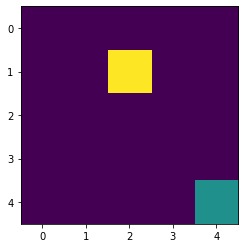

Action: Discrete(4)
Q_table: [[[ 3.77108597 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.62937616 -0.04208223]
  [ 0.36       -0.32699215  3.4449378   0.09753448]
  [ 3.17793014  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.84536004 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.39023665 -0.5904    ]
  [ 0.         -0.2         1

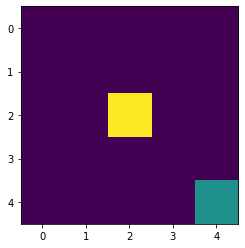

Action: Discrete(4)
Q_table: [[[ 3.77108597 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.62937616 -0.04208223]
  [ 0.36       -0.32699215  3.4449378   0.09753448]
  [ 3.19760172  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.84536004 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.39023665 -0.5904    ]
  [ 0.         -0.2         1

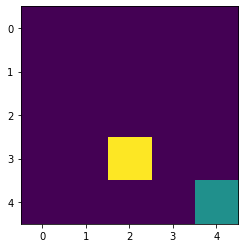

Action: Discrete(4)
Q_table: [[[ 3.77108597 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.62937616 -0.04208223]
  [ 0.36       -0.32699215  3.4449378   0.09753448]
  [ 3.19760172  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.8587259  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.39023665 -0.5904    ]
  [ 0.         -0.2         1

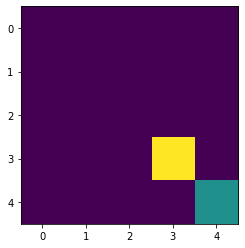

Action: Discrete(4)
Q_table: [[[ 3.77108597 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.62937616 -0.04208223]
  [ 0.36       -0.32699215  3.4449378   0.09753448]
  [ 3.19760172  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.8587259  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.39747333 -0.5904    ]
  [ 0.         -0.2         1

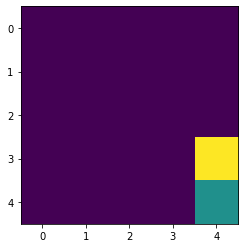

Action: Discrete(4)
Q_table: [[[ 3.77108597 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.62937616 -0.04208223]
  [ 0.36       -0.32699215  3.4449378   0.09753448]
  [ 3.19760172  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.8587259  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.39747333 -0.5904    ]
  [ 0.         -0.2         1

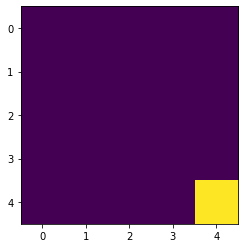

Round 47
Action: Discrete(4)
Q_table: [[[ 3.77108597 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.62937616 -0.04208223]
  [ 0.36       -0.32699215  3.4449378   0.09753448]
  [ 3.19760172  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.8587259  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.39747333 -0.5904    ]
  [ 0.         -0.2 

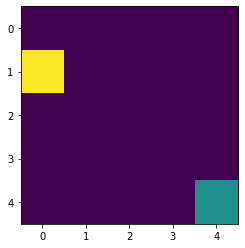

Action: Discrete(4)
Q_table: [[[ 3.79756896 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.62937616 -0.04208223]
  [ 0.36       -0.32699215  3.4449378   0.09753448]
  [ 3.19760172  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.8587259  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.39747333 -0.5904    ]
  [ 0.         -0.2         1

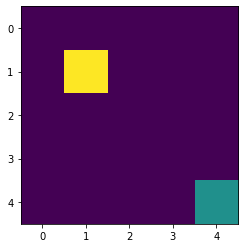

Action: Discrete(4)
Q_table: [[[ 3.79756896 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.65469097 -0.04208223]
  [ 0.36       -0.32699215  3.4449378   0.09753448]
  [ 3.19760172  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.8587259  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.39747333 -0.5904    ]
  [ 0.         -0.2         1

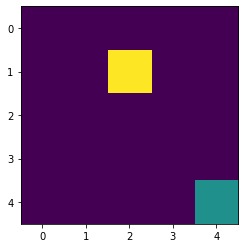

Action: Discrete(4)
Q_table: [[[ 3.79756896 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.65469097 -0.04208223]
  [ 0.36       -0.32699215  3.46756651  0.09753448]
  [ 3.19760172  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.8587259  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.39747333 -0.5904    ]
  [ 0.         -0.2         1

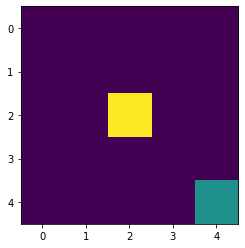

Action: Discrete(4)
Q_table: [[[ 3.79756896 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.65469097 -0.04208223]
  [ 0.36       -0.32699215  3.46756651  0.09753448]
  [ 3.21547752  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.8587259  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.39747333 -0.5904    ]
  [ 0.         -0.2         1

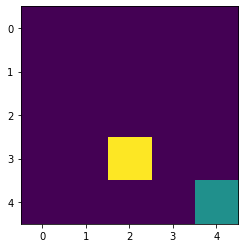

Action: Discrete(4)
Q_table: [[[ 3.79756896 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.65469097 -0.04208223]
  [ 0.36       -0.32699215  3.46756651  0.09753448]
  [ 3.21547752  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.87057645 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.39747333 -0.5904    ]
  [ 0.         -0.2         1

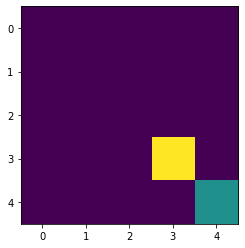

Action: Discrete(4)
Q_table: [[[ 3.79756896 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.65469097 -0.04208223]
  [ 0.36       -0.32699215  3.46756651  0.09753448]
  [ 3.21547752  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.87057645 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.40370915 -0.5904    ]
  [ 0.         -0.2         1

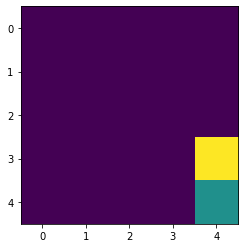

Action: Discrete(4)
Q_table: [[[ 3.79756896 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.65469097 -0.04208223]
  [ 0.36       -0.32699215  3.46756651  0.09753448]
  [ 3.21547752  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.87057645 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.40370915 -0.5904    ]
  [ 0.         -0.2         1

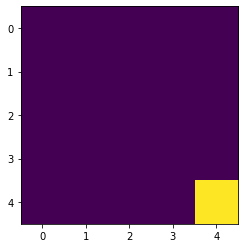

Round 48
Action: Discrete(4)
Q_table: [[[ 3.79756896 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.65469097 -0.04208223]
  [ 0.36       -0.32699215  3.46756651  0.09753448]
  [ 3.21547752  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.87057645 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.40370915 -0.5904    ]
  [ 0.         -0.2 

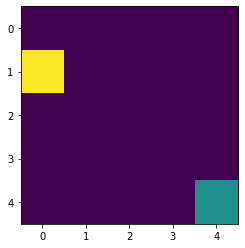

Action: Discrete(4)
Q_table: [[[ 3.82280573 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.65469097 -0.04208223]
  [ 0.36       -0.32699215  3.46756651  0.09753448]
  [ 3.21547752  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.87057645 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.40370915 -0.5904    ]
  [ 0.         -0.2         1

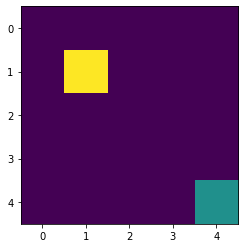

Action: Discrete(4)
Q_table: [[[ 3.82280573 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.67856342 -0.04208223]
  [ 0.36       -0.32699215  3.46756651  0.09753448]
  [ 3.21547752  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.87057645 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.40370915 -0.5904    ]
  [ 0.         -0.2         1

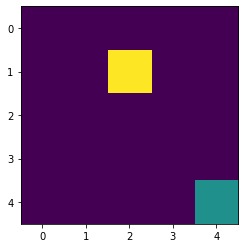

Action: Discrete(4)
Q_table: [[[ 3.82280573 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.67856342 -0.04208223]
  [ 0.36       -0.32699215  3.48852961  0.09753448]
  [ 3.21547752  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.87057645 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.40370915 -0.5904    ]
  [ 0.         -0.2         1

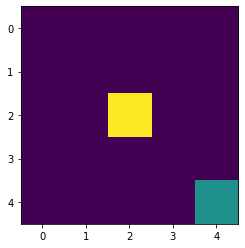

Action: Discrete(4)
Q_table: [[[ 3.82280573 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.67856342 -0.04208223]
  [ 0.36       -0.32699215  3.48852961  0.09753448]
  [ 3.23167425  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.87057645 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.40370915 -0.5904    ]
  [ 0.         -0.2         1

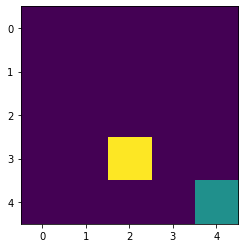

Action: Discrete(4)
Q_table: [[[ 3.82280573 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.67856342 -0.04208223]
  [ 0.36       -0.32699215  3.48852961  0.09753448]
  [ 3.23167425  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.88105463 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.40370915 -0.5904    ]
  [ 0.         -0.2         1

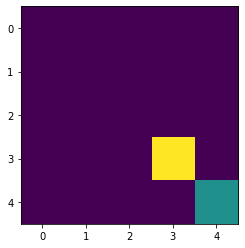

Action: Discrete(4)
Q_table: [[[ 3.82280573 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.67856342 -0.04208223]
  [ 0.36       -0.32699215  3.48852961  0.09753448]
  [ 3.23167425  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.88105463 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.40907434 -0.5904    ]
  [ 0.         -0.2         1

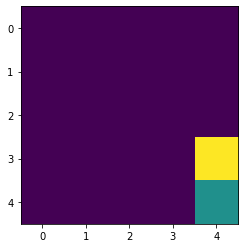

Action: Discrete(4)
Q_table: [[[ 3.82280573 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.67856342 -0.04208223]
  [ 0.36       -0.32699215  3.48852961  0.09753448]
  [ 3.23167425  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.88105463 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.40907434 -0.5904    ]
  [ 0.         -0.2         1

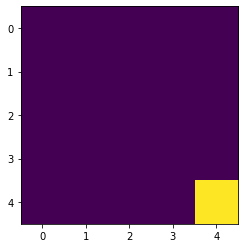

Round 49
Action: Discrete(4)
Q_table: [[[ 3.82280573 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.67856342 -0.04208223]
  [ 0.36       -0.32699215  3.48852961  0.09753448]
  [ 3.23167425  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.88105463 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.40907434 -0.5904    ]
  [ 0.         -0.2 

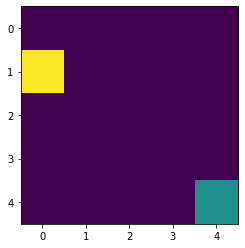

Action: Discrete(4)
Q_table: [[[ 3.84681473 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.67856342 -0.04208223]
  [ 0.36       -0.32699215  3.48852961  0.09753448]
  [ 3.23167425  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.88105463 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.40907434 -0.5904    ]
  [ 0.         -0.2         1

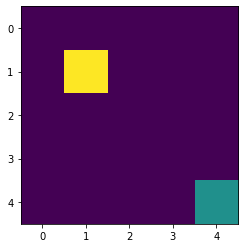

Action: Discrete(4)
Q_table: [[[ 3.84681473 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.70101547 -0.04208223]
  [ 0.36       -0.32699215  3.48852961  0.09753448]
  [ 3.23167425  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.88105463 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.40907434 -0.5904    ]
  [ 0.         -0.2         1

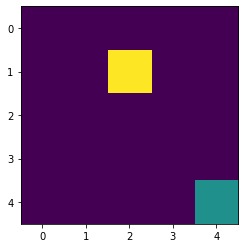

Action: Discrete(4)
Q_table: [[[ 3.84681473 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.70101547 -0.04208223]
  [ 0.36       -0.32699215  3.50789157  0.09753448]
  [ 3.23167425  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.88105463 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.40907434 -0.5904    ]
  [ 0.         -0.2         1

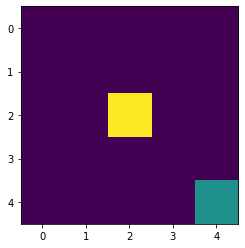

Action: Discrete(4)
Q_table: [[[ 3.84681473 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.70101547 -0.04208223]
  [ 0.36       -0.32699215  3.50789157  0.09753448]
  [ 3.24630814  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.88105463 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.40907434 -0.5904    ]
  [ 0.         -0.2         1

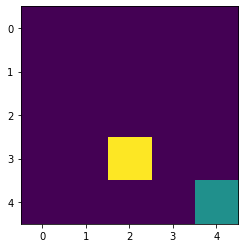

Action: Discrete(4)
Q_table: [[[ 3.84681473 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.70101547 -0.04208223]
  [ 0.36       -0.32699215  3.50789157  0.09753448]
  [ 3.24630814  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.89029559 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.40907434 -0.5904    ]
  [ 0.         -0.2         1

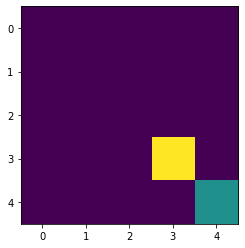

Action: Discrete(4)
Q_table: [[[ 3.84681473 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.70101547 -0.04208223]
  [ 0.36       -0.32699215  3.50789157  0.09753448]
  [ 3.24630814  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.89029559 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.41368319 -0.5904    ]
  [ 0.         -0.2         1

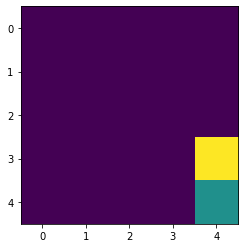

Action: Discrete(4)
Q_table: [[[ 3.84681473 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.70101547 -0.04208223]
  [ 0.36       -0.32699215  3.50789157  0.09753448]
  [ 3.24630814  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.89029559 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.41368319 -0.5904    ]
  [ 0.         -0.2         1

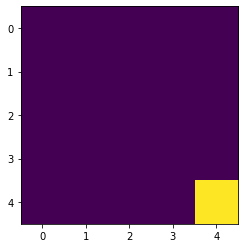

Round 50
Action: Discrete(4)
Q_table: [[[ 3.84681473 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.70101547 -0.04208223]
  [ 0.36       -0.32699215  3.50789157  0.09753448]
  [ 3.24630814  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.89029559 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.41368319 -0.5904    ]
  [ 0.         -0.2 

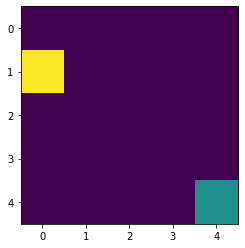

Action: Discrete(4)
Q_table: [[[ 3.86961426 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.70101547 -0.04208223]
  [ 0.36       -0.32699215  3.50789157  0.09753448]
  [ 3.24630814  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.89029559 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.41368319 -0.5904    ]
  [ 0.         -0.2         1

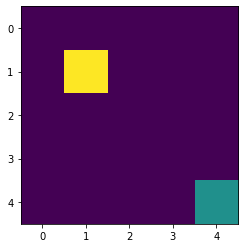

Action: Discrete(4)
Q_table: [[[ 3.86961426 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.72207503 -0.04208223]
  [ 0.36       -0.32699215  3.50789157  0.09753448]
  [ 3.24630814  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.89029559 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.41368319 -0.5904    ]
  [ 0.         -0.2         1

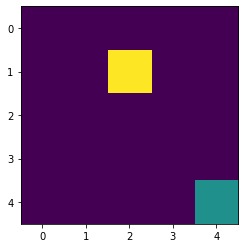

Action: Discrete(4)
Q_table: [[[ 3.86961426 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.72207503 -0.04208223]
  [ 0.36       -0.32699215  3.52572256  0.09753448]
  [ 3.24630814  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.89029559 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.41368319 -0.5904    ]
  [ 0.         -0.2         1

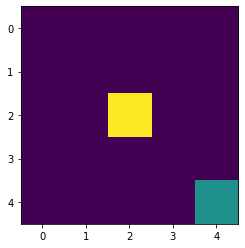

Action: Discrete(4)
Q_table: [[[ 3.86961426 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.72207503 -0.04208223]
  [ 0.36       -0.32699215  3.52572256  0.09753448]
  [ 3.25949381  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.89029559 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.41368319 -0.5904    ]
  [ 0.         -0.2         1

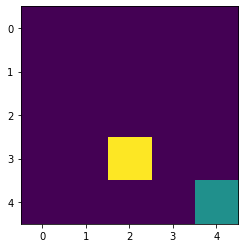

Action: Discrete(4)
Q_table: [[[ 3.86961426 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.72207503 -0.04208223]
  [ 0.36       -0.32699215  3.52572256  0.09753448]
  [ 3.25949381  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.89842579 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.41368319 -0.5904    ]
  [ 0.         -0.2         1

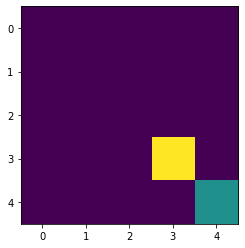

Action: Discrete(4)
Q_table: [[[ 3.86961426 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.72207503 -0.04208223]
  [ 0.36       -0.32699215  3.52572256  0.09753448]
  [ 3.25949381  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.89842579 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.41763601 -0.5904    ]
  [ 0.         -0.2         1

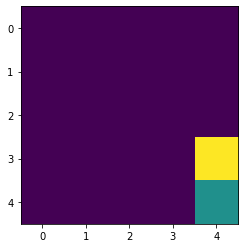

Action: Discrete(4)
Q_table: [[[ 3.86961426 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.72207503 -0.04208223]
  [ 0.36       -0.32699215  3.52572256  0.09753448]
  [ 3.25949381  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.89842579 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.41763601 -0.5904    ]
  [ 0.         -0.2         1

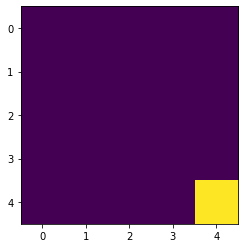

Round 51
Action: Discrete(4)
Q_table: [[[ 3.86961426 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.72207503 -0.04208223]
  [ 0.36       -0.32699215  3.52572256  0.09753448]
  [ 3.25949381  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.89842579 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.41763601 -0.5904    ]
  [ 0.         -0.2 

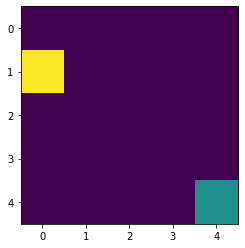

Action: Discrete(4)
Q_table: [[[ 3.89122341 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.72207503 -0.04208223]
  [ 0.36       -0.32699215  3.52572256  0.09753448]
  [ 3.25949381  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.89842579 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.41763601 -0.5904    ]
  [ 0.         -0.2         1

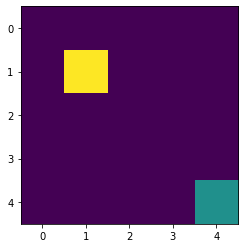

Action: Discrete(4)
Q_table: [[[ 3.89122341 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.74177563 -0.04208223]
  [ 0.36       -0.32699215  3.52572256  0.09753448]
  [ 3.25949381  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.89842579 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.41763601 -0.5904    ]
  [ 0.         -0.2         1

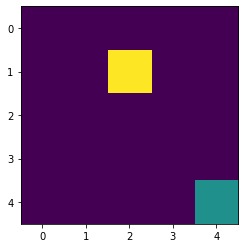

Action: Discrete(4)
Q_table: [[[ 3.89122341 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.74177563 -0.04208223]
  [ 0.36       -0.32699215  3.54209705  0.09753448]
  [ 3.25949381  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.89842579 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.41763601 -0.5904    ]
  [ 0.         -0.2         1

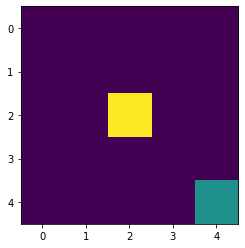

Action: Discrete(4)
Q_table: [[[ 3.89122341 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.74177563 -0.04208223]
  [ 0.36       -0.32699215  3.54209705  0.09753448]
  [ 3.27134317  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.89842579 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.41763601 -0.5904    ]
  [ 0.         -0.2         1

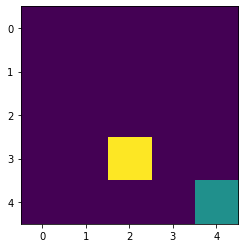

Action: Discrete(4)
Q_table: [[[ 3.89122341 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.74177563 -0.04208223]
  [ 0.36       -0.32699215  3.54209705  0.09753448]
  [ 3.27134317  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.90556239 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.41763601 -0.5904    ]
  [ 0.         -0.2         1

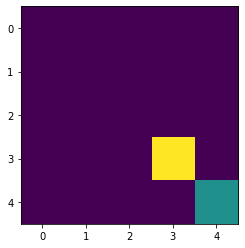

Action: Discrete(4)
Q_table: [[[ 3.89122341 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.74177563 -0.04208223]
  [ 0.36       -0.32699215  3.54209705  0.09753448]
  [ 3.27134317  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.90556239 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.42102076 -0.5904    ]
  [ 0.         -0.2         1

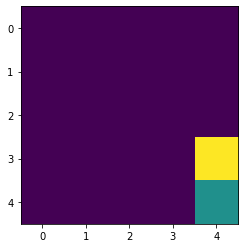

Action: Discrete(4)
Q_table: [[[ 3.89122341 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.74177563 -0.04208223]
  [ 0.36       -0.32699215  3.54209705  0.09753448]
  [ 3.27134317  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.90556239 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.42102076 -0.5904    ]
  [ 0.         -0.2         1

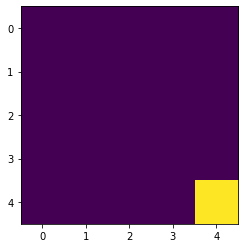

Round 52
Action: Discrete(4)
Q_table: [[[ 3.89122341 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.74177563 -0.04208223]
  [ 0.36       -0.32699215  3.54209705  0.09753448]
  [ 3.27134317  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.90556239 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.42102076 -0.5904    ]
  [ 0.         -0.2 

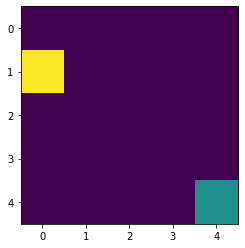

Action: Discrete(4)
Q_table: [[[ 3.91166283 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.74177563 -0.04208223]
  [ 0.36       -0.32699215  3.54209705  0.09753448]
  [ 3.27134317  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.90556239 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.42102076 -0.5904    ]
  [ 0.         -0.2         1

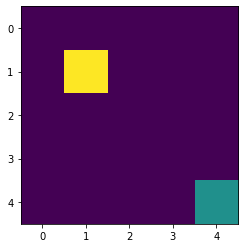

Action: Discrete(4)
Q_table: [[[ 3.91166283 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.76015604 -0.04208223]
  [ 0.36       -0.32699215  3.54209705  0.09753448]
  [ 3.27134317  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.90556239 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.42102076 -0.5904    ]
  [ 0.         -0.2         1

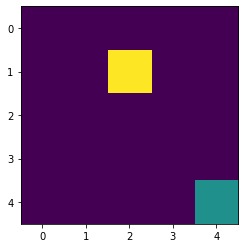

Action: Discrete(4)
Q_table: [[[ 3.91166283 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.76015604 -0.04208223]
  [ 0.36       -0.32699215  3.55709255  0.09753448]
  [ 3.27134317  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.90556239 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.42102076 -0.5904    ]
  [ 0.         -0.2         1

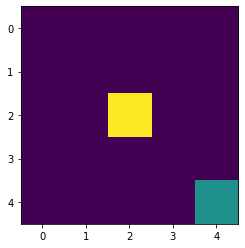

Action: Discrete(4)
Q_table: [[[ 3.91166283 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.76015604 -0.04208223]
  [ 0.36       -0.32699215  3.55709255  0.09753448]
  [ 3.28196452  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.90556239 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.42102076 -0.5904    ]
  [ 0.         -0.2         1

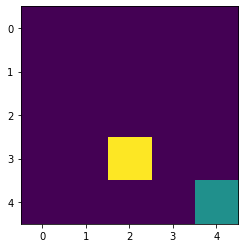

Action: Discrete(4)
Q_table: [[[ 3.91166283 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.76015604 -0.04208223]
  [ 0.36       -0.32699215  3.55709255  0.09753448]
  [ 3.28196452  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.91181324 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.42102076 -0.5904    ]
  [ 0.         -0.2         1

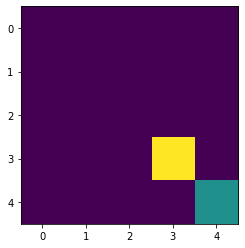

Action: Discrete(4)
Q_table: [[[ 3.91166283 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.76015604 -0.04208223]
  [ 0.36       -0.32699215  3.55709255  0.09753448]
  [ 3.28196452  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.91181324 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.42391448 -0.5904    ]
  [ 0.         -0.2         1

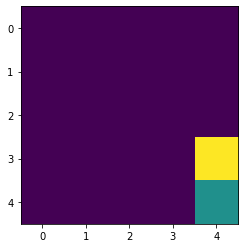

Action: Discrete(4)
Q_table: [[[ 3.91166283 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.76015604 -0.04208223]
  [ 0.36       -0.32699215  3.55709255  0.09753448]
  [ 3.28196452  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.91181324 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.42391448 -0.5904    ]
  [ 0.         -0.2         1

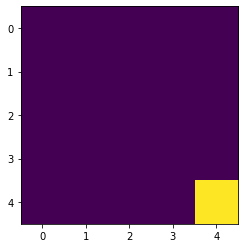

Round 53
Action: Discrete(4)
Q_table: [[[ 3.91166283 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.76015604 -0.04208223]
  [ 0.36       -0.32699215  3.55709255  0.09753448]
  [ 3.28196452  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.91181324 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.42391448 -0.5904    ]
  [ 0.         -0.2 

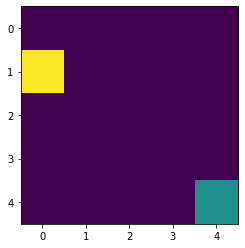

Action: Discrete(4)
Q_table: [[[ 3.93095523 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.76015604 -0.04208223]
  [ 0.36       -0.32699215  3.55709255  0.09753448]
  [ 3.28196452  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.91181324 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.42391448 -0.5904    ]
  [ 0.         -0.2         1

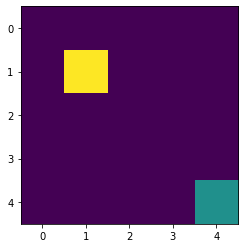

Action: Discrete(4)
Q_table: [[[ 3.93095523 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.77725964 -0.04208223]
  [ 0.36       -0.32699215  3.55709255  0.09753448]
  [ 3.28196452  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.91181324 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.42391448 -0.5904    ]
  [ 0.         -0.2         1

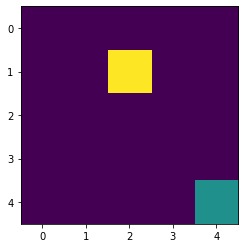

Action: Discrete(4)
Q_table: [[[ 3.93095523 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.77725964 -0.04208223]
  [ 0.36       -0.32699215  3.57078836  0.09753448]
  [ 3.28196452  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.91181324 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.42391448 -0.5904    ]
  [ 0.         -0.2         1

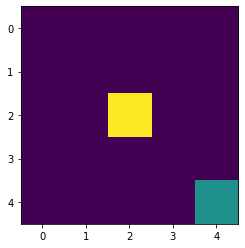

Action: Discrete(4)
Q_table: [[[ 3.93095523 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.77725964 -0.04208223]
  [ 0.36       -0.32699215  3.57078836  0.09753448]
  [ 3.29146173  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.91181324 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.42391448 -0.5904    ]
  [ 0.         -0.2         1

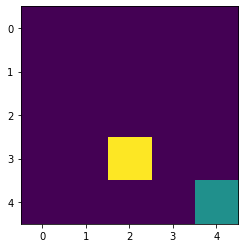

Action: Discrete(4)
Q_table: [[[ 3.93095523 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.77725964 -0.04208223]
  [ 0.36       -0.32699215  3.57078836  0.09753448]
  [ 3.29146173  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.91727691 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.42391448 -0.5904    ]
  [ 0.         -0.2         1

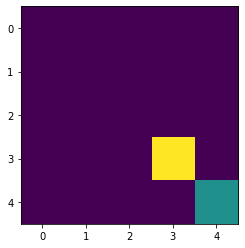

Action: Discrete(4)
Q_table: [[[ 3.93095523 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.77725964 -0.04208223]
  [ 0.36       -0.32699215  3.57078836  0.09753448]
  [ 3.29146173  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.91727691 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.42638453 -0.5904    ]
  [ 0.         -0.2         1

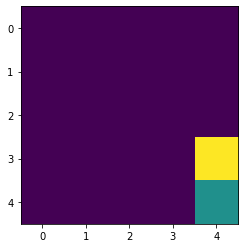

Action: Discrete(4)
Q_table: [[[ 3.93095523 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.77725964 -0.04208223]
  [ 0.36       -0.32699215  3.57078836  0.09753448]
  [ 3.29146173  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.91727691 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.42638453 -0.5904    ]
  [ 0.         -0.2         1

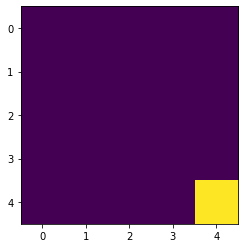

Round 54
Action: Discrete(4)
Q_table: [[[ 3.93095523 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.77725964 -0.04208223]
  [ 0.36       -0.32699215  3.57078836  0.09753448]
  [ 3.29146173  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.91727691 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.42638453 -0.5904    ]
  [ 0.         -0.2 

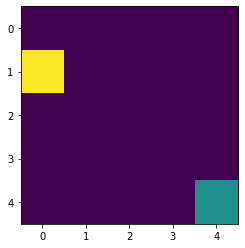

Action: Discrete(4)
Q_table: [[[ 3.94912573 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.77725964 -0.04208223]
  [ 0.36       -0.32699215  3.57078836  0.09753448]
  [ 3.29146173  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.91727691 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.42638453 -0.5904    ]
  [ 0.         -0.2         1

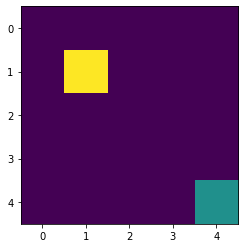

Action: Discrete(4)
Q_table: [[[ 3.94912573 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.79313385 -0.04208223]
  [ 0.36       -0.32699215  3.57078836  0.09753448]
  [ 3.29146173  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.91727691 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.42638453 -0.5904    ]
  [ 0.         -0.2         1

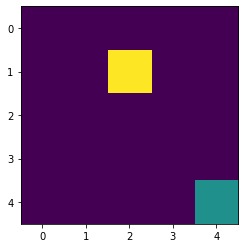

Action: Discrete(4)
Q_table: [[[ 3.94912573 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.79313385 -0.04208223]
  [ 0.36       -0.32699215  3.58326457  0.09753448]
  [ 3.29146173  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.91727691 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.42638453 -0.5904    ]
  [ 0.         -0.2         1

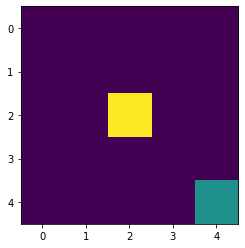

Action: Discrete(4)
Q_table: [[[ 3.94912573 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.79313385 -0.04208223]
  [ 0.36       -0.32699215  3.58326457  0.09753448]
  [ 3.29993369  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.91727691 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.42638453 -0.5904    ]
  [ 0.         -0.2         1

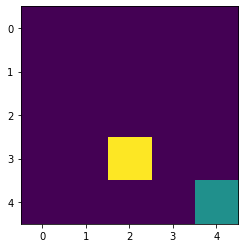

Action: Discrete(4)
Q_table: [[[ 3.94912573 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.79313385 -0.04208223]
  [ 0.36       -0.32699215  3.58326457  0.09753448]
  [ 3.29993369  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.92204305 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.42638453 -0.5904    ]
  [ 0.         -0.2         1

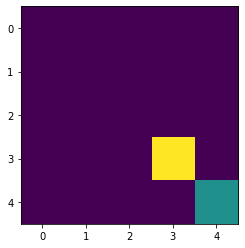

Action: Discrete(4)
Q_table: [[[ 3.94912573 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.79313385 -0.04208223]
  [ 0.36       -0.32699215  3.58326457  0.09753448]
  [ 3.29993369  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.92204305 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4284897  -0.5904    ]
  [ 0.         -0.2         1

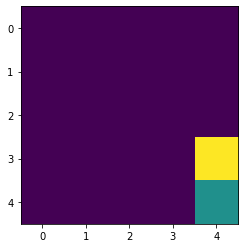

Action: Discrete(4)
Q_table: [[[ 3.94912573 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.79313385 -0.04208223]
  [ 0.36       -0.32699215  3.58326457  0.09753448]
  [ 3.29993369  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.92204305 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4284897  -0.5904    ]
  [ 0.         -0.2         1

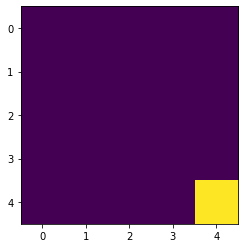

Round 55
Action: Discrete(4)
Q_table: [[[ 3.94912573 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.79313385 -0.04208223]
  [ 0.36       -0.32699215  3.58326457  0.09753448]
  [ 3.29993369  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.92204305 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4284897  -0.5904    ]
  [ 0.         -0.2 

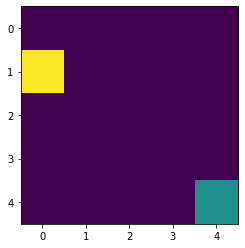

Action: Discrete(4)
Q_table: [[[ 3.966202   -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.79313385 -0.04208223]
  [ 0.36       -0.32699215  3.58326457  0.09753448]
  [ 3.29993369  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.92204305 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4284897  -0.5904    ]
  [ 0.         -0.2         1

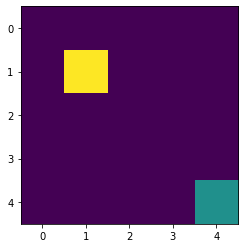

Action: Discrete(4)
Q_table: [[[ 3.966202   -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.80782941 -0.04208223]
  [ 0.36       -0.32699215  3.58326457  0.09753448]
  [ 3.29993369  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.92204305 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4284897  -0.5904    ]
  [ 0.         -0.2         1

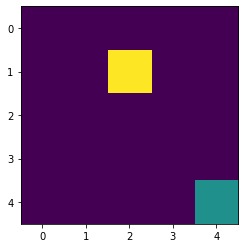

Action: Discrete(4)
Q_table: [[[ 3.966202   -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.80782941 -0.04208223]
  [ 0.36       -0.32699215  3.59460105  0.09753448]
  [ 3.29993369  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.92204305 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4284897  -0.5904    ]
  [ 0.         -0.2         1

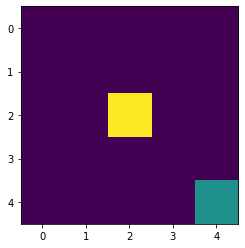

Action: Discrete(4)
Q_table: [[[ 3.966202   -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.80782941 -0.04208223]
  [ 0.36       -0.32699215  3.59460105  0.09753448]
  [ 3.30747384  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.92204305 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4284897  -0.5904    ]
  [ 0.         -0.2         1

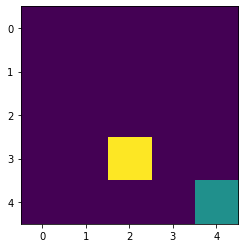

Action: Discrete(4)
Q_table: [[[ 3.966202   -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.80782941 -0.04208223]
  [ 0.36       -0.32699215  3.59460105  0.09753448]
  [ 3.30747384  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.92619279 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4284897  -0.5904    ]
  [ 0.         -0.2         1

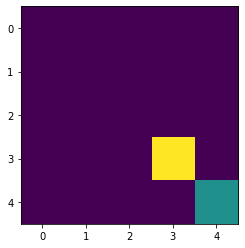

Action: Discrete(4)
Q_table: [[[ 3.966202   -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.80782941 -0.04208223]
  [ 0.36       -0.32699215  3.59460105  0.09753448]
  [ 3.30747384  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.92619279 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43028119 -0.5904    ]
  [ 0.         -0.2         1

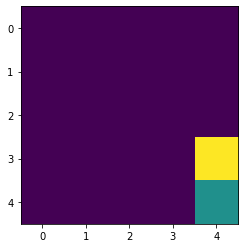

Action: Discrete(4)
Q_table: [[[ 3.966202   -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.80782941 -0.04208223]
  [ 0.36       -0.32699215  3.59460105  0.09753448]
  [ 3.30747384  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.92619279 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43028119 -0.5904    ]
  [ 0.         -0.2         1

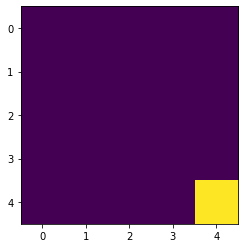

Round 56
Action: Discrete(4)
Q_table: [[[ 3.966202   -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.80782941 -0.04208223]
  [ 0.36       -0.32699215  3.59460105  0.09753448]
  [ 3.30747384  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.92619279 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43028119 -0.5904    ]
  [ 0.         -0.2 

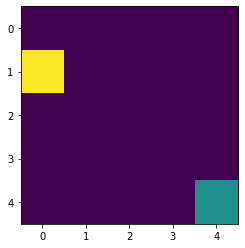

Action: Discrete(4)
Q_table: [[[ 3.9822143  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.80782941 -0.04208223]
  [ 0.36       -0.32699215  3.59460105  0.09753448]
  [ 3.30747384  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.92619279 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43028119 -0.5904    ]
  [ 0.         -0.2         1

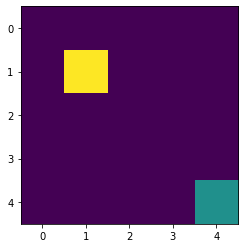

Action: Discrete(4)
Q_table: [[[ 3.9822143  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.82139969 -0.04208223]
  [ 0.36       -0.32699215  3.59460105  0.09753448]
  [ 3.30747384  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.92619279 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43028119 -0.5904    ]
  [ 0.         -0.2         1

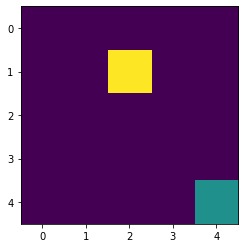

Action: Discrete(4)
Q_table: [[[ 3.9822143  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.82139969 -0.04208223]
  [ 0.36       -0.32699215  3.60487665  0.09753448]
  [ 3.30747384  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.92619279 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43028119 -0.5904    ]
  [ 0.         -0.2         1

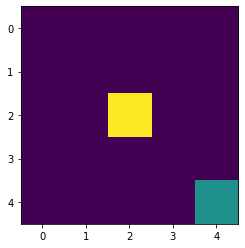

Action: Discrete(4)
Q_table: [[[ 3.9822143  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.82139969 -0.04208223]
  [ 0.36       -0.32699215  3.60487665  0.09753448]
  [ 3.31416992  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.92619279 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43028119 -0.5904    ]
  [ 0.         -0.2         1

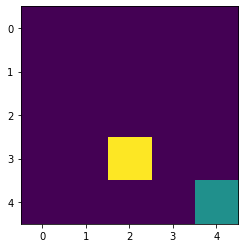

Action: Discrete(4)
Q_table: [[[ 3.9822143  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.82139969 -0.04208223]
  [ 0.36       -0.32699215  3.60487665  0.09753448]
  [ 3.31416992  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.92979922 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43028119 -0.5904    ]
  [ 0.         -0.2         1

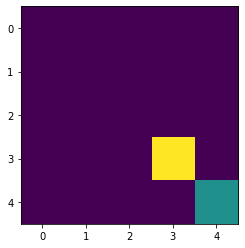

Action: Discrete(4)
Q_table: [[[ 3.9822143  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.82139969 -0.04208223]
  [ 0.36       -0.32699215  3.60487665  0.09753448]
  [ 3.31416992  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.92979922 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43180352 -0.5904    ]
  [ 0.         -0.2         1

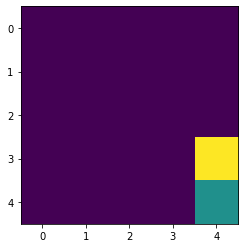

Action: Discrete(4)
Q_table: [[[ 3.9822143  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.82139969 -0.04208223]
  [ 0.36       -0.32699215  3.60487665  0.09753448]
  [ 3.31416992  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.92979922 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43180352 -0.5904    ]
  [ 0.         -0.2         1

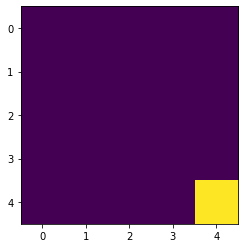

Round 57
Action: Discrete(4)
Q_table: [[[ 3.9822143  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.82139969 -0.04208223]
  [ 0.36       -0.32699215  3.60487665  0.09753448]
  [ 3.31416992  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.92979922 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43180352 -0.5904    ]
  [ 0.         -0.2 

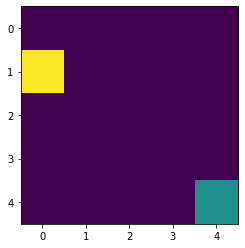

Action: Discrete(4)
Q_table: [[[ 3.99719539 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.82139969 -0.04208223]
  [ 0.36       -0.32699215  3.60487665  0.09753448]
  [ 3.31416992  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.92979922 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43180352 -0.5904    ]
  [ 0.         -0.2         1

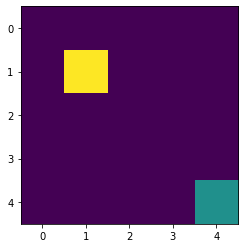

Action: Discrete(4)
Q_table: [[[ 3.99719539 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.83390002 -0.04208223]
  [ 0.36       -0.32699215  3.60487665  0.09753448]
  [ 3.31416992  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.92979922 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43180352 -0.5904    ]
  [ 0.         -0.2         1

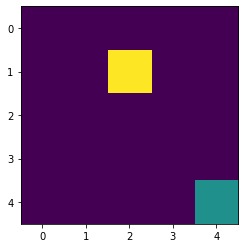

Action: Discrete(4)
Q_table: [[[ 3.99719539 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.83390002 -0.04208223]
  [ 0.36       -0.32699215  3.61416851  0.09753448]
  [ 3.31416992  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.92979922 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43180352 -0.5904    ]
  [ 0.         -0.2         1

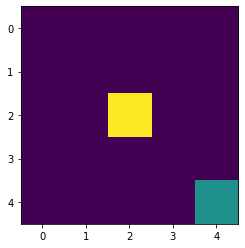

Action: Discrete(4)
Q_table: [[[ 3.99719539 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.83390002 -0.04208223]
  [ 0.36       -0.32699215  3.61416851  0.09753448]
  [ 3.32010381  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.92979922 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43180352 -0.5904    ]
  [ 0.         -0.2         1

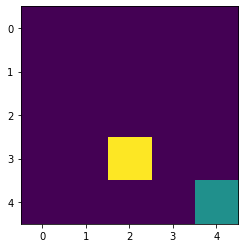

Action: Discrete(4)
Q_table: [[[ 3.99719539 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.83390002 -0.04208223]
  [ 0.36       -0.32699215  3.61416851  0.09753448]
  [ 3.32010381  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.93292794 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43180352 -0.5904    ]
  [ 0.         -0.2         1

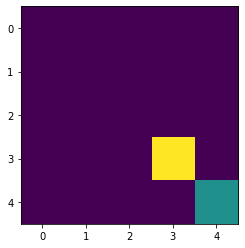

Action: Discrete(4)
Q_table: [[[ 3.99719539 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.83390002 -0.04208223]
  [ 0.36       -0.32699215  3.61416851  0.09753448]
  [ 3.32010381  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.93292794 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43309528 -0.5904    ]
  [ 0.         -0.2         1

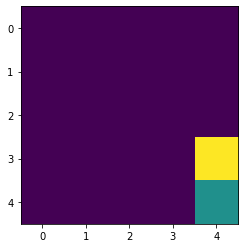

Action: Discrete(4)
Q_table: [[[ 3.99719539 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.83390002 -0.04208223]
  [ 0.36       -0.32699215  3.61416851  0.09753448]
  [ 3.32010381  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.93292794 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43309528 -0.5904    ]
  [ 0.         -0.2         1

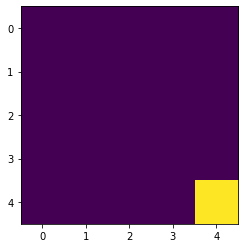

Round 58
Action: Discrete(4)
Q_table: [[[ 3.99719539 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.83390002 -0.04208223]
  [ 0.36       -0.32699215  3.61416851  0.09753448]
  [ 3.32010381  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.93292794 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43309528 -0.5904    ]
  [ 0.         -0.2 

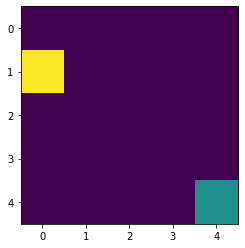

Action: Discrete(4)
Q_table: [[[ 4.01118032 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.83390002 -0.04208223]
  [ 0.36       -0.32699215  3.61416851  0.09753448]
  [ 3.32010381  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.93292794 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43309528 -0.5904    ]
  [ 0.         -0.2         1

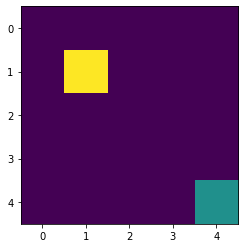

Action: Discrete(4)
Q_table: [[[ 4.01118032 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.84538698 -0.04208223]
  [ 0.36       -0.32699215  3.61416851  0.09753448]
  [ 3.32010381  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.93292794 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43309528 -0.5904    ]
  [ 0.         -0.2         1

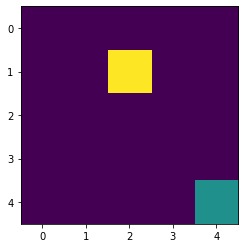

Action: Discrete(4)
Q_table: [[[ 4.01118032 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.84538698 -0.04208223]
  [ 0.36       -0.32699215  3.62255142  0.09753448]
  [ 3.32010381  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.93292794 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43309528 -0.5904    ]
  [ 0.         -0.2         1

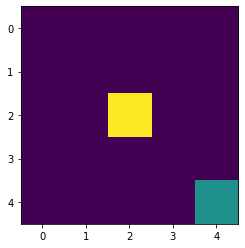

Action: Discrete(4)
Q_table: [[[ 4.01118032 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.84538698 -0.04208223]
  [ 0.36       -0.32699215  3.62255142  0.09753448]
  [ 3.32535152  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.93292794 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43309528 -0.5904    ]
  [ 0.         -0.2         1

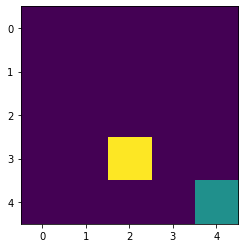

Action: Discrete(4)
Q_table: [[[ 4.01118032 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.84538698 -0.04208223]
  [ 0.36       -0.32699215  3.62255142  0.09753448]
  [ 3.32535152  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9356376  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43309528 -0.5904    ]
  [ 0.         -0.2         1

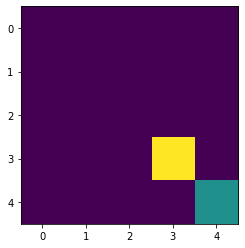

Action: Discrete(4)
Q_table: [[[ 4.01118032 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.84538698 -0.04208223]
  [ 0.36       -0.32699215  3.62255142  0.09753448]
  [ 3.32535152  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9356376  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43418989 -0.5904    ]
  [ 0.         -0.2         1

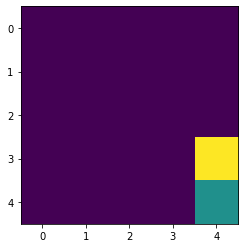

Action: Discrete(4)
Q_table: [[[ 4.01118032 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.84538698 -0.04208223]
  [ 0.36       -0.32699215  3.62255142  0.09753448]
  [ 3.32535152  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9356376  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43418989 -0.5904    ]
  [ 0.         -0.2         1

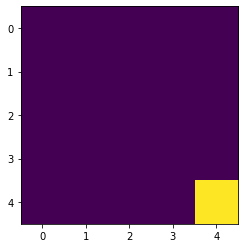

Round 59
Action: Discrete(4)
Q_table: [[[ 4.01118032 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.84538698 -0.04208223]
  [ 0.36       -0.32699215  3.62255142  0.09753448]
  [ 3.32535152  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9356376  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43418989 -0.5904    ]
  [ 0.         -0.2 

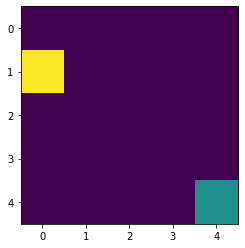

Action: Discrete(4)
Q_table: [[[ 4.02420617 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.84538698 -0.04208223]
  [ 0.36       -0.32699215  3.62255142  0.09753448]
  [ 3.32535152  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9356376  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43418989 -0.5904    ]
  [ 0.         -0.2         1

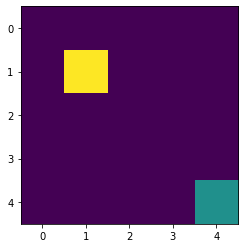

Action: Discrete(4)
Q_table: [[[ 4.02420617 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.85591781 -0.04208223]
  [ 0.36       -0.32699215  3.62255142  0.09753448]
  [ 3.32535152  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9356376  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43418989 -0.5904    ]
  [ 0.         -0.2         1

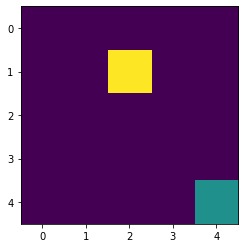

Action: Discrete(4)
Q_table: [[[ 4.02420617 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.85591781 -0.04208223]
  [ 0.36       -0.32699215  3.63009738  0.09753448]
  [ 3.32535152  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9356376  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43418989 -0.5904    ]
  [ 0.         -0.2         1

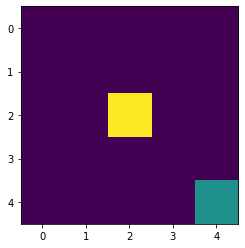

Action: Discrete(4)
Q_table: [[[ 4.02420617 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.85591781 -0.04208223]
  [ 0.36       -0.32699215  3.63009738  0.09753448]
  [ 3.32998323  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9356376  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43418989 -0.5904    ]
  [ 0.         -0.2         1

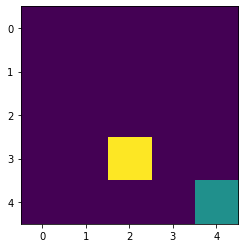

Action: Discrete(4)
Q_table: [[[ 4.02420617 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.85591781 -0.04208223]
  [ 0.36       -0.32699215  3.63009738  0.09753448]
  [ 3.32998323  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.93798046 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43418989 -0.5904    ]
  [ 0.         -0.2         1

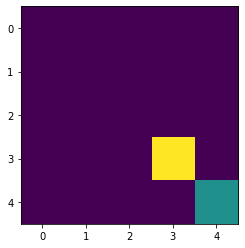

Action: Discrete(4)
Q_table: [[[ 4.02420617 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.85591781 -0.04208223]
  [ 0.36       -0.32699215  3.63009738  0.09753448]
  [ 3.32998323  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.93798046 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4351162  -0.5904    ]
  [ 0.         -0.2         1

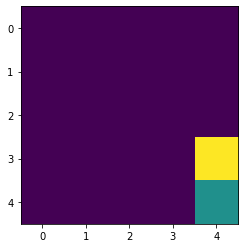

Action: Discrete(4)
Q_table: [[[ 4.02420617 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.85591781 -0.04208223]
  [ 0.36       -0.32699215  3.63009738  0.09753448]
  [ 3.32998323  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.93798046 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4351162  -0.5904    ]
  [ 0.         -0.2         1

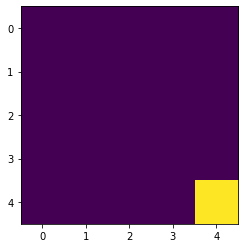

Round 60
Action: Discrete(4)
Q_table: [[[ 4.02420617 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.85591781 -0.04208223]
  [ 0.36       -0.32699215  3.63009738  0.09753448]
  [ 3.32998323  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.93798046 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4351162  -0.5904    ]
  [ 0.         -0.2 

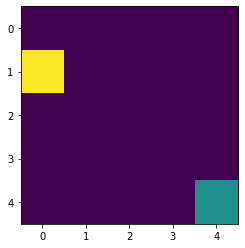

Action: Discrete(4)
Q_table: [[[ 4.03631179 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.85591781 -0.04208223]
  [ 0.36       -0.32699215  3.63009738  0.09753448]
  [ 3.32998323  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.93798046 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4351162  -0.5904    ]
  [ 0.         -0.2         1

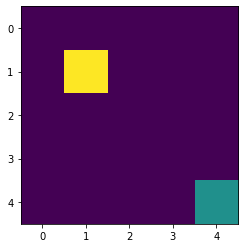

Action: Discrete(4)
Q_table: [[[ 4.03631179 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.86554983 -0.04208223]
  [ 0.36       -0.32699215  3.63009738  0.09753448]
  [ 3.32998323  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.93798046 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4351162  -0.5904    ]
  [ 0.         -0.2         1

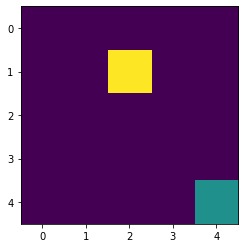

Action: Discrete(4)
Q_table: [[[ 4.03631179 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.86554983 -0.04208223]
  [ 0.36       -0.32699215  3.63687522  0.09753448]
  [ 3.32998323  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.93798046 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4351162  -0.5904    ]
  [ 0.         -0.2         1

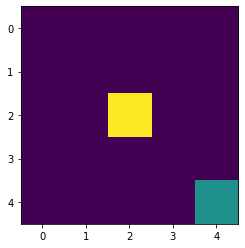

Action: Discrete(4)
Q_table: [[[ 4.03631179 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.86554983 -0.04208223]
  [ 0.36       -0.32699215  3.63687522  0.09753448]
  [ 3.33406346  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.93798046 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4351162  -0.5904    ]
  [ 0.         -0.2         1

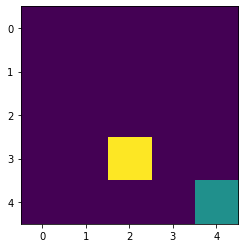

Action: Discrete(4)
Q_table: [[[ 4.03631179 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.86554983 -0.04208223]
  [ 0.36       -0.32699215  3.63687522  0.09753448]
  [ 3.33406346  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94000296 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4351162  -0.5904    ]
  [ 0.         -0.2         1

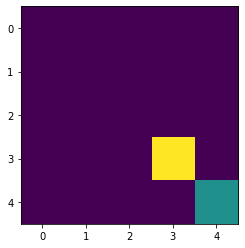

Action: Discrete(4)
Q_table: [[[ 4.03631179 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.86554983 -0.04208223]
  [ 0.36       -0.32699215  3.63687522  0.09753448]
  [ 3.33406346  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94000296 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43589907 -0.5904    ]
  [ 0.         -0.2         1

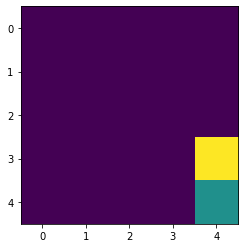

Action: Discrete(4)
Q_table: [[[ 4.03631179 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.86554983 -0.04208223]
  [ 0.36       -0.32699215  3.63687522  0.09753448]
  [ 3.33406346  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94000296 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43589907 -0.5904    ]
  [ 0.         -0.2         1

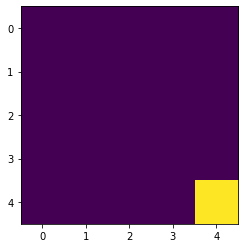

Round 61
Action: Discrete(4)
Q_table: [[[ 4.03631179 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.86554983 -0.04208223]
  [ 0.36       -0.32699215  3.63687522  0.09753448]
  [ 3.33406346  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94000296 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43589907 -0.5904    ]
  [ 0.         -0.2 

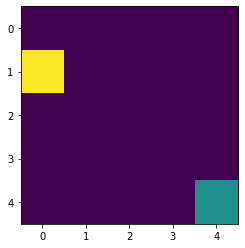

Action: Discrete(4)
Q_table: [[[ 4.0475374  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.86554983 -0.04208223]
  [ 0.36       -0.32699215  3.63687522  0.09753448]
  [ 3.33406346  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94000296 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43589907 -0.5904    ]
  [ 0.         -0.2         1

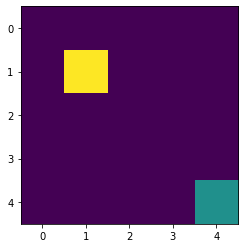

Action: Discrete(4)
Q_table: [[[ 4.0475374  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.8743399  -0.04208223]
  [ 0.36       -0.32699215  3.63687522  0.09753448]
  [ 3.33406346  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94000296 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43589907 -0.5904    ]
  [ 0.         -0.2         1

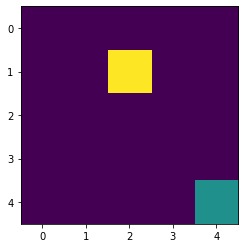

Action: Discrete(4)
Q_table: [[[ 4.0475374  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.8743399  -0.04208223]
  [ 0.36       -0.32699215  3.64295033  0.09753448]
  [ 3.33406346  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94000296 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43589907 -0.5904    ]
  [ 0.         -0.2         1

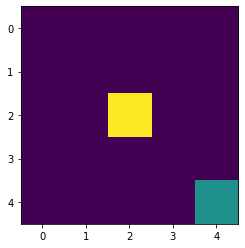

Action: Discrete(4)
Q_table: [[[ 4.0475374  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.8743399  -0.04208223]
  [ 0.36       -0.32699215  3.64295033  0.09753448]
  [ 3.33765124  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94000296 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43589907 -0.5904    ]
  [ 0.         -0.2         1

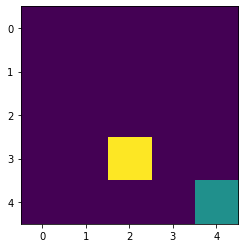

Action: Discrete(4)
Q_table: [[[ 4.0475374  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.8743399  -0.04208223]
  [ 0.36       -0.32699215  3.64295033  0.09753448]
  [ 3.33765124  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94174622 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43589907 -0.5904    ]
  [ 0.         -0.2         1

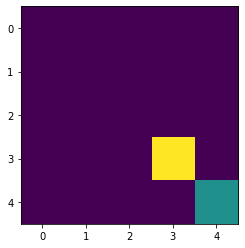

Action: Discrete(4)
Q_table: [[[ 4.0475374  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.8743399  -0.04208223]
  [ 0.36       -0.32699215  3.64295033  0.09753448]
  [ 3.33765124  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94174622 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43655989 -0.5904    ]
  [ 0.         -0.2         1

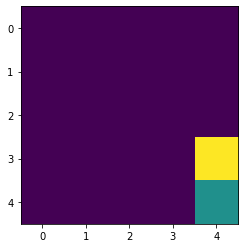

Action: Discrete(4)
Q_table: [[[ 4.0475374  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.8743399  -0.04208223]
  [ 0.36       -0.32699215  3.64295033  0.09753448]
  [ 3.33765124  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94174622 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43655989 -0.5904    ]
  [ 0.         -0.2         1

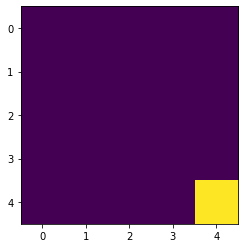

Round 62
Action: Discrete(4)
Q_table: [[[ 4.0475374  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.8743399  -0.04208223]
  [ 0.36       -0.32699215  3.64295033  0.09753448]
  [ 3.33765124  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94174622 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43655989 -0.5904    ]
  [ 0.         -0.2 

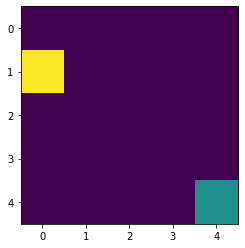

Action: Discrete(4)
Q_table: [[[ 4.0579243  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.8743399  -0.04208223]
  [ 0.36       -0.32699215  3.64295033  0.09753448]
  [ 3.33765124  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94174622 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43655989 -0.5904    ]
  [ 0.         -0.2         1

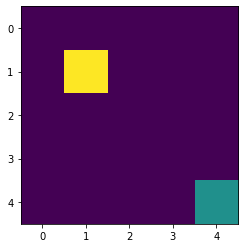

Action: Discrete(4)
Q_table: [[[ 4.0579243  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.88234397 -0.04208223]
  [ 0.36       -0.32699215  3.64295033  0.09753448]
  [ 3.33765124  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94174622 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43655989 -0.5904    ]
  [ 0.         -0.2         1

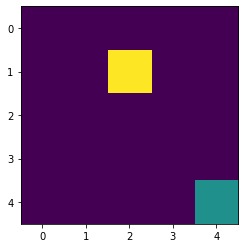

Action: Discrete(4)
Q_table: [[[ 4.0579243  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.88234397 -0.04208223]
  [ 0.36       -0.32699215  3.64838446  0.09753448]
  [ 3.33765124  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94174622 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43655989 -0.5904    ]
  [ 0.         -0.2         1

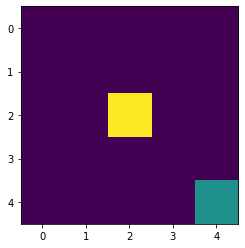

Action: Discrete(4)
Q_table: [[[ 4.0579243  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.88234397 -0.04208223]
  [ 0.36       -0.32699215  3.64838446  0.09753448]
  [ 3.34080039  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94174622 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43655989 -0.5904    ]
  [ 0.         -0.2         1

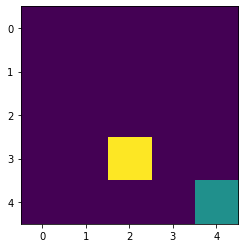

Action: Discrete(4)
Q_table: [[[ 4.0579243  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.88234397 -0.04208223]
  [ 0.36       -0.32699215  3.64838446  0.09753448]
  [ 3.34080039  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94324656 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43655989 -0.5904    ]
  [ 0.         -0.2         1

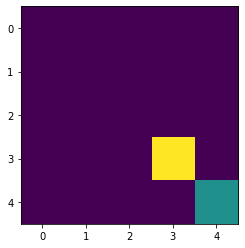

Action: Discrete(4)
Q_table: [[[ 4.0579243  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.88234397 -0.04208223]
  [ 0.36       -0.32699215  3.64838446  0.09753448]
  [ 3.34080039  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94324656 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43711702 -0.5904    ]
  [ 0.         -0.2         1

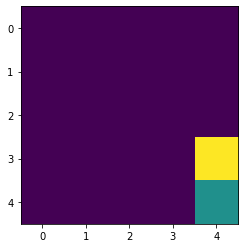

Action: Discrete(4)
Q_table: [[[ 4.0579243  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.88234397 -0.04208223]
  [ 0.36       -0.32699215  3.64838446  0.09753448]
  [ 3.34080039  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94324656 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43711702 -0.5904    ]
  [ 0.         -0.2         1

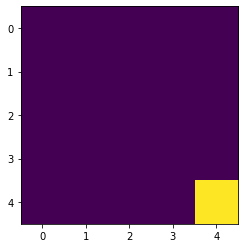

Round 63
Action: Discrete(4)
Q_table: [[[ 4.0579243  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.88234397 -0.04208223]
  [ 0.36       -0.32699215  3.64838446  0.09753448]
  [ 3.34080039  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94324656 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43711702 -0.5904    ]
  [ 0.         -0.2 

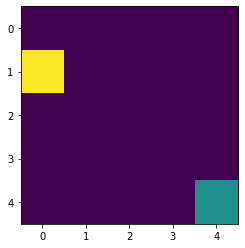

Action: Discrete(4)
Q_table: [[[ 4.06751448 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.88234397 -0.04208223]
  [ 0.36       -0.32699215  3.64838446  0.09753448]
  [ 3.34080039  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94324656 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43711702 -0.5904    ]
  [ 0.         -0.2         1

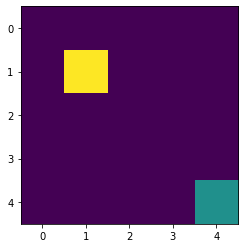

Action: Discrete(4)
Q_table: [[[ 4.06751448 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.88961669 -0.04208223]
  [ 0.36       -0.32699215  3.64838446  0.09753448]
  [ 3.34080039  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94324656 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43711702 -0.5904    ]
  [ 0.         -0.2         1

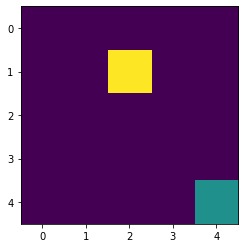

Action: Discrete(4)
Q_table: [[[ 4.06751448 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.88961669 -0.04208223]
  [ 0.36       -0.32699215  3.65323563  0.09753448]
  [ 3.34080039  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94324656 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43711702 -0.5904    ]
  [ 0.         -0.2         1

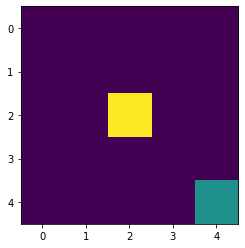

Action: Discrete(4)
Q_table: [[[ 4.06751448 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.88961669 -0.04208223]
  [ 0.36       -0.32699215  3.65323563  0.09753448]
  [ 3.34355976  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94324656 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43711702 -0.5904    ]
  [ 0.         -0.2         1

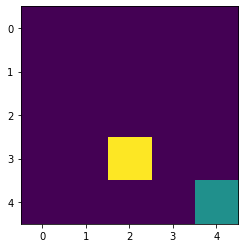

Action: Discrete(4)
Q_table: [[[ 4.06751448 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.88961669 -0.04208223]
  [ 0.36       -0.32699215  3.65323563  0.09753448]
  [ 3.34355976  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94453597 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43711702 -0.5904    ]
  [ 0.         -0.2         1

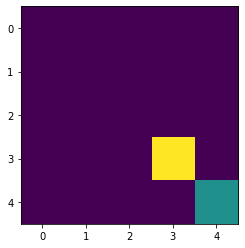

Action: Discrete(4)
Q_table: [[[ 4.06751448 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.88961669 -0.04208223]
  [ 0.36       -0.32699215  3.65323563  0.09753448]
  [ 3.34355976  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94453597 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43758618 -0.5904    ]
  [ 0.         -0.2         1

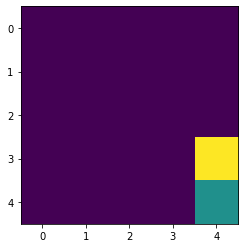

Action: Discrete(4)
Q_table: [[[ 4.06751448 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.88961669 -0.04208223]
  [ 0.36       -0.32699215  3.65323563  0.09753448]
  [ 3.34355976  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94453597 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43758618 -0.5904    ]
  [ 0.         -0.2         1

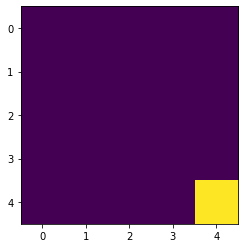

Round 64
Action: Discrete(4)
Q_table: [[[ 4.06751448 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.88961669 -0.04208223]
  [ 0.36       -0.32699215  3.65323563  0.09753448]
  [ 3.34355976  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94453597 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43758618 -0.5904    ]
  [ 0.         -0.2 

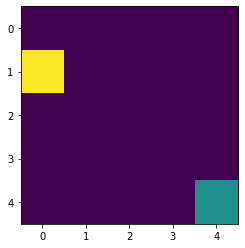

Action: Discrete(4)
Q_table: [[[ 4.07635025 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.88961669 -0.04208223]
  [ 0.36       -0.32699215  3.65323563  0.09753448]
  [ 3.34355976  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94453597 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43758618 -0.5904    ]
  [ 0.         -0.2         1

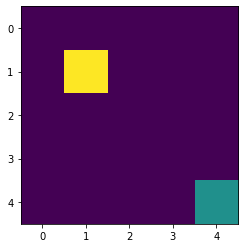

Action: Discrete(4)
Q_table: [[[ 4.07635025 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.89621105 -0.04208223]
  [ 0.36       -0.32699215  3.65323563  0.09753448]
  [ 3.34355976  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94453597 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43758618 -0.5904    ]
  [ 0.         -0.2         1

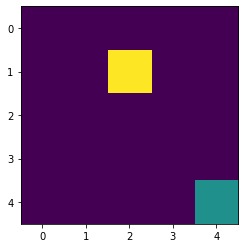

Action: Discrete(4)
Q_table: [[[ 4.07635025 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.89621105 -0.04208223]
  [ 0.36       -0.32699215  3.65755807  0.09753448]
  [ 3.34355976  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94453597 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43758618 -0.5904    ]
  [ 0.         -0.2         1

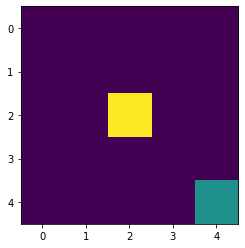

Action: Discrete(4)
Q_table: [[[ 4.07635025 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.89621105 -0.04208223]
  [ 0.36       -0.32699215  3.65755807  0.09753448]
  [ 3.34597356  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94453597 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43758618 -0.5904    ]
  [ 0.         -0.2         1

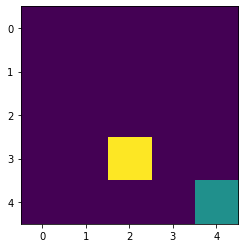

Action: Discrete(4)
Q_table: [[[ 4.07635025 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.89621105 -0.04208223]
  [ 0.36       -0.32699215  3.65755807  0.09753448]
  [ 3.34597356  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94564257 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43758618 -0.5904    ]
  [ 0.         -0.2         1

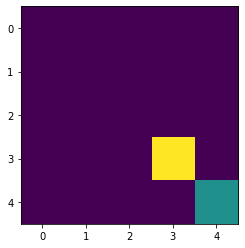

Action: Discrete(4)
Q_table: [[[ 4.07635025 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.89621105 -0.04208223]
  [ 0.36       -0.32699215  3.65755807  0.09753448]
  [ 3.34597356  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94564257 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43798082 -0.5904    ]
  [ 0.         -0.2         1

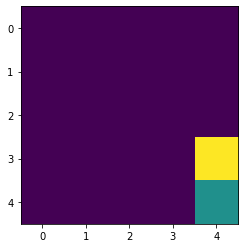

Action: Discrete(4)
Q_table: [[[ 4.07635025 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.89621105 -0.04208223]
  [ 0.36       -0.32699215  3.65755807  0.09753448]
  [ 3.34597356  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94564257 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43798082 -0.5904    ]
  [ 0.         -0.2         1

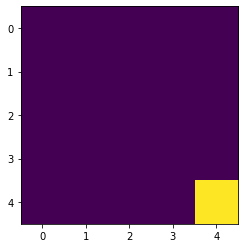

Round 65
Action: Discrete(4)
Q_table: [[[ 4.07635025 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.89621105 -0.04208223]
  [ 0.36       -0.32699215  3.65755807  0.09753448]
  [ 3.34597356  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94564257 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43798082 -0.5904    ]
  [ 0.         -0.2 

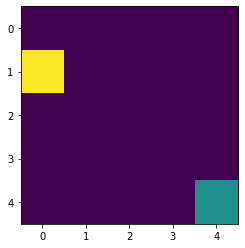

Action: Discrete(4)
Q_table: [[[ 4.08447397 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.89621105 -0.04208223]
  [ 0.36       -0.32699215  3.65755807  0.09753448]
  [ 3.34597356  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94564257 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43798082 -0.5904    ]
  [ 0.         -0.2         1

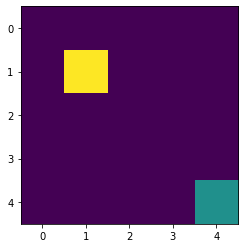

Action: Discrete(4)
Q_table: [[[ 4.08447397 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.90217813 -0.04208223]
  [ 0.36       -0.32699215  3.65755807  0.09753448]
  [ 3.34597356  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94564257 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43798082 -0.5904    ]
  [ 0.         -0.2         1

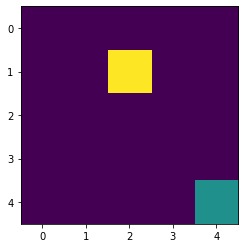

Action: Discrete(4)
Q_table: [[[ 4.08447397 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.90217813 -0.04208223]
  [ 0.36       -0.32699215  3.66140222  0.09753448]
  [ 3.34597356  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94564257 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43798082 -0.5904    ]
  [ 0.         -0.2         1

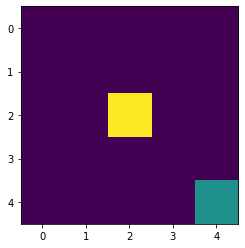

Action: Discrete(4)
Q_table: [[[ 4.08447397 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.90217813 -0.04208223]
  [ 0.36       -0.32699215  3.66140222  0.09753448]
  [ 3.34808166  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94564257 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43798082 -0.5904    ]
  [ 0.         -0.2         1

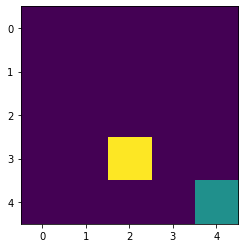

Action: Discrete(4)
Q_table: [[[ 4.08447397 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.90217813 -0.04208223]
  [ 0.36       -0.32699215  3.66140222  0.09753448]
  [ 3.34808166  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94659098 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43798082 -0.5904    ]
  [ 0.         -0.2         1

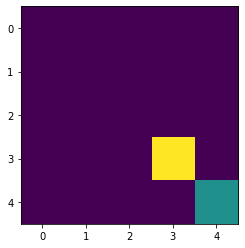

Action: Discrete(4)
Q_table: [[[ 4.08447397 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.90217813 -0.04208223]
  [ 0.36       -0.32699215  3.66140222  0.09753448]
  [ 3.34808166  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94659098 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43831241 -0.5904    ]
  [ 0.         -0.2         1

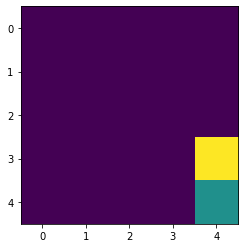

Action: Discrete(4)
Q_table: [[[ 4.08447397 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.90217813 -0.04208223]
  [ 0.36       -0.32699215  3.66140222  0.09753448]
  [ 3.34808166  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94659098 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43831241 -0.5904    ]
  [ 0.         -0.2         1

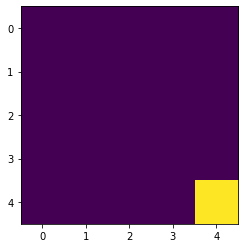

Round 66
Action: Discrete(4)
Q_table: [[[ 4.08447397 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.90217813 -0.04208223]
  [ 0.36       -0.32699215  3.66140222  0.09753448]
  [ 3.34808166  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94659098 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43831241 -0.5904    ]
  [ 0.         -0.2 

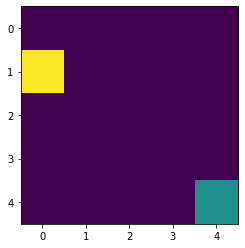

Action: Discrete(4)
Q_table: [[[ 4.09192768 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.90217813 -0.04208223]
  [ 0.36       -0.32699215  3.66140222  0.09753448]
  [ 3.34808166  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94659098 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43831241 -0.5904    ]
  [ 0.         -0.2         1

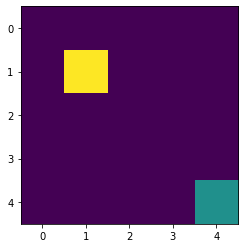

Action: Discrete(4)
Q_table: [[[ 4.09192768 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.90756686 -0.04208223]
  [ 0.36       -0.32699215  3.66140222  0.09753448]
  [ 3.34808166  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94659098 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43831241 -0.5904    ]
  [ 0.         -0.2         1

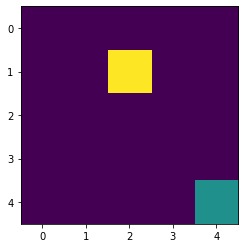

Action: Discrete(4)
Q_table: [[[ 4.09192768 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.90756686 -0.04208223]
  [ 0.36       -0.32699215  3.66481484  0.09753448]
  [ 3.34808166  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94659098 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43831241 -0.5904    ]
  [ 0.         -0.2         1

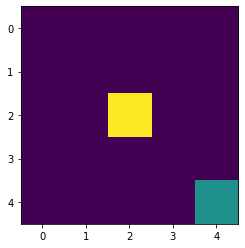

Action: Discrete(4)
Q_table: [[[ 4.09192768 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.90756686 -0.04208223]
  [ 0.36       -0.32699215  3.66481484  0.09753448]
  [ 3.34991989  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94659098 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43831241 -0.5904    ]
  [ 0.         -0.2         1

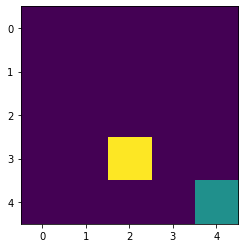

Action: Discrete(4)
Q_table: [[[ 4.09192768 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.90756686 -0.04208223]
  [ 0.36       -0.32699215  3.66481484  0.09753448]
  [ 3.34991989  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94740277 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43831241 -0.5904    ]
  [ 0.         -0.2         1

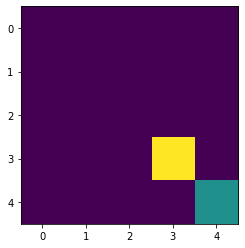

Action: Discrete(4)
Q_table: [[[ 4.09192768 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.90756686 -0.04208223]
  [ 0.36       -0.32699215  3.66481484  0.09753448]
  [ 3.34991989  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94740277 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43859074 -0.5904    ]
  [ 0.         -0.2         1

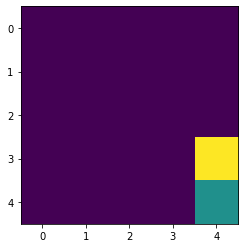

Action: Discrete(4)
Q_table: [[[ 4.09192768 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.90756686 -0.04208223]
  [ 0.36       -0.32699215  3.66481484  0.09753448]
  [ 3.34991989  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94740277 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43859074 -0.5904    ]
  [ 0.         -0.2         1

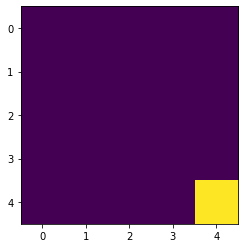

Round 67
Action: Discrete(4)
Q_table: [[[ 4.09192768 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.90756686 -0.04208223]
  [ 0.36       -0.32699215  3.66481484  0.09753448]
  [ 3.34991989  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94740277 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43859074 -0.5904    ]
  [ 0.         -0.2 

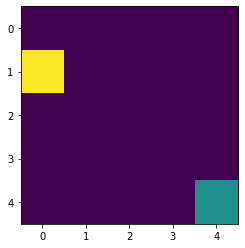

Action: Discrete(4)
Q_table: [[[ 4.09875284 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.90756686 -0.04208223]
  [ 0.36       -0.32699215  3.66481484  0.09753448]
  [ 3.34991989  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94740277 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43859074 -0.5904    ]
  [ 0.         -0.2         1

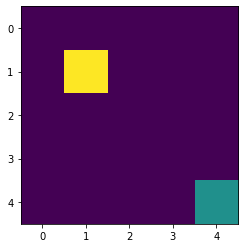

Action: Discrete(4)
Q_table: [[[ 4.09875284 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.91242386 -0.04208223]
  [ 0.36       -0.32699215  3.66481484  0.09753448]
  [ 3.34991989  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94740277 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43859074 -0.5904    ]
  [ 0.         -0.2         1

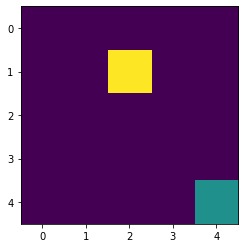

Action: Discrete(4)
Q_table: [[[ 4.09875284 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.91242386 -0.04208223]
  [ 0.36       -0.32699215  3.66783906  0.09753448]
  [ 3.34991989  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94740277 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43859074 -0.5904    ]
  [ 0.         -0.2         1

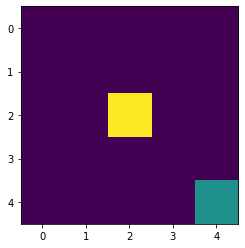

Action: Discrete(4)
Q_table: [[[ 4.09875284 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.91242386 -0.04208223]
  [ 0.36       -0.32699215  3.66783906  0.09753448]
  [ 3.35152035  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94740277 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43859074 -0.5904    ]
  [ 0.         -0.2         1

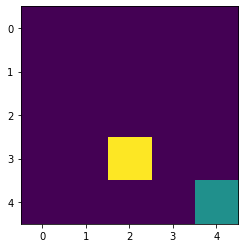

Action: Discrete(4)
Q_table: [[[ 4.09875284 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.91242386 -0.04208223]
  [ 0.36       -0.32699215  3.66783906  0.09753448]
  [ 3.35152035  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94809674 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43859074 -0.5904    ]
  [ 0.         -0.2         1

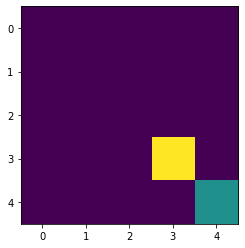

Action: Discrete(4)
Q_table: [[[ 4.09875284 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.91242386 -0.04208223]
  [ 0.36       -0.32699215  3.66783906  0.09753448]
  [ 3.35152035  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94809674 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43882412 -0.5904    ]
  [ 0.         -0.2         1

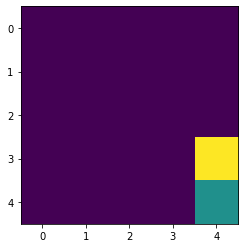

Action: Discrete(4)
Q_table: [[[ 4.09875284 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.91242386 -0.04208223]
  [ 0.36       -0.32699215  3.66783906  0.09753448]
  [ 3.35152035  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94809674 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43882412 -0.5904    ]
  [ 0.         -0.2         1

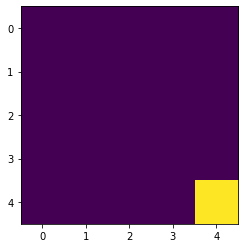

Round 68
Action: Discrete(4)
Q_table: [[[ 4.09875284 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.91242386 -0.04208223]
  [ 0.36       -0.32699215  3.66783906  0.09753448]
  [ 3.35152035  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94809674 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43882412 -0.5904    ]
  [ 0.         -0.2 

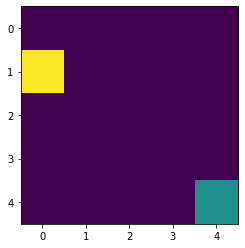

Action: Discrete(4)
Q_table: [[[ 4.10499009 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.91242386 -0.04208223]
  [ 0.36       -0.32699215  3.66783906  0.09753448]
  [ 3.35152035  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94809674 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43882412 -0.5904    ]
  [ 0.         -0.2         1

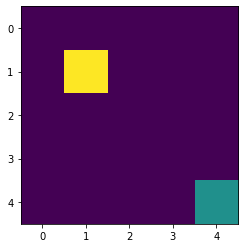

Action: Discrete(4)
Q_table: [[[ 4.10499009 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.91679334 -0.04208223]
  [ 0.36       -0.32699215  3.66783906  0.09753448]
  [ 3.35152035  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94809674 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43882412 -0.5904    ]
  [ 0.         -0.2         1

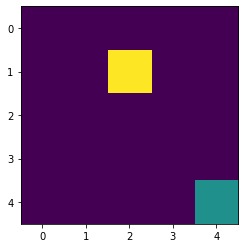

Action: Discrete(4)
Q_table: [[[ 4.10499009 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.91679334 -0.04208223]
  [ 0.36       -0.32699215  3.6705145   0.09753448]
  [ 3.35152035  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94809674 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43882412 -0.5904    ]
  [ 0.         -0.2         1

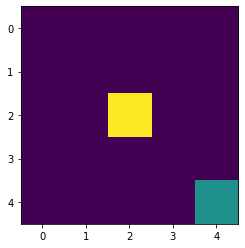

Action: Discrete(4)
Q_table: [[[ 4.10499009 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.91679334 -0.04208223]
  [ 0.36       -0.32699215  3.6705145   0.09753448]
  [ 3.35291176  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94809674 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43882412 -0.5904    ]
  [ 0.         -0.2         1

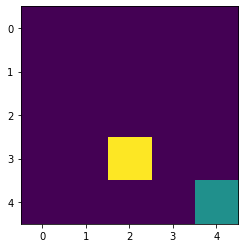

Action: Discrete(4)
Q_table: [[[ 4.10499009 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.91679334 -0.04208223]
  [ 0.36       -0.32699215  3.6705145   0.09753448]
  [ 3.35291176  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94868925 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43882412 -0.5904    ]
  [ 0.         -0.2         1

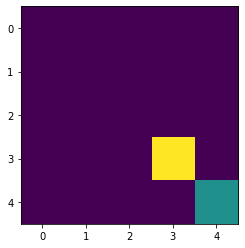

Action: Discrete(4)
Q_table: [[[ 4.10499009 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.91679334 -0.04208223]
  [ 0.36       -0.32699215  3.6705145   0.09753448]
  [ 3.35291176  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94868925 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43901963 -0.5904    ]
  [ 0.         -0.2         1

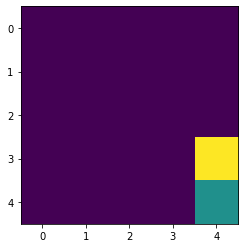

Action: Discrete(4)
Q_table: [[[ 4.10499009 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.91679334 -0.04208223]
  [ 0.36       -0.32699215  3.6705145   0.09753448]
  [ 3.35291176  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94868925 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43901963 -0.5904    ]
  [ 0.         -0.2         1

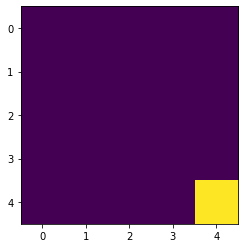

Round 69
Action: Discrete(4)
Q_table: [[[ 4.10499009 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.91679334 -0.04208223]
  [ 0.36       -0.32699215  3.6705145   0.09753448]
  [ 3.35291176  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94868925 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43901963 -0.5904    ]
  [ 0.         -0.2 

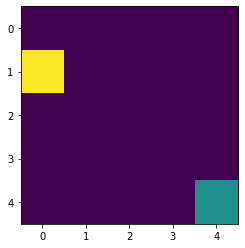

Action: Discrete(4)
Q_table: [[[ 4.11067901 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.91679334 -0.04208223]
  [ 0.36       -0.32699215  3.6705145   0.09753448]
  [ 3.35291176  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94868925 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43901963 -0.5904    ]
  [ 0.         -0.2         1

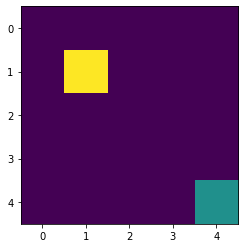

Action: Discrete(4)
Q_table: [[[ 4.11067901 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.92071699 -0.04208223]
  [ 0.36       -0.32699215  3.6705145   0.09753448]
  [ 3.35291176  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94868925 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43901963 -0.5904    ]
  [ 0.         -0.2         1

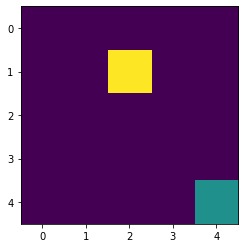

Action: Discrete(4)
Q_table: [[[ 4.11067901 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.92071699 -0.04208223]
  [ 0.36       -0.32699215  3.67287748  0.09753448]
  [ 3.35291176  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94868925 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43901963 -0.5904    ]
  [ 0.         -0.2         1

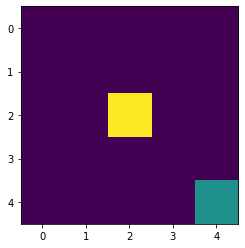

Action: Discrete(4)
Q_table: [[[ 4.11067901 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.92071699 -0.04208223]
  [ 0.36       -0.32699215  3.67287748  0.09753448]
  [ 3.35411969  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94868925 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43901963 -0.5904    ]
  [ 0.         -0.2         1

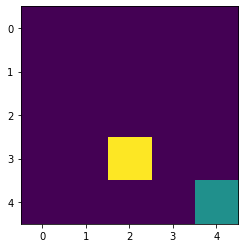

Action: Discrete(4)
Q_table: [[[ 4.11067901 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.92071699 -0.04208223]
  [ 0.36       -0.32699215  3.67287748  0.09753448]
  [ 3.35411969  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94919454 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43901963 -0.5904    ]
  [ 0.         -0.2         1

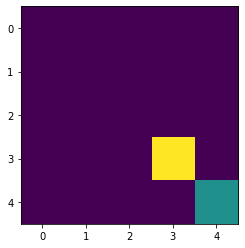

Action: Discrete(4)
Q_table: [[[ 4.11067901 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.92071699 -0.04208223]
  [ 0.36       -0.32699215  3.67287748  0.09753448]
  [ 3.35411969  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94919454 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43918326 -0.5904    ]
  [ 0.         -0.2         1

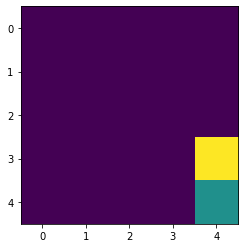

Action: Discrete(4)
Q_table: [[[ 4.11067901 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.92071699 -0.04208223]
  [ 0.36       -0.32699215  3.67287748  0.09753448]
  [ 3.35411969  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94919454 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43918326 -0.5904    ]
  [ 0.         -0.2         1

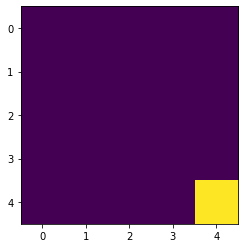

Round 70
Action: Discrete(4)
Q_table: [[[ 4.11067901 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.92071699 -0.04208223]
  [ 0.36       -0.32699215  3.67287748  0.09753448]
  [ 3.35411969  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94919454 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43918326 -0.5904    ]
  [ 0.         -0.2 

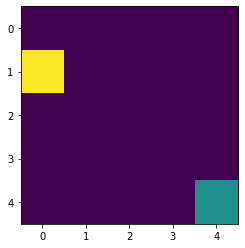

Action: Discrete(4)
Q_table: [[[ 4.11585792 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.92071699 -0.04208223]
  [ 0.36       -0.32699215  3.67287748  0.09753448]
  [ 3.35411969  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94919454 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43918326 -0.5904    ]
  [ 0.         -0.2         1

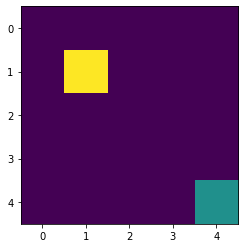

Action: Discrete(4)
Q_table: [[[ 4.11585792 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.92423399 -0.04208223]
  [ 0.36       -0.32699215  3.67287748  0.09753448]
  [ 3.35411969  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94919454 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43918326 -0.5904    ]
  [ 0.         -0.2         1

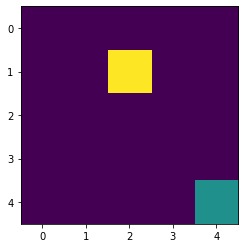

Action: Discrete(4)
Q_table: [[[ 4.11585792 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.92423399 -0.04208223]
  [ 0.36       -0.32699215  3.67496114  0.09753448]
  [ 3.35411969  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94919454 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43918326 -0.5904    ]
  [ 0.         -0.2         1

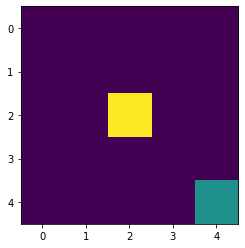

Action: Discrete(4)
Q_table: [[[ 4.11585792 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.92423399 -0.04208223]
  [ 0.36       -0.32699215  3.67496114  0.09753448]
  [ 3.35516688  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94919454 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43918326 -0.5904    ]
  [ 0.         -0.2         1

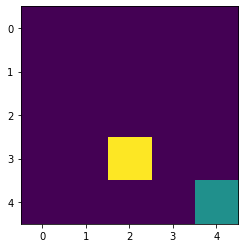

Action: Discrete(4)
Q_table: [[[ 4.11585792 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.92423399 -0.04208223]
  [ 0.36       -0.32699215  3.67496114  0.09753448]
  [ 3.35516688  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94962495 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43918326 -0.5904    ]
  [ 0.         -0.2         1

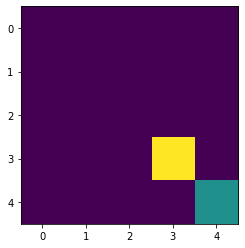

Action: Discrete(4)
Q_table: [[[ 4.11585792 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.92423399 -0.04208223]
  [ 0.36       -0.32699215  3.67496114  0.09753448]
  [ 3.35516688  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94962495 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43932008 -0.5904    ]
  [ 0.         -0.2         1

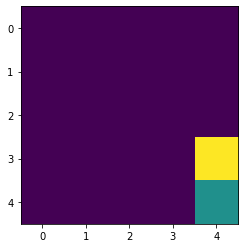

Action: Discrete(4)
Q_table: [[[ 4.11585792 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.92423399 -0.04208223]
  [ 0.36       -0.32699215  3.67496114  0.09753448]
  [ 3.35516688  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94962495 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43932008 -0.5904    ]
  [ 0.         -0.2         1

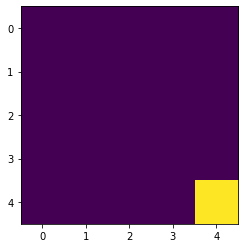

Round 71
Action: Discrete(4)
Q_table: [[[ 4.11585792 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.92423399 -0.04208223]
  [ 0.36       -0.32699215  3.67496114  0.09753448]
  [ 3.35516688  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94962495 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43932008 -0.5904    ]
  [ 0.         -0.2 

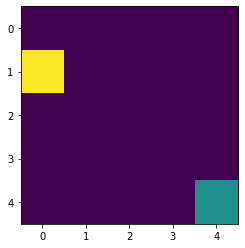

Action: Discrete(4)
Q_table: [[[ 4.12056378 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.92423399 -0.04208223]
  [ 0.36       -0.32699215  3.67496114  0.09753448]
  [ 3.35516688  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94962495 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43932008 -0.5904    ]
  [ 0.         -0.2         1

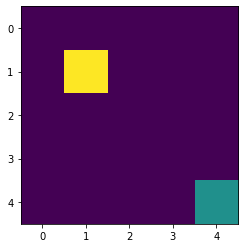

Action: Discrete(4)
Q_table: [[[ 4.12056378 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.92738097 -0.04208223]
  [ 0.36       -0.32699215  3.67496114  0.09753448]
  [ 3.35516688  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94962495 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43932008 -0.5904    ]
  [ 0.         -0.2         1

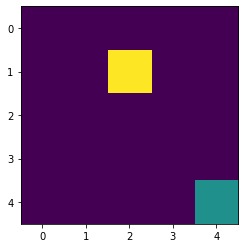

Action: Discrete(4)
Q_table: [[[ 4.12056378 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.92738097 -0.04208223]
  [ 0.36       -0.32699215  3.67679561  0.09753448]
  [ 3.35516688  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94962495 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43932008 -0.5904    ]
  [ 0.         -0.2         1

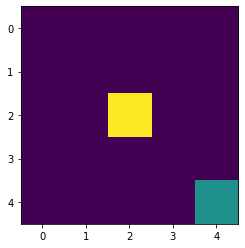

Action: Discrete(4)
Q_table: [[[ 4.12056378 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.92738097 -0.04208223]
  [ 0.36       -0.32699215  3.67679561  0.09753448]
  [ 3.35607349  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94962495 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43932008 -0.5904    ]
  [ 0.         -0.2         1

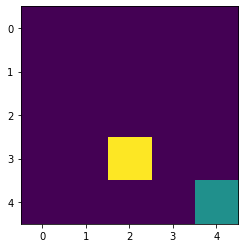

Action: Discrete(4)
Q_table: [[[ 4.12056378 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.92738097 -0.04208223]
  [ 0.36       -0.32699215  3.67679561  0.09753448]
  [ 3.35607349  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94999118 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43932008 -0.5904    ]
  [ 0.         -0.2         1

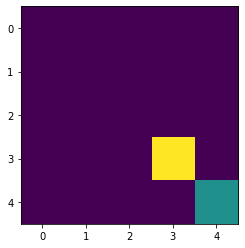

Action: Discrete(4)
Q_table: [[[ 4.12056378 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.92738097 -0.04208223]
  [ 0.36       -0.32699215  3.67679561  0.09753448]
  [ 3.35607349  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94999118 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43943439 -0.5904    ]
  [ 0.         -0.2         1

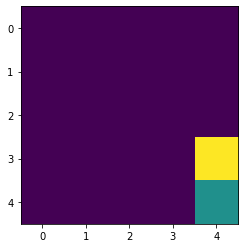

Action: Discrete(4)
Q_table: [[[ 4.12056378 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.92738097 -0.04208223]
  [ 0.36       -0.32699215  3.67679561  0.09753448]
  [ 3.35607349  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94999118 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43943439 -0.5904    ]
  [ 0.         -0.2         1

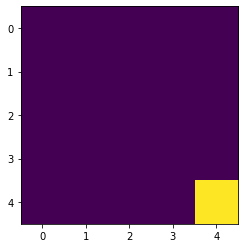

Round 72
Action: Discrete(4)
Q_table: [[[ 4.12056378 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.92738097 -0.04208223]
  [ 0.36       -0.32699215  3.67679561  0.09753448]
  [ 3.35607349  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94999118 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43943439 -0.5904    ]
  [ 0.         -0.2 

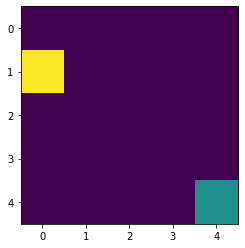

Action: Discrete(4)
Q_table: [[[ 4.12483198 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.92738097 -0.04208223]
  [ 0.36       -0.32699215  3.67679561  0.09753448]
  [ 3.35607349  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94999118 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43943439 -0.5904    ]
  [ 0.         -0.2         1

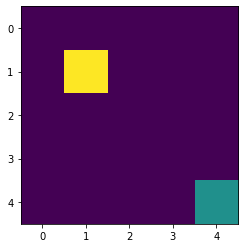

Action: Discrete(4)
Q_table: [[[ 4.12483198 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93019208 -0.04208223]
  [ 0.36       -0.32699215  3.67679561  0.09753448]
  [ 3.35607349  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94999118 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43943439 -0.5904    ]
  [ 0.         -0.2         1

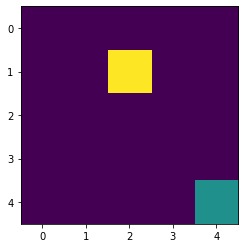

Action: Discrete(4)
Q_table: [[[ 4.12483198 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93019208 -0.04208223]
  [ 0.36       -0.32699215  3.67840825  0.09753448]
  [ 3.35607349  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94999118 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43943439 -0.5904    ]
  [ 0.         -0.2         1

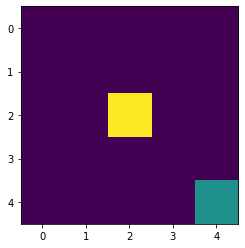

Action: Discrete(4)
Q_table: [[[ 4.12483198 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93019208 -0.04208223]
  [ 0.36       -0.32699215  3.67840825  0.09753448]
  [ 3.35685738  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.94999118 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43943439 -0.5904    ]
  [ 0.         -0.2         1

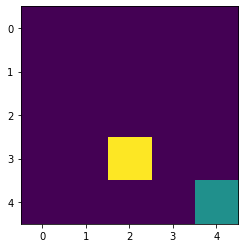

Action: Discrete(4)
Q_table: [[[ 4.12483198 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93019208 -0.04208223]
  [ 0.36       -0.32699215  3.67840825  0.09753448]
  [ 3.35685738  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95030244 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43943439 -0.5904    ]
  [ 0.         -0.2         1

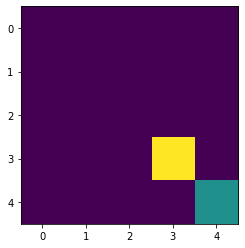

Action: Discrete(4)
Q_table: [[[ 4.12483198 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93019208 -0.04208223]
  [ 0.36       -0.32699215  3.67840825  0.09753448]
  [ 3.35685738  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95030244 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4395298  -0.5904    ]
  [ 0.         -0.2         1

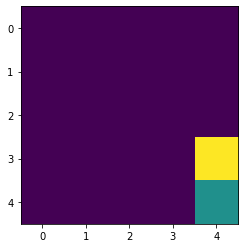

Action: Discrete(4)
Q_table: [[[ 4.12483198 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93019208 -0.04208223]
  [ 0.36       -0.32699215  3.67840825  0.09753448]
  [ 3.35685738  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95030244 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4395298  -0.5904    ]
  [ 0.         -0.2         1

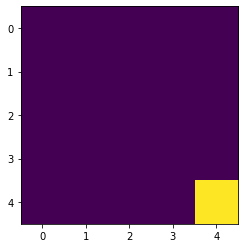

Round 73
Action: Discrete(4)
Q_table: [[[ 4.12483198 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93019208 -0.04208223]
  [ 0.36       -0.32699215  3.67840825  0.09753448]
  [ 3.35685738  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95030244 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4395298  -0.5904    ]
  [ 0.         -0.2 

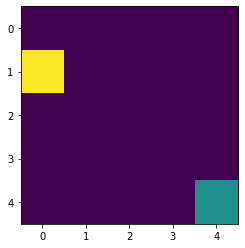

Action: Discrete(4)
Q_table: [[[ 4.12869632 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93019208 -0.04208223]
  [ 0.36       -0.32699215  3.67840825  0.09753448]
  [ 3.35685738  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95030244 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4395298  -0.5904    ]
  [ 0.         -0.2         1

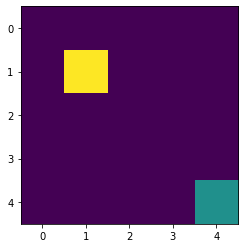

Action: Discrete(4)
Q_table: [[[ 4.12869632 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93269898 -0.04208223]
  [ 0.36       -0.32699215  3.67840825  0.09753448]
  [ 3.35685738  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95030244 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4395298  -0.5904    ]
  [ 0.         -0.2         1

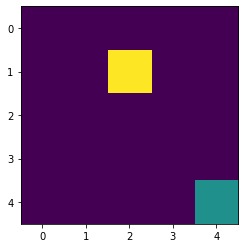

Action: Discrete(4)
Q_table: [[[ 4.12869632 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93269898 -0.04208223]
  [ 0.36       -0.32699215  3.67982378  0.09753448]
  [ 3.35685738  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95030244 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4395298  -0.5904    ]
  [ 0.         -0.2         1

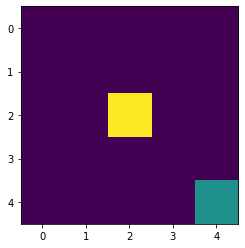

Action: Discrete(4)
Q_table: [[[ 4.12869632 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93269898 -0.04208223]
  [ 0.36       -0.32699215  3.67982378  0.09753448]
  [ 3.3575343   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95030244 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4395298  -0.5904    ]
  [ 0.         -0.2         1

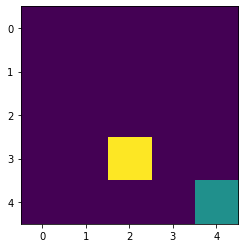

Action: Discrete(4)
Q_table: [[[ 4.12869632 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93269898 -0.04208223]
  [ 0.36       -0.32699215  3.67982378  0.09753448]
  [ 3.3575343   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95056672 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4395298  -0.5904    ]
  [ 0.         -0.2         1

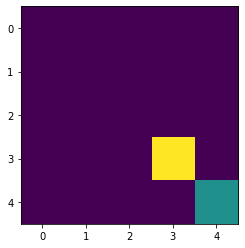

Action: Discrete(4)
Q_table: [[[ 4.12869632 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93269898 -0.04208223]
  [ 0.36       -0.32699215  3.67982378  0.09753448]
  [ 3.3575343   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95056672 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43960938 -0.5904    ]
  [ 0.         -0.2         1

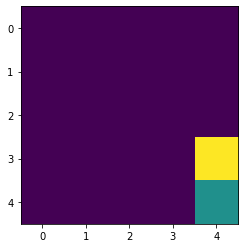

Action: Discrete(4)
Q_table: [[[ 4.12869632 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93269898 -0.04208223]
  [ 0.36       -0.32699215  3.67982378  0.09753448]
  [ 3.3575343   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95056672 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43960938 -0.5904    ]
  [ 0.         -0.2         1

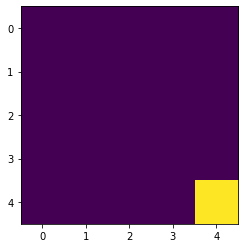

Round 74
Action: Discrete(4)
Q_table: [[[ 4.12869632 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93269898 -0.04208223]
  [ 0.36       -0.32699215  3.67982378  0.09753448]
  [ 3.3575343   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95056672 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43960938 -0.5904    ]
  [ 0.         -0.2 

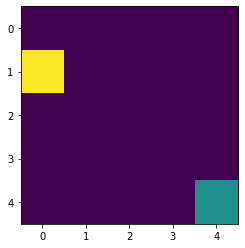

Action: Discrete(4)
Q_table: [[[ 4.13218889 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93269898 -0.04208223]
  [ 0.36       -0.32699215  3.67982378  0.09753448]
  [ 3.3575343   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95056672 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43960938 -0.5904    ]
  [ 0.         -0.2         1

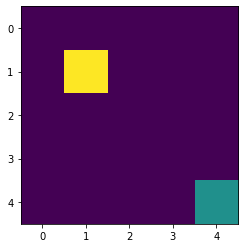

Action: Discrete(4)
Q_table: [[[ 4.13218889 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93493099 -0.04208223]
  [ 0.36       -0.32699215  3.67982378  0.09753448]
  [ 3.3575343   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95056672 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43960938 -0.5904    ]
  [ 0.         -0.2         1

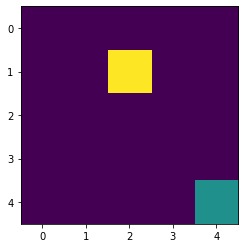

Action: Discrete(4)
Q_table: [[[ 4.13218889 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93493099 -0.04208223]
  [ 0.36       -0.32699215  3.68106451  0.09753448]
  [ 3.3575343   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95056672 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43960938 -0.5904    ]
  [ 0.         -0.2         1

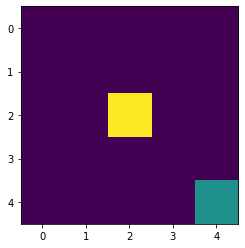

Action: Discrete(4)
Q_table: [[[ 4.13218889 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93493099 -0.04208223]
  [ 0.36       -0.32699215  3.68106451  0.09753448]
  [ 3.35811811  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95056672 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43960938 -0.5904    ]
  [ 0.         -0.2         1

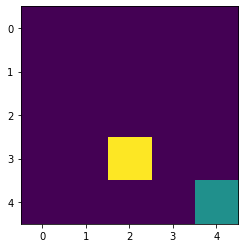

Action: Discrete(4)
Q_table: [[[ 4.13218889 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93493099 -0.04208223]
  [ 0.36       -0.32699215  3.68106451  0.09753448]
  [ 3.35811811  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95079088 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43960938 -0.5904    ]
  [ 0.         -0.2         1

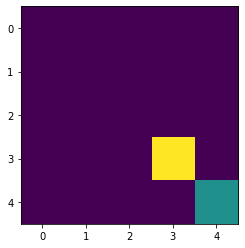

Action: Discrete(4)
Q_table: [[[ 4.13218889 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93493099 -0.04208223]
  [ 0.36       -0.32699215  3.68106451  0.09753448]
  [ 3.35811811  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95079088 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4396757  -0.5904    ]
  [ 0.         -0.2         1

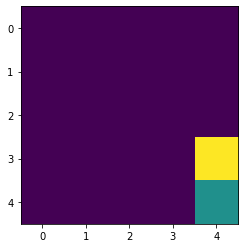

Action: Discrete(4)
Q_table: [[[ 4.13218889 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93493099 -0.04208223]
  [ 0.36       -0.32699215  3.68106451  0.09753448]
  [ 3.35811811  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95079088 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4396757  -0.5904    ]
  [ 0.         -0.2         1

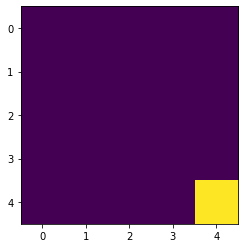

Round 75
Action: Discrete(4)
Q_table: [[[ 4.13218889 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93493099 -0.04208223]
  [ 0.36       -0.32699215  3.68106451  0.09753448]
  [ 3.35811811  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95079088 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4396757  -0.5904    ]
  [ 0.         -0.2 

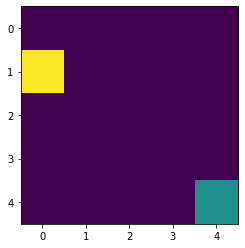

Action: Discrete(4)
Q_table: [[[ 4.13534007 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93493099 -0.04208223]
  [ 0.36       -0.32699215  3.68106451  0.09753448]
  [ 3.35811811  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95079088 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4396757  -0.5904    ]
  [ 0.         -0.2         1

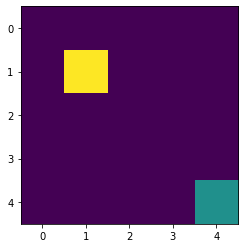

Action: Discrete(4)
Q_table: [[[ 4.13534007 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93691511 -0.04208223]
  [ 0.36       -0.32699215  3.68106451  0.09753448]
  [ 3.35811811  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95079088 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4396757  -0.5904    ]
  [ 0.         -0.2         1

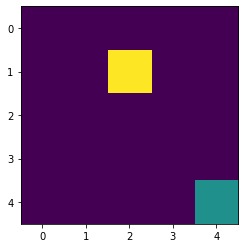

Action: Discrete(4)
Q_table: [[[ 4.13534007 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93691511 -0.04208223]
  [ 0.36       -0.32699215  3.68215051  0.09753448]
  [ 3.35811811  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95079088 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4396757  -0.5904    ]
  [ 0.         -0.2         1

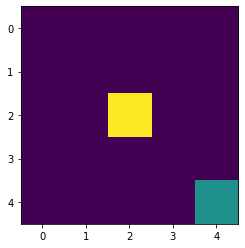

Action: Discrete(4)
Q_table: [[[ 4.13534007 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93691511 -0.04208223]
  [ 0.36       -0.32699215  3.68215051  0.09753448]
  [ 3.35862103  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95079088 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4396757  -0.5904    ]
  [ 0.         -0.2         1

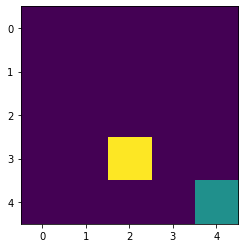

Action: Discrete(4)
Q_table: [[[ 4.13534007 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93691511 -0.04208223]
  [ 0.36       -0.32699215  3.68215051  0.09753448]
  [ 3.35862103  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95098082 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4396757  -0.5904    ]
  [ 0.         -0.2         1

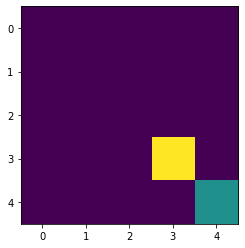

Action: Discrete(4)
Q_table: [[[ 4.13534007 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93691511 -0.04208223]
  [ 0.36       -0.32699215  3.68215051  0.09753448]
  [ 3.35862103  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95098082 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43973094 -0.5904    ]
  [ 0.         -0.2         1

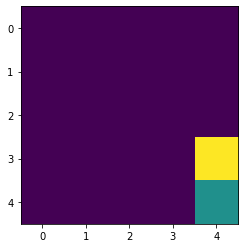

Action: Discrete(4)
Q_table: [[[ 4.13534007 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93691511 -0.04208223]
  [ 0.36       -0.32699215  3.68215051  0.09753448]
  [ 3.35862103  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95098082 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43973094 -0.5904    ]
  [ 0.         -0.2         1

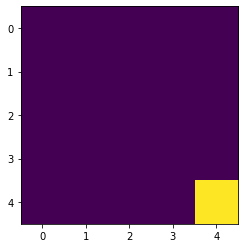

Round 76
Action: Discrete(4)
Q_table: [[[ 4.13534007 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93691511 -0.04208223]
  [ 0.36       -0.32699215  3.68215051  0.09753448]
  [ 3.35862103  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95098082 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43973094 -0.5904    ]
  [ 0.         -0.2 

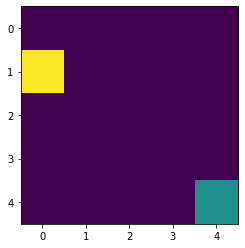

Action: Discrete(4)
Q_table: [[[ 4.13817847 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93691511 -0.04208223]
  [ 0.36       -0.32699215  3.68215051  0.09753448]
  [ 3.35862103  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95098082 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43973094 -0.5904    ]
  [ 0.         -0.2         1

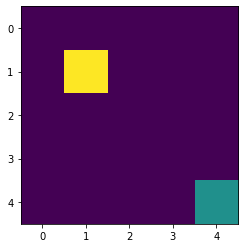

Action: Discrete(4)
Q_table: [[[ 4.13817847 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93867617 -0.04208223]
  [ 0.36       -0.32699215  3.68215051  0.09753448]
  [ 3.35862103  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95098082 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43973094 -0.5904    ]
  [ 0.         -0.2         1

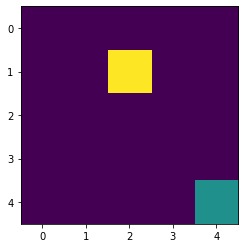

Action: Discrete(4)
Q_table: [[[ 4.13817847 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93867617 -0.04208223]
  [ 0.36       -0.32699215  3.68309977  0.09753448]
  [ 3.35862103  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95098082 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43973094 -0.5904    ]
  [ 0.         -0.2         1

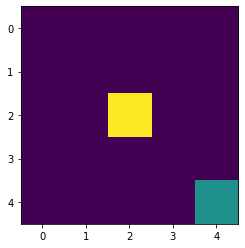

Action: Discrete(4)
Q_table: [[[ 4.13817847 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93867617 -0.04208223]
  [ 0.36       -0.32699215  3.68309977  0.09753448]
  [ 3.35905376  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95098082 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43973094 -0.5904    ]
  [ 0.         -0.2         1

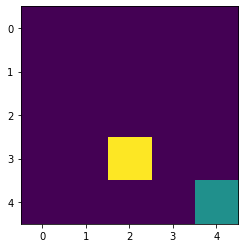

Action: Discrete(4)
Q_table: [[[ 4.13817847 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93867617 -0.04208223]
  [ 0.36       -0.32699215  3.68309977  0.09753448]
  [ 3.35905376  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9511416  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43973094 -0.5904    ]
  [ 0.         -0.2         1

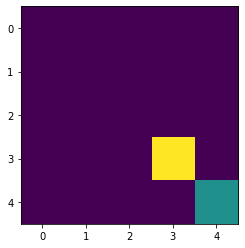

Action: Discrete(4)
Q_table: [[[ 4.13817847 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93867617 -0.04208223]
  [ 0.36       -0.32699215  3.68309977  0.09753448]
  [ 3.35905376  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9511416  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4397769  -0.5904    ]
  [ 0.         -0.2         1

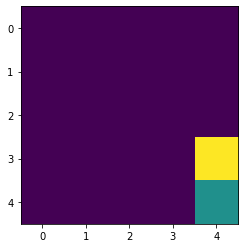

Action: Discrete(4)
Q_table: [[[ 4.13817847 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93867617 -0.04208223]
  [ 0.36       -0.32699215  3.68309977  0.09753448]
  [ 3.35905376  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9511416  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4397769  -0.5904    ]
  [ 0.         -0.2         1

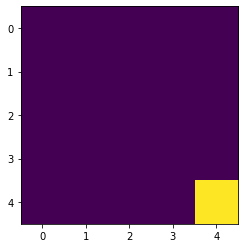

Round 77
Action: Discrete(4)
Q_table: [[[ 4.13817847 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93867617 -0.04208223]
  [ 0.36       -0.32699215  3.68309977  0.09753448]
  [ 3.35905376  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9511416  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4397769  -0.5904    ]
  [ 0.         -0.2 

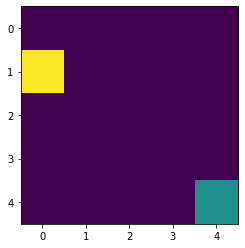

Action: Discrete(4)
Q_table: [[[ 4.14073097 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.93867617 -0.04208223]
  [ 0.36       -0.32699215  3.68309977  0.09753448]
  [ 3.35905376  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9511416  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4397769  -0.5904    ]
  [ 0.         -0.2         1

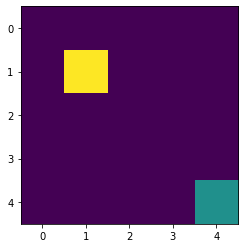

Action: Discrete(4)
Q_table: [[[ 4.14073097 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.9402369  -0.04208223]
  [ 0.36       -0.32699215  3.68309977  0.09753448]
  [ 3.35905376  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9511416  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4397769  -0.5904    ]
  [ 0.         -0.2         1

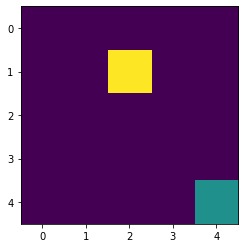

Action: Discrete(4)
Q_table: [[[ 4.14073097 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.9402369  -0.04208223]
  [ 0.36       -0.32699215  3.68392842  0.09753448]
  [ 3.35905376  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9511416  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4397769  -0.5904    ]
  [ 0.         -0.2         1

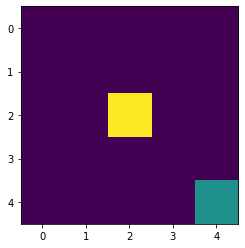

Action: Discrete(4)
Q_table: [[[ 4.14073097 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.9402369  -0.04208223]
  [ 0.36       -0.32699215  3.68392842  0.09753448]
  [ 3.35942566  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9511416  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4397769  -0.5904    ]
  [ 0.         -0.2         1

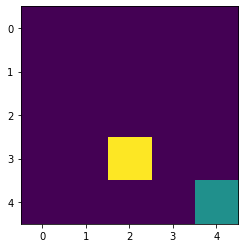

Action: Discrete(4)
Q_table: [[[ 4.14073097 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.9402369  -0.04208223]
  [ 0.36       -0.32699215  3.68392842  0.09753448]
  [ 3.35942566  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95127759 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4397769  -0.5904    ]
  [ 0.         -0.2         1

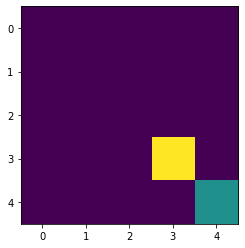

Action: Discrete(4)
Q_table: [[[ 4.14073097 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.9402369  -0.04208223]
  [ 0.36       -0.32699215  3.68392842  0.09753448]
  [ 3.35942566  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95127759 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43981512 -0.5904    ]
  [ 0.         -0.2         1

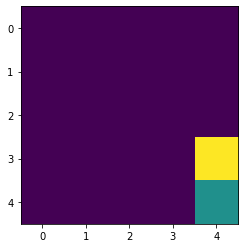

Action: Discrete(4)
Q_table: [[[ 4.14073097 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.9402369  -0.04208223]
  [ 0.36       -0.32699215  3.68392842  0.09753448]
  [ 3.35942566  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95127759 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43981512 -0.5904    ]
  [ 0.         -0.2         1

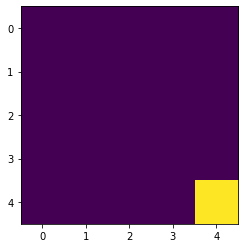

Round 78
Action: Discrete(4)
Q_table: [[[ 4.14073097 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.9402369  -0.04208223]
  [ 0.36       -0.32699215  3.68392842  0.09753448]
  [ 3.35942566  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95127759 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43981512 -0.5904    ]
  [ 0.         -0.2 

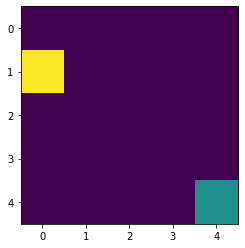

Action: Discrete(4)
Q_table: [[[ 4.14302268 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.9402369  -0.04208223]
  [ 0.36       -0.32699215  3.68392842  0.09753448]
  [ 3.35942566  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95127759 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43981512 -0.5904    ]
  [ 0.         -0.2         1

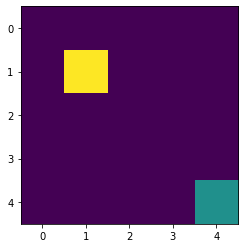

Action: Discrete(4)
Q_table: [[[ 4.14302268 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94161807 -0.04208223]
  [ 0.36       -0.32699215  3.68392842  0.09753448]
  [ 3.35942566  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95127759 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43981512 -0.5904    ]
  [ 0.         -0.2         1

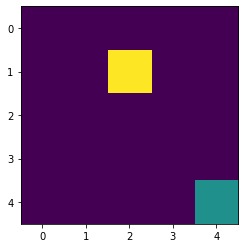

Action: Discrete(4)
Q_table: [[[ 4.14302268 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94161807 -0.04208223]
  [ 0.36       -0.32699215  3.68465084  0.09753448]
  [ 3.35942566  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95127759 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43981512 -0.5904    ]
  [ 0.         -0.2         1

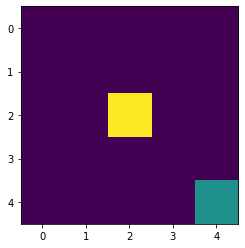

Action: Discrete(4)
Q_table: [[[ 4.14302268 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94161807 -0.04208223]
  [ 0.36       -0.32699215  3.68465084  0.09753448]
  [ 3.35974494  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95127759 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43981512 -0.5904    ]
  [ 0.         -0.2         1

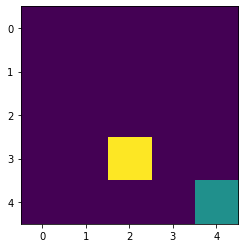

Action: Discrete(4)
Q_table: [[[ 4.14302268 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94161807 -0.04208223]
  [ 0.36       -0.32699215  3.68465084  0.09753448]
  [ 3.35974494  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95139249 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43981512 -0.5904    ]
  [ 0.         -0.2         1

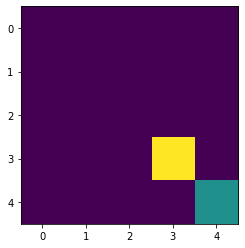

Action: Discrete(4)
Q_table: [[[ 4.14302268 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94161807 -0.04208223]
  [ 0.36       -0.32699215  3.68465084  0.09753448]
  [ 3.35974494  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95139249 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43984688 -0.5904    ]
  [ 0.         -0.2         1

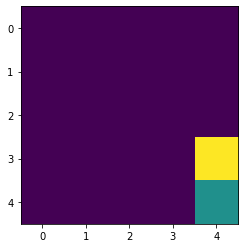

Action: Discrete(4)
Q_table: [[[ 4.14302268 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94161807 -0.04208223]
  [ 0.36       -0.32699215  3.68465084  0.09753448]
  [ 3.35974494  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95139249 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43984688 -0.5904    ]
  [ 0.         -0.2         1

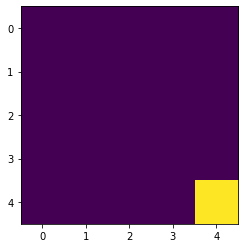

Round 79
Action: Discrete(4)
Q_table: [[[ 4.14302268 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94161807 -0.04208223]
  [ 0.36       -0.32699215  3.68465084  0.09753448]
  [ 3.35974494  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95139249 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43984688 -0.5904    ]
  [ 0.         -0.2 

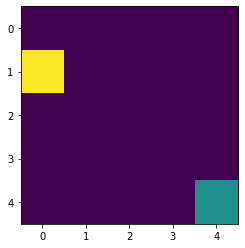

Action: Discrete(4)
Q_table: [[[ 4.14507703 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94161807 -0.04208223]
  [ 0.36       -0.32699215  3.68465084  0.09753448]
  [ 3.35974494  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95139249 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43984688 -0.5904    ]
  [ 0.         -0.2         1

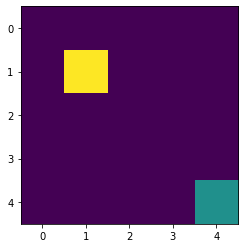

Action: Discrete(4)
Q_table: [[[ 4.14507703 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94283859 -0.04208223]
  [ 0.36       -0.32699215  3.68465084  0.09753448]
  [ 3.35974494  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95139249 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43984688 -0.5904    ]
  [ 0.         -0.2         1

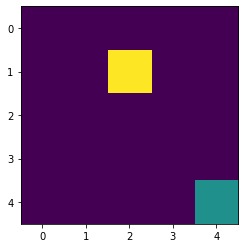

Action: Discrete(4)
Q_table: [[[ 4.14507703 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94283859 -0.04208223]
  [ 0.36       -0.32699215  3.68527986  0.09753448]
  [ 3.35974494  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95139249 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43984688 -0.5904    ]
  [ 0.         -0.2         1

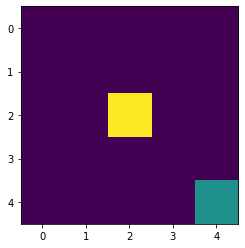

Action: Discrete(4)
Q_table: [[[ 4.14507703 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94283859 -0.04208223]
  [ 0.36       -0.32699215  3.68527986  0.09753448]
  [ 3.36001875  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95139249 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43984688 -0.5904    ]
  [ 0.         -0.2         1

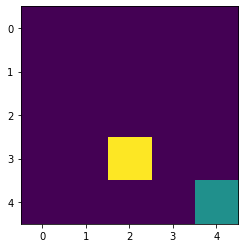

Action: Discrete(4)
Q_table: [[[ 4.14507703 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94283859 -0.04208223]
  [ 0.36       -0.32699215  3.68527986  0.09753448]
  [ 3.36001875  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95148949 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43984688 -0.5904    ]
  [ 0.         -0.2         1

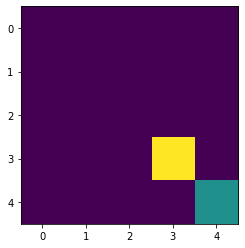

Action: Discrete(4)
Q_table: [[[ 4.14507703 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94283859 -0.04208223]
  [ 0.36       -0.32699215  3.68527986  0.09753448]
  [ 3.36001875  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95148949 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43987325 -0.5904    ]
  [ 0.         -0.2         1

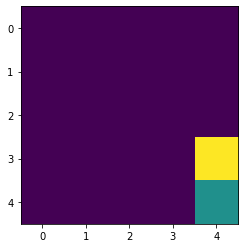

Action: Discrete(4)
Q_table: [[[ 4.14507703 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94283859 -0.04208223]
  [ 0.36       -0.32699215  3.68527986  0.09753448]
  [ 3.36001875  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95148949 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43987325 -0.5904    ]
  [ 0.         -0.2         1

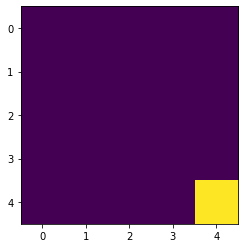

Round 80
Action: Discrete(4)
Q_table: [[[ 4.14507703 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94283859 -0.04208223]
  [ 0.36       -0.32699215  3.68527986  0.09753448]
  [ 3.36001875  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95148949 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43987325 -0.5904    ]
  [ 0.         -0.2 

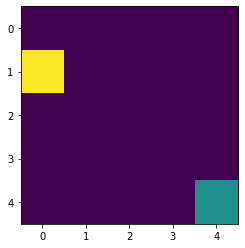

Action: Discrete(4)
Q_table: [[[ 4.1469158  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94283859 -0.04208223]
  [ 0.36       -0.32699215  3.68527986  0.09753448]
  [ 3.36001875  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95148949 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43987325 -0.5904    ]
  [ 0.         -0.2         1

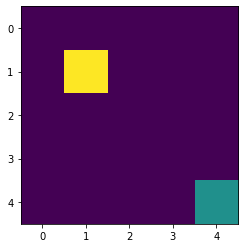

Action: Discrete(4)
Q_table: [[[ 4.1469158  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94391565 -0.04208223]
  [ 0.36       -0.32699215  3.68527986  0.09753448]
  [ 3.36001875  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95148949 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43987325 -0.5904    ]
  [ 0.         -0.2         1

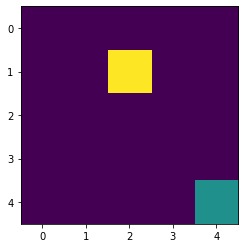

Action: Discrete(4)
Q_table: [[[ 4.1469158  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94391565 -0.04208223]
  [ 0.36       -0.32699215  3.68582689  0.09753448]
  [ 3.36001875  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95148949 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43987325 -0.5904    ]
  [ 0.         -0.2         1

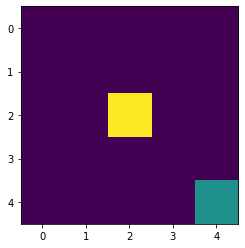

Action: Discrete(4)
Q_table: [[[ 4.1469158  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94391565 -0.04208223]
  [ 0.36       -0.32699215  3.68582689  0.09753448]
  [ 3.36025332  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95148949 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43987325 -0.5904    ]
  [ 0.         -0.2         1

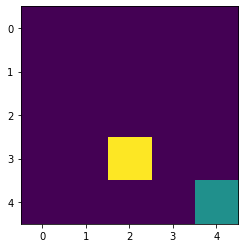

Action: Discrete(4)
Q_table: [[[ 4.1469158  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94391565 -0.04208223]
  [ 0.36       -0.32699215  3.68582689  0.09753448]
  [ 3.36025332  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95157131 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43987325 -0.5904    ]
  [ 0.         -0.2         1

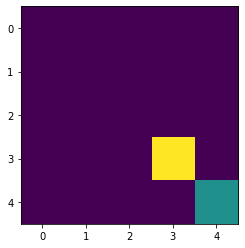

Action: Discrete(4)
Q_table: [[[ 4.1469158  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94391565 -0.04208223]
  [ 0.36       -0.32699215  3.68582689  0.09753448]
  [ 3.36025332  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95157131 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43989514 -0.5904    ]
  [ 0.         -0.2         1

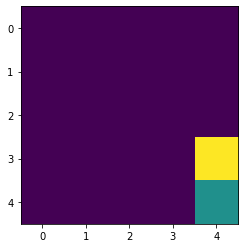

Action: Discrete(4)
Q_table: [[[ 4.1469158  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94391565 -0.04208223]
  [ 0.36       -0.32699215  3.68582689  0.09753448]
  [ 3.36025332  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95157131 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43989514 -0.5904    ]
  [ 0.         -0.2         1

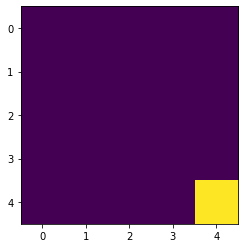

Round 81
Action: Discrete(4)
Q_table: [[[ 4.1469158  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94391565 -0.04208223]
  [ 0.36       -0.32699215  3.68582689  0.09753448]
  [ 3.36025332  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95157131 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43989514 -0.5904    ]
  [ 0.         -0.2 

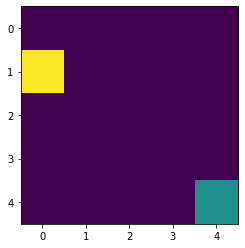

Action: Discrete(4)
Q_table: [[[ 4.14855914 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94391565 -0.04208223]
  [ 0.36       -0.32699215  3.68582689  0.09753448]
  [ 3.36025332  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95157131 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43989514 -0.5904    ]
  [ 0.         -0.2         1

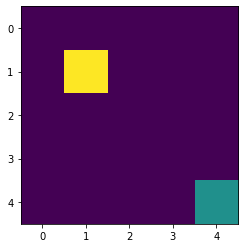

Action: Discrete(4)
Q_table: [[[ 4.14855914 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94486482 -0.04208223]
  [ 0.36       -0.32699215  3.68582689  0.09753448]
  [ 3.36025332  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95157131 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43989514 -0.5904    ]
  [ 0.         -0.2         1

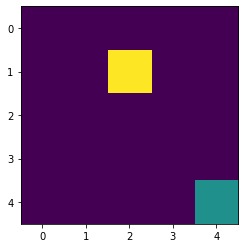

Action: Discrete(4)
Q_table: [[[ 4.14855914 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94486482 -0.04208223]
  [ 0.36       -0.32699215  3.68630204  0.09753448]
  [ 3.36025332  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95157131 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43989514 -0.5904    ]
  [ 0.         -0.2         1

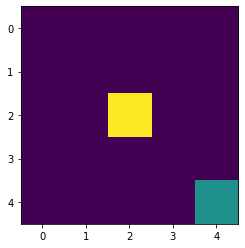

Action: Discrete(4)
Q_table: [[[ 4.14855914 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94486482 -0.04208223]
  [ 0.36       -0.32699215  3.68630204  0.09753448]
  [ 3.36045407  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95157131 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43989514 -0.5904    ]
  [ 0.         -0.2         1

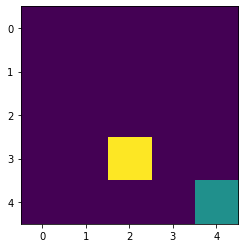

Action: Discrete(4)
Q_table: [[[ 4.14855914 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94486482 -0.04208223]
  [ 0.36       -0.32699215  3.68630204  0.09753448]
  [ 3.36045407  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95164027 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43989514 -0.5904    ]
  [ 0.         -0.2         1

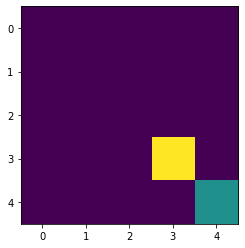

Action: Discrete(4)
Q_table: [[[ 4.14855914 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94486482 -0.04208223]
  [ 0.36       -0.32699215  3.68630204  0.09753448]
  [ 3.36045407  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95164027 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43991329 -0.5904    ]
  [ 0.         -0.2         1

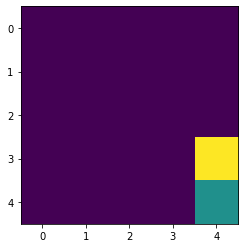

Action: Discrete(4)
Q_table: [[[ 4.14855914 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94486482 -0.04208223]
  [ 0.36       -0.32699215  3.68630204  0.09753448]
  [ 3.36045407  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95164027 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43991329 -0.5904    ]
  [ 0.         -0.2         1

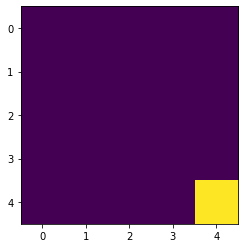

Round 82
Action: Discrete(4)
Q_table: [[[ 4.14855914 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94486482 -0.04208223]
  [ 0.36       -0.32699215  3.68630204  0.09753448]
  [ 3.36045407  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95164027 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43991329 -0.5904    ]
  [ 0.         -0.2 

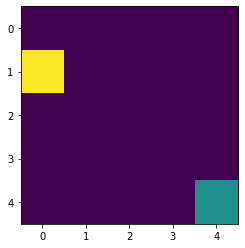

Action: Discrete(4)
Q_table: [[[ 4.15002569 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94486482 -0.04208223]
  [ 0.36       -0.32699215  3.68630204  0.09753448]
  [ 3.36045407  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95164027 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43991329 -0.5904    ]
  [ 0.         -0.2         1

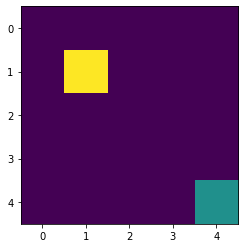

Action: Discrete(4)
Q_table: [[[ 4.15002569 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94570018 -0.04208223]
  [ 0.36       -0.32699215  3.68630204  0.09753448]
  [ 3.36045407  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95164027 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43991329 -0.5904    ]
  [ 0.         -0.2         1

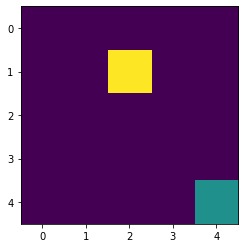

Action: Discrete(4)
Q_table: [[[ 4.15002569 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94570018 -0.04208223]
  [ 0.36       -0.32699215  3.68671429  0.09753448]
  [ 3.36045407  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95164027 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43991329 -0.5904    ]
  [ 0.         -0.2         1

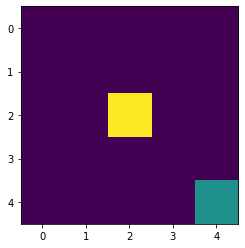

Action: Discrete(4)
Q_table: [[[ 4.15002569 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94570018 -0.04208223]
  [ 0.36       -0.32699215  3.68671429  0.09753448]
  [ 3.3606257   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95164027 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43991329 -0.5904    ]
  [ 0.         -0.2         1

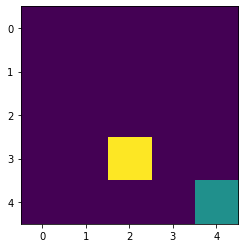

Action: Discrete(4)
Q_table: [[[ 4.15002569 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94570018 -0.04208223]
  [ 0.36       -0.32699215  3.68671429  0.09753448]
  [ 3.3606257   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95169834 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43991329 -0.5904    ]
  [ 0.         -0.2         1

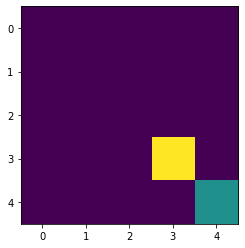

Action: Discrete(4)
Q_table: [[[ 4.15002569 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94570018 -0.04208223]
  [ 0.36       -0.32699215  3.68671429  0.09753448]
  [ 3.3606257   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95169834 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43992834 -0.5904    ]
  [ 0.         -0.2         1

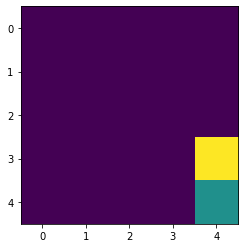

Action: Discrete(4)
Q_table: [[[ 4.15002569 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94570018 -0.04208223]
  [ 0.36       -0.32699215  3.68671429  0.09753448]
  [ 3.3606257   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95169834 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43992834 -0.5904    ]
  [ 0.         -0.2         1

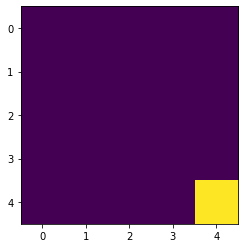

Round 83
Action: Discrete(4)
Q_table: [[[ 4.15002569 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94570018 -0.04208223]
  [ 0.36       -0.32699215  3.68671429  0.09753448]
  [ 3.3606257   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95169834 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43992834 -0.5904    ]
  [ 0.         -0.2 

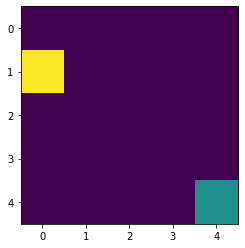

Action: Discrete(4)
Q_table: [[[ 4.15133258 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94570018 -0.04208223]
  [ 0.36       -0.32699215  3.68671429  0.09753448]
  [ 3.3606257   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95169834 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43992834 -0.5904    ]
  [ 0.         -0.2         1

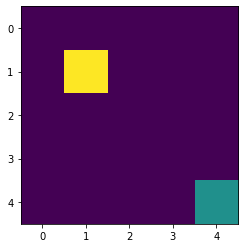

Action: Discrete(4)
Q_table: [[[ 4.15133258 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94643443 -0.04208223]
  [ 0.36       -0.32699215  3.68671429  0.09753448]
  [ 3.3606257   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95169834 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43992834 -0.5904    ]
  [ 0.         -0.2         1

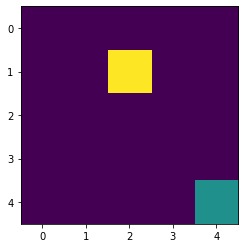

Action: Discrete(4)
Q_table: [[[ 4.15133258 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94643443 -0.04208223]
  [ 0.36       -0.32699215  3.68707154  0.09753448]
  [ 3.3606257   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95169834 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43992834 -0.5904    ]
  [ 0.         -0.2         1

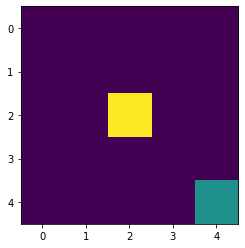

Action: Discrete(4)
Q_table: [[[ 4.15133258 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94643443 -0.04208223]
  [ 0.36       -0.32699215  3.68707154  0.09753448]
  [ 3.36077229  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95169834 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43992834 -0.5904    ]
  [ 0.         -0.2         1

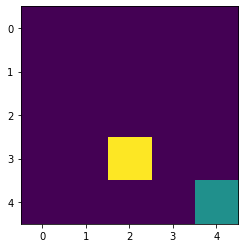

Action: Discrete(4)
Q_table: [[[ 4.15133258 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94643443 -0.04208223]
  [ 0.36       -0.32699215  3.68707154  0.09753448]
  [ 3.36077229  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95174721 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43992834 -0.5904    ]
  [ 0.         -0.2         1

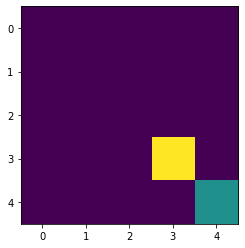

Action: Discrete(4)
Q_table: [[[ 4.15133258 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94643443 -0.04208223]
  [ 0.36       -0.32699215  3.68707154  0.09753448]
  [ 3.36077229  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95174721 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43994081 -0.5904    ]
  [ 0.         -0.2         1

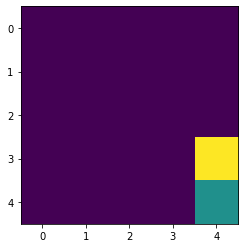

Action: Discrete(4)
Q_table: [[[ 4.15133258 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94643443 -0.04208223]
  [ 0.36       -0.32699215  3.68707154  0.09753448]
  [ 3.36077229  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95174721 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43994081 -0.5904    ]
  [ 0.         -0.2         1

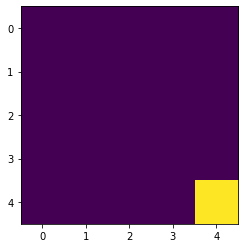

Round 84
Action: Discrete(4)
Q_table: [[[ 4.15133258 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94643443 -0.04208223]
  [ 0.36       -0.32699215  3.68707154  0.09753448]
  [ 3.36077229  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95174721 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43994081 -0.5904    ]
  [ 0.         -0.2 

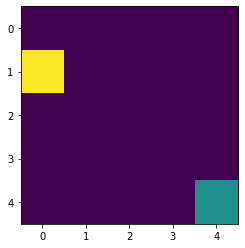

Action: Discrete(4)
Q_table: [[[ 4.15249557 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94643443 -0.04208223]
  [ 0.36       -0.32699215  3.68707154  0.09753448]
  [ 3.36077229  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95174721 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43994081 -0.5904    ]
  [ 0.         -0.2         1

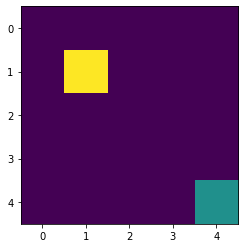

Action: Discrete(4)
Q_table: [[[ 4.15249557 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94707899 -0.04208223]
  [ 0.36       -0.32699215  3.68707154  0.09753448]
  [ 3.36077229  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95174721 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43994081 -0.5904    ]
  [ 0.         -0.2         1

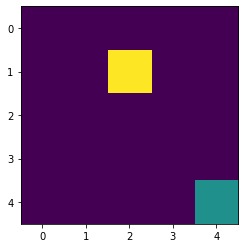

Action: Discrete(4)
Q_table: [[[ 4.15249557 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94707899 -0.04208223]
  [ 0.36       -0.32699215  3.6873808   0.09753448]
  [ 3.36077229  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95174721 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43994081 -0.5904    ]
  [ 0.         -0.2         1

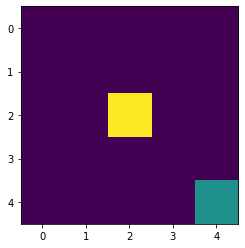

Action: Discrete(4)
Q_table: [[[ 4.15249557 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94707899 -0.04208223]
  [ 0.36       -0.32699215  3.6873808   0.09753448]
  [ 3.36089739  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95174721 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43994081 -0.5904    ]
  [ 0.         -0.2         1

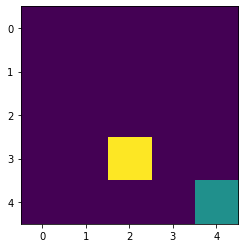

Action: Discrete(4)
Q_table: [[[ 4.15249557 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94707899 -0.04208223]
  [ 0.36       -0.32699215  3.6873808   0.09753448]
  [ 3.36089739  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9517883  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43994081 -0.5904    ]
  [ 0.         -0.2         1

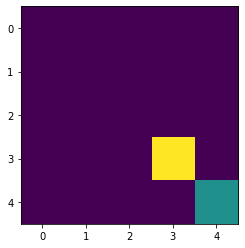

Action: Discrete(4)
Q_table: [[[ 4.15249557 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94707899 -0.04208223]
  [ 0.36       -0.32699215  3.6873808   0.09753448]
  [ 3.36089739  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9517883  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43995113 -0.5904    ]
  [ 0.         -0.2         1

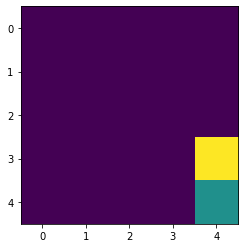

Action: Discrete(4)
Q_table: [[[ 4.15249557 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94707899 -0.04208223]
  [ 0.36       -0.32699215  3.6873808   0.09753448]
  [ 3.36089739  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9517883  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43995113 -0.5904    ]
  [ 0.         -0.2         1

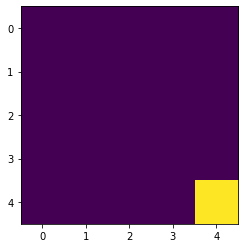

Round 85
Action: Discrete(4)
Q_table: [[[ 4.15249557 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94707899 -0.04208223]
  [ 0.36       -0.32699215  3.6873808   0.09753448]
  [ 3.36089739  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9517883  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43995113 -0.5904    ]
  [ 0.         -0.2 

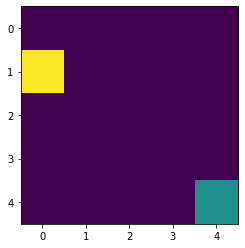

Action: Discrete(4)
Q_table: [[[ 4.1535291  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94707899 -0.04208223]
  [ 0.36       -0.32699215  3.6873808   0.09753448]
  [ 3.36089739  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9517883  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43995113 -0.5904    ]
  [ 0.         -0.2         1

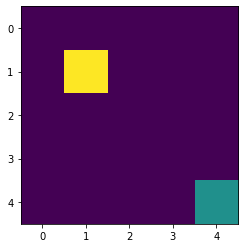

Action: Discrete(4)
Q_table: [[[ 4.1535291  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94764412 -0.04208223]
  [ 0.36       -0.32699215  3.6873808   0.09753448]
  [ 3.36089739  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9517883  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43995113 -0.5904    ]
  [ 0.         -0.2         1

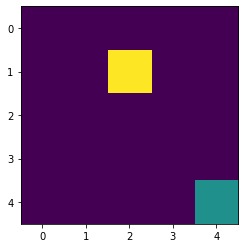

Action: Discrete(4)
Q_table: [[[ 4.1535291  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94764412 -0.04208223]
  [ 0.36       -0.32699215  3.68764822  0.09753448]
  [ 3.36089739  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9517883  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43995113 -0.5904    ]
  [ 0.         -0.2         1

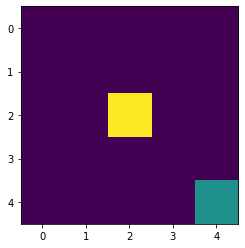

Action: Discrete(4)
Q_table: [[[ 4.1535291  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94764412 -0.04208223]
  [ 0.36       -0.32699215  3.68764822  0.09753448]
  [ 3.36100404  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9517883  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43995113 -0.5904    ]
  [ 0.         -0.2         1

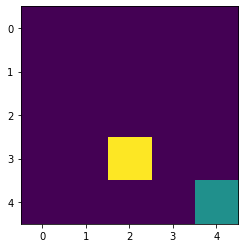

Action: Discrete(4)
Q_table: [[[ 4.1535291  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94764412 -0.04208223]
  [ 0.36       -0.32699215  3.68764822  0.09753448]
  [ 3.36100404  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95182282 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43995113 -0.5904    ]
  [ 0.         -0.2         1

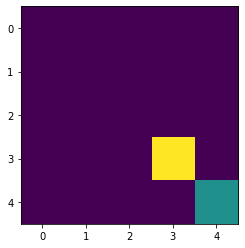

Action: Discrete(4)
Q_table: [[[ 4.1535291  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94764412 -0.04208223]
  [ 0.36       -0.32699215  3.68764822  0.09753448]
  [ 3.36100404  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95182282 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43995967 -0.5904    ]
  [ 0.         -0.2         1

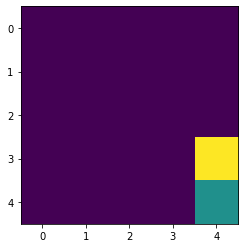

Action: Discrete(4)
Q_table: [[[ 4.1535291  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94764412 -0.04208223]
  [ 0.36       -0.32699215  3.68764822  0.09753448]
  [ 3.36100404  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95182282 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43995967 -0.5904    ]
  [ 0.         -0.2         1

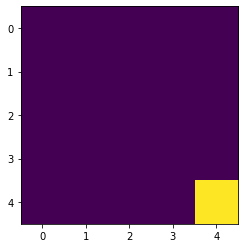

Round 86
Action: Discrete(4)
Q_table: [[[ 4.1535291  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94764412 -0.04208223]
  [ 0.36       -0.32699215  3.68764822  0.09753448]
  [ 3.36100404  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95182282 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43995967 -0.5904    ]
  [ 0.         -0.2 

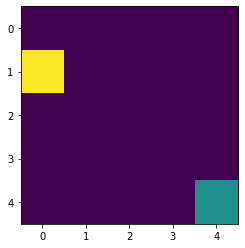

Action: Discrete(4)
Q_table: [[[ 4.15444634 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94764412 -0.04208223]
  [ 0.36       -0.32699215  3.68764822  0.09753448]
  [ 3.36100404  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95182282 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43995967 -0.5904    ]
  [ 0.         -0.2         1

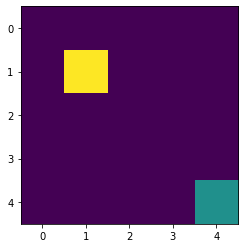

Action: Discrete(4)
Q_table: [[[ 4.15444634 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94813901 -0.04208223]
  [ 0.36       -0.32699215  3.68764822  0.09753448]
  [ 3.36100404  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95182282 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43995967 -0.5904    ]
  [ 0.         -0.2         1

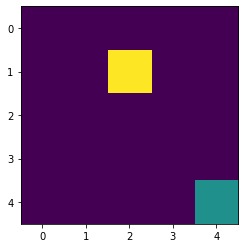

Action: Discrete(4)
Q_table: [[[ 4.15444634 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94813901 -0.04208223]
  [ 0.36       -0.32699215  3.68787922  0.09753448]
  [ 3.36100404  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95182282 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43995967 -0.5904    ]
  [ 0.         -0.2         1

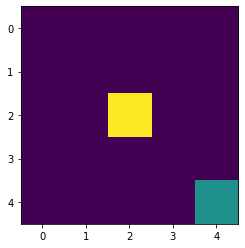

Action: Discrete(4)
Q_table: [[[ 4.15444634 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94813901 -0.04208223]
  [ 0.36       -0.32699215  3.68787922  0.09753448]
  [ 3.36109488  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95182282 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43995967 -0.5904    ]
  [ 0.         -0.2         1

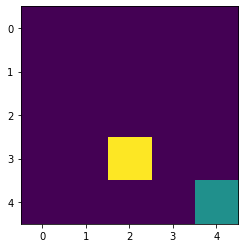

Action: Discrete(4)
Q_table: [[[ 4.15444634 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94813901 -0.04208223]
  [ 0.36       -0.32699215  3.68787922  0.09753448]
  [ 3.36109488  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9518518  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43995967 -0.5904    ]
  [ 0.         -0.2         1

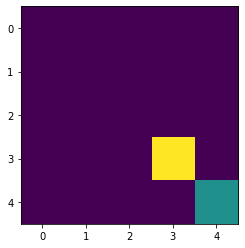

Action: Discrete(4)
Q_table: [[[ 4.15444634 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94813901 -0.04208223]
  [ 0.36       -0.32699215  3.68787922  0.09753448]
  [ 3.36109488  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9518518  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43996673 -0.5904    ]
  [ 0.         -0.2         1

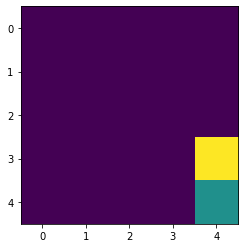

Action: Discrete(4)
Q_table: [[[ 4.15444634 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94813901 -0.04208223]
  [ 0.36       -0.32699215  3.68787922  0.09753448]
  [ 3.36109488  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9518518  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43996673 -0.5904    ]
  [ 0.         -0.2         1

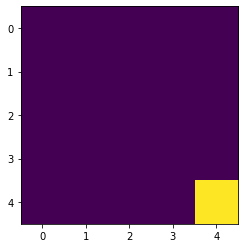

Round 87
Action: Discrete(4)
Q_table: [[[ 4.15444634 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94813901 -0.04208223]
  [ 0.36       -0.32699215  3.68787922  0.09753448]
  [ 3.36109488  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9518518  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43996673 -0.5904    ]
  [ 0.         -0.2 

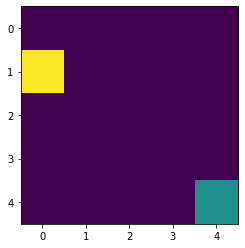

Action: Discrete(4)
Q_table: [[[ 4.15525931 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94813901 -0.04208223]
  [ 0.36       -0.32699215  3.68787922  0.09753448]
  [ 3.36109488  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9518518  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43996673 -0.5904    ]
  [ 0.         -0.2         1

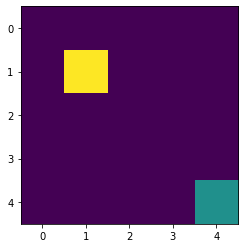

Action: Discrete(4)
Q_table: [[[ 4.15525931 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94857189 -0.04208223]
  [ 0.36       -0.32699215  3.68787922  0.09753448]
  [ 3.36109488  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9518518  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43996673 -0.5904    ]
  [ 0.         -0.2         1

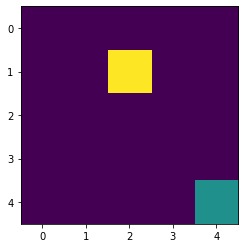

Action: Discrete(4)
Q_table: [[[ 4.15525931 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94857189 -0.04208223]
  [ 0.36       -0.32699215  3.68807856  0.09753448]
  [ 3.36109488  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9518518  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43996673 -0.5904    ]
  [ 0.         -0.2         1

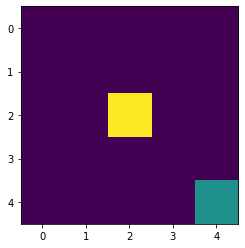

Action: Discrete(4)
Q_table: [[[ 4.15525931 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94857189 -0.04208223]
  [ 0.36       -0.32699215  3.68807856  0.09753448]
  [ 3.36117219  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9518518  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43996673 -0.5904    ]
  [ 0.         -0.2         1

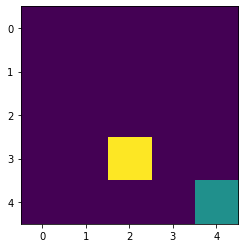

Action: Discrete(4)
Q_table: [[[ 4.15525931 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94857189 -0.04208223]
  [ 0.36       -0.32699215  3.68807856  0.09753448]
  [ 3.36117219  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95187612 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43996673 -0.5904    ]
  [ 0.         -0.2         1

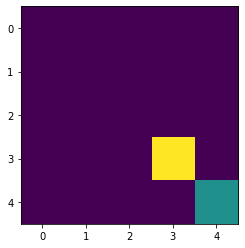

Action: Discrete(4)
Q_table: [[[ 4.15525931 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94857189 -0.04208223]
  [ 0.36       -0.32699215  3.68807856  0.09753448]
  [ 3.36117219  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95187612 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43997257 -0.5904    ]
  [ 0.         -0.2         1

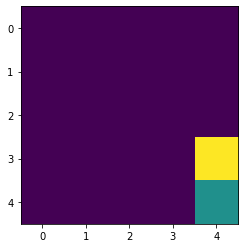

Action: Discrete(4)
Q_table: [[[ 4.15525931 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94857189 -0.04208223]
  [ 0.36       -0.32699215  3.68807856  0.09753448]
  [ 3.36117219  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95187612 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43997257 -0.5904    ]
  [ 0.         -0.2         1

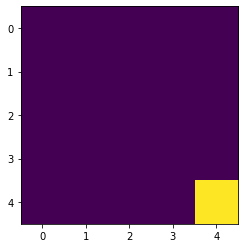

Round 88
Action: Discrete(4)
Q_table: [[[ 4.15525931 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94857189 -0.04208223]
  [ 0.36       -0.32699215  3.68807856  0.09753448]
  [ 3.36117219  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95187612 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43997257 -0.5904    ]
  [ 0.         -0.2 

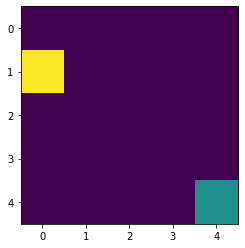

Action: Discrete(4)
Q_table: [[[ 4.15597895 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94857189 -0.04208223]
  [ 0.36       -0.32699215  3.68807856  0.09753448]
  [ 3.36117219  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95187612 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43997257 -0.5904    ]
  [ 0.         -0.2         1

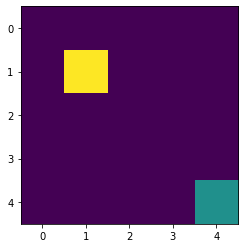

Action: Discrete(4)
Q_table: [[[ 4.15597895 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94895008 -0.04208223]
  [ 0.36       -0.32699215  3.68807856  0.09753448]
  [ 3.36117219  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95187612 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43997257 -0.5904    ]
  [ 0.         -0.2         1

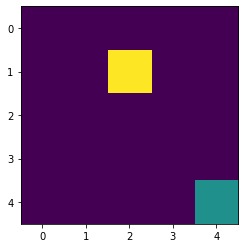

Action: Discrete(4)
Q_table: [[[ 4.15597895 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94895008 -0.04208223]
  [ 0.36       -0.32699215  3.6882504   0.09753448]
  [ 3.36117219  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95187612 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43997257 -0.5904    ]
  [ 0.         -0.2         1

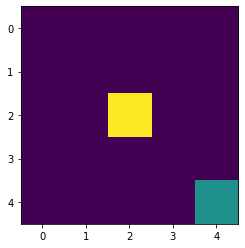

Action: Discrete(4)
Q_table: [[[ 4.15597895 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94895008 -0.04208223]
  [ 0.36       -0.32699215  3.6882504   0.09753448]
  [ 3.36123793  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95187612 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43997257 -0.5904    ]
  [ 0.         -0.2         1

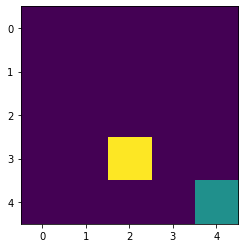

Action: Discrete(4)
Q_table: [[[ 4.15597895 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94895008 -0.04208223]
  [ 0.36       -0.32699215  3.6882504   0.09753448]
  [ 3.36123793  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9518965  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43997257 -0.5904    ]
  [ 0.         -0.2         1

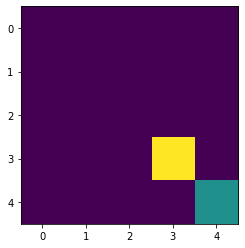

Action: Discrete(4)
Q_table: [[[ 4.15597895 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94895008 -0.04208223]
  [ 0.36       -0.32699215  3.6882504   0.09753448]
  [ 3.36123793  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9518965  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43997739 -0.5904    ]
  [ 0.         -0.2         1

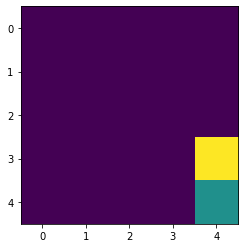

Action: Discrete(4)
Q_table: [[[ 4.15597895 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94895008 -0.04208223]
  [ 0.36       -0.32699215  3.6882504   0.09753448]
  [ 3.36123793  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9518965  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43997739 -0.5904    ]
  [ 0.         -0.2         1

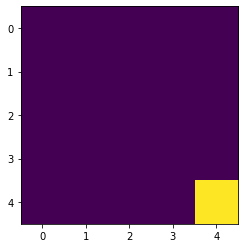

Round 89
Action: Discrete(4)
Q_table: [[[ 4.15597895 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94895008 -0.04208223]
  [ 0.36       -0.32699215  3.6882504   0.09753448]
  [ 3.36123793  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9518965  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43997739 -0.5904    ]
  [ 0.         -0.2 

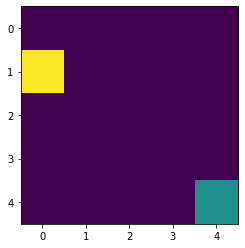

Action: Discrete(4)
Q_table: [[[ 4.15661517 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94895008 -0.04208223]
  [ 0.36       -0.32699215  3.6882504   0.09753448]
  [ 3.36123793  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9518965  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43997739 -0.5904    ]
  [ 0.         -0.2         1

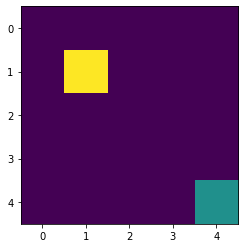

Action: Discrete(4)
Q_table: [[[ 4.15661517 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94928013 -0.04208223]
  [ 0.36       -0.32699215  3.6882504   0.09753448]
  [ 3.36123793  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9518965  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43997739 -0.5904    ]
  [ 0.         -0.2         1

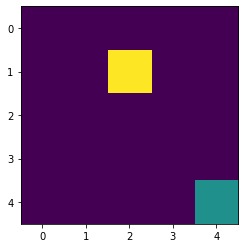

Action: Discrete(4)
Q_table: [[[ 4.15661517 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94928013 -0.04208223]
  [ 0.36       -0.32699215  3.68839839  0.09753448]
  [ 3.36123793  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9518965  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43997739 -0.5904    ]
  [ 0.         -0.2         1

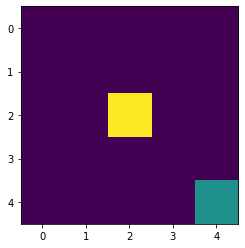

Action: Discrete(4)
Q_table: [[[ 4.15661517 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94928013 -0.04208223]
  [ 0.36       -0.32699215  3.68839839  0.09753448]
  [ 3.36129379  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.9518965  -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43997739 -0.5904    ]
  [ 0.         -0.2         1

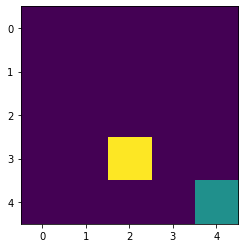

Action: Discrete(4)
Q_table: [[[ 4.15661517 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94928013 -0.04208223]
  [ 0.36       -0.32699215  3.68839839  0.09753448]
  [ 3.36129379  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95191359 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43997739 -0.5904    ]
  [ 0.         -0.2         1

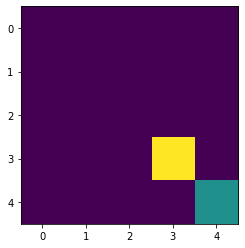

Action: Discrete(4)
Q_table: [[[ 4.15661517 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94928013 -0.04208223]
  [ 0.36       -0.32699215  3.68839839  0.09753448]
  [ 3.36129379  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95191359 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998137 -0.5904    ]
  [ 0.         -0.2         1

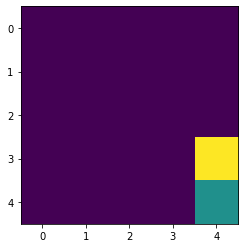

Action: Discrete(4)
Q_table: [[[ 4.15661517 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94928013 -0.04208223]
  [ 0.36       -0.32699215  3.68839839  0.09753448]
  [ 3.36129379  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95191359 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998137 -0.5904    ]
  [ 0.         -0.2         1

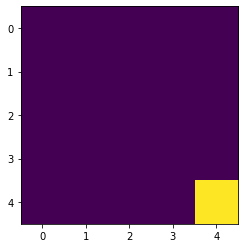

Round 90
Action: Discrete(4)
Q_table: [[[ 4.15661517 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94928013 -0.04208223]
  [ 0.36       -0.32699215  3.68839839  0.09753448]
  [ 3.36129379  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95191359 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998137 -0.5904    ]
  [ 0.         -0.2 

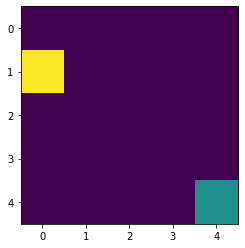

Action: Discrete(4)
Q_table: [[[ 4.15717696 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94928013 -0.04208223]
  [ 0.36       -0.32699215  3.68839839  0.09753448]
  [ 3.36129379  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95191359 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998137 -0.5904    ]
  [ 0.         -0.2         1

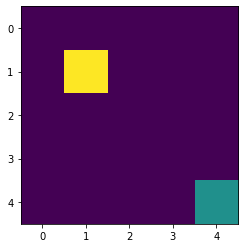

Action: Discrete(4)
Q_table: [[[ 4.15717696 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94956784 -0.04208223]
  [ 0.36       -0.32699215  3.68839839  0.09753448]
  [ 3.36129379  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95191359 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998137 -0.5904    ]
  [ 0.         -0.2         1

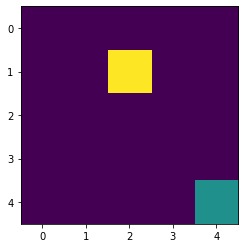

Action: Discrete(4)
Q_table: [[[ 4.15717696 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94956784 -0.04208223]
  [ 0.36       -0.32699215  3.68852572  0.09753448]
  [ 3.36129379  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95191359 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998137 -0.5904    ]
  [ 0.         -0.2         1

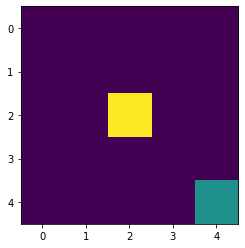

Action: Discrete(4)
Q_table: [[[ 4.15717696 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94956784 -0.04208223]
  [ 0.36       -0.32699215  3.68852572  0.09753448]
  [ 3.3613412   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95191359 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998137 -0.5904    ]
  [ 0.         -0.2         1

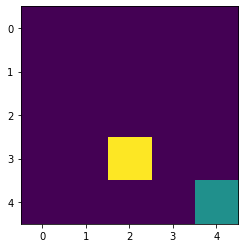

Action: Discrete(4)
Q_table: [[[ 4.15717696 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94956784 -0.04208223]
  [ 0.36       -0.32699215  3.68852572  0.09753448]
  [ 3.3613412   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95192789 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998137 -0.5904    ]
  [ 0.         -0.2         1

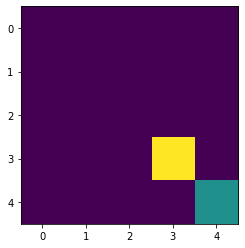

Action: Discrete(4)
Q_table: [[[ 4.15717696 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94956784 -0.04208223]
  [ 0.36       -0.32699215  3.68852572  0.09753448]
  [ 3.3613412   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95192789 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998466 -0.5904    ]
  [ 0.         -0.2         1

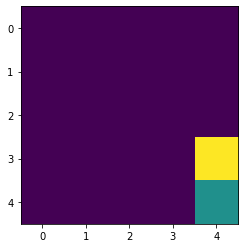

Action: Discrete(4)
Q_table: [[[ 4.15717696 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94956784 -0.04208223]
  [ 0.36       -0.32699215  3.68852572  0.09753448]
  [ 3.3613412   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95192789 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998466 -0.5904    ]
  [ 0.         -0.2         1

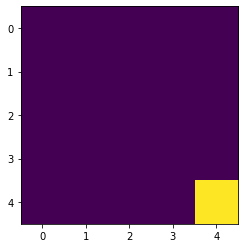

Round 91
Action: Discrete(4)
Q_table: [[[ 4.15717696 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94956784 -0.04208223]
  [ 0.36       -0.32699215  3.68852572  0.09753448]
  [ 3.3613412   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95192789 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998466 -0.5904    ]
  [ 0.         -0.2 

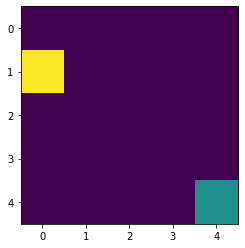

Action: Discrete(4)
Q_table: [[[ 4.15767242 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94956784 -0.04208223]
  [ 0.36       -0.32699215  3.68852572  0.09753448]
  [ 3.3613412   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95192789 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998466 -0.5904    ]
  [ 0.         -0.2         1

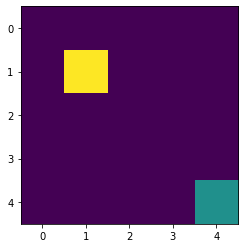

Action: Discrete(4)
Q_table: [[[ 4.15767242 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94981839 -0.04208223]
  [ 0.36       -0.32699215  3.68852572  0.09753448]
  [ 3.3613412   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95192789 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998466 -0.5904    ]
  [ 0.         -0.2         1

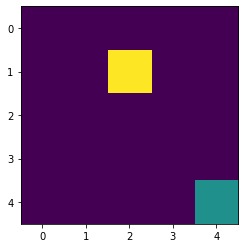

Action: Discrete(4)
Q_table: [[[ 4.15767242 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94981839 -0.04208223]
  [ 0.36       -0.32699215  3.68863517  0.09753448]
  [ 3.3613412   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95192789 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998466 -0.5904    ]
  [ 0.         -0.2         1

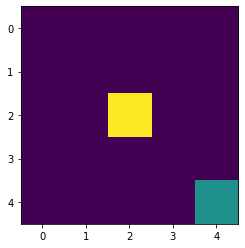

Action: Discrete(4)
Q_table: [[[ 4.15767242 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94981839 -0.04208223]
  [ 0.36       -0.32699215  3.68863517  0.09753448]
  [ 3.36138143  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95192789 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998466 -0.5904    ]
  [ 0.         -0.2         1

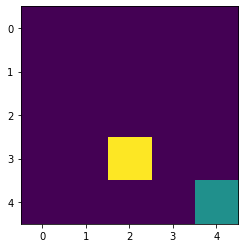

Action: Discrete(4)
Q_table: [[[ 4.15767242 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94981839 -0.04208223]
  [ 0.36       -0.32699215  3.68863517  0.09753448]
  [ 3.36138143  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95193986 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998466 -0.5904    ]
  [ 0.         -0.2         1

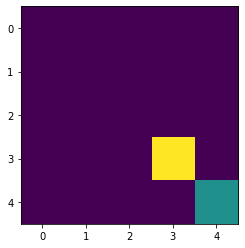

Action: Discrete(4)
Q_table: [[[ 4.15767242 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94981839 -0.04208223]
  [ 0.36       -0.32699215  3.68863517  0.09753448]
  [ 3.36138143  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95193986 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998737 -0.5904    ]
  [ 0.         -0.2         1

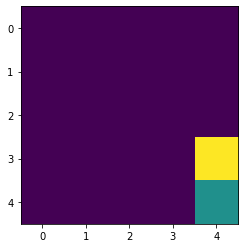

Action: Discrete(4)
Q_table: [[[ 4.15767242 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94981839 -0.04208223]
  [ 0.36       -0.32699215  3.68863517  0.09753448]
  [ 3.36138143  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95193986 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998737 -0.5904    ]
  [ 0.         -0.2         1

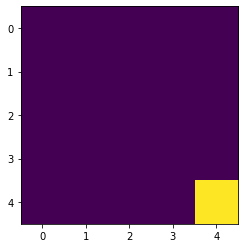

Round 92
Action: Discrete(4)
Q_table: [[[ 4.15767242 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94981839 -0.04208223]
  [ 0.36       -0.32699215  3.68863517  0.09753448]
  [ 3.36138143  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95193986 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998737 -0.5904    ]
  [ 0.         -0.2 

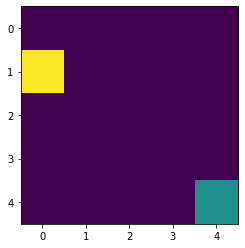

Action: Discrete(4)
Q_table: [[[ 4.15810888 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.94981839 -0.04208223]
  [ 0.36       -0.32699215  3.68863517  0.09753448]
  [ 3.36138143  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95193986 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998737 -0.5904    ]
  [ 0.         -0.2         1

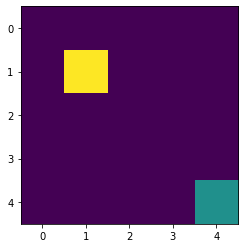

Action: Discrete(4)
Q_table: [[[ 4.15810888 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95003634 -0.04208223]
  [ 0.36       -0.32699215  3.68863517  0.09753448]
  [ 3.36138143  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95193986 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998737 -0.5904    ]
  [ 0.         -0.2         1

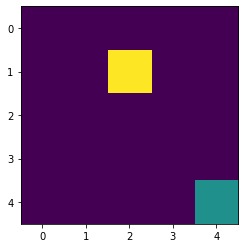

Action: Discrete(4)
Q_table: [[[ 4.15810888 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95003634 -0.04208223]
  [ 0.36       -0.32699215  3.68872916  0.09753448]
  [ 3.36138143  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95193986 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998737 -0.5904    ]
  [ 0.         -0.2         1

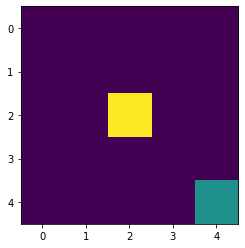

Action: Discrete(4)
Q_table: [[[ 4.15810888 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95003634 -0.04208223]
  [ 0.36       -0.32699215  3.68872916  0.09753448]
  [ 3.36141552  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95193986 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998737 -0.5904    ]
  [ 0.         -0.2         1

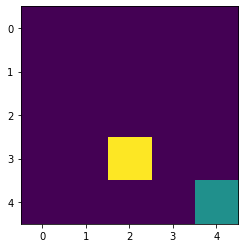

Action: Discrete(4)
Q_table: [[[ 4.15810888 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95003634 -0.04208223]
  [ 0.36       -0.32699215  3.68872916  0.09753448]
  [ 3.36141552  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95194987 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998737 -0.5904    ]
  [ 0.         -0.2         1

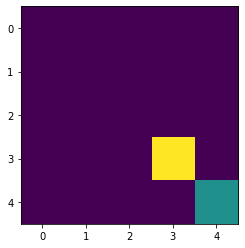

Action: Discrete(4)
Q_table: [[[ 4.15810888 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95003634 -0.04208223]
  [ 0.36       -0.32699215  3.68872916  0.09753448]
  [ 3.36141552  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95194987 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998961 -0.5904    ]
  [ 0.         -0.2         1

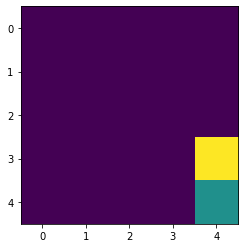

Action: Discrete(4)
Q_table: [[[ 4.15810888 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95003634 -0.04208223]
  [ 0.36       -0.32699215  3.68872916  0.09753448]
  [ 3.36141552  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95194987 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998961 -0.5904    ]
  [ 0.         -0.2         1

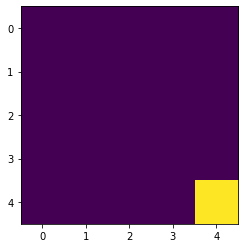

Round 93
Action: Discrete(4)
Q_table: [[[ 4.15810888 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95003634 -0.04208223]
  [ 0.36       -0.32699215  3.68872916  0.09753448]
  [ 3.36141552  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95194987 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998961 -0.5904    ]
  [ 0.         -0.2 

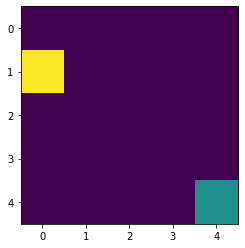

Action: Discrete(4)
Q_table: [[[ 4.15849292 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95003634 -0.04208223]
  [ 0.36       -0.32699215  3.68872916  0.09753448]
  [ 3.36141552  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95194987 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998961 -0.5904    ]
  [ 0.         -0.2         1

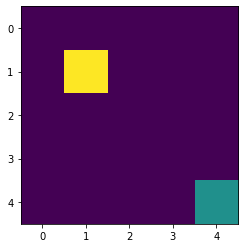

Action: Discrete(4)
Q_table: [[[ 4.15849292 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95022574 -0.04208223]
  [ 0.36       -0.32699215  3.68872916  0.09753448]
  [ 3.36141552  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95194987 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998961 -0.5904    ]
  [ 0.         -0.2         1

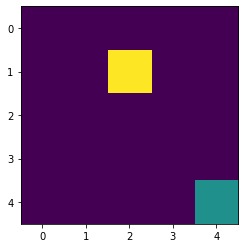

Action: Discrete(4)
Q_table: [[[ 4.15849292 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95022574 -0.04208223]
  [ 0.36       -0.32699215  3.68880981  0.09753448]
  [ 3.36141552  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95194987 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998961 -0.5904    ]
  [ 0.         -0.2         1

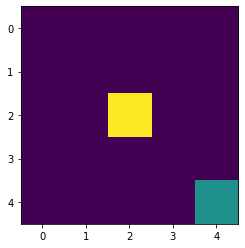

Action: Discrete(4)
Q_table: [[[ 4.15849292 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95022574 -0.04208223]
  [ 0.36       -0.32699215  3.68880981  0.09753448]
  [ 3.36144439  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95194987 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998961 -0.5904    ]
  [ 0.         -0.2         1

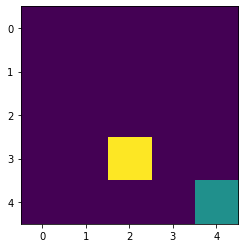

Action: Discrete(4)
Q_table: [[[ 4.15849292 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95022574 -0.04208223]
  [ 0.36       -0.32699215  3.68880981  0.09753448]
  [ 3.36144439  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95195823 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43998961 -0.5904    ]
  [ 0.         -0.2         1

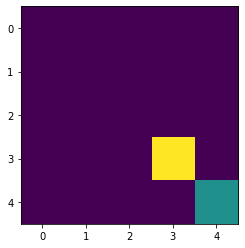

Action: Discrete(4)
Q_table: [[[ 4.15849292 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95022574 -0.04208223]
  [ 0.36       -0.32699215  3.68880981  0.09753448]
  [ 3.36144439  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95195823 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999145 -0.5904    ]
  [ 0.         -0.2         1

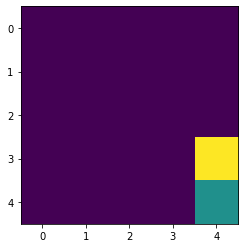

Action: Discrete(4)
Q_table: [[[ 4.15849292 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95022574 -0.04208223]
  [ 0.36       -0.32699215  3.68880981  0.09753448]
  [ 3.36144439  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95195823 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999145 -0.5904    ]
  [ 0.         -0.2         1

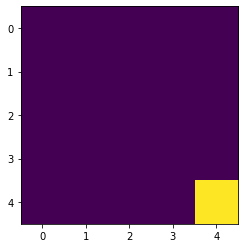

Round 94
Action: Discrete(4)
Q_table: [[[ 4.15849292 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95022574 -0.04208223]
  [ 0.36       -0.32699215  3.68880981  0.09753448]
  [ 3.36144439  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95195823 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999145 -0.5904    ]
  [ 0.         -0.2 

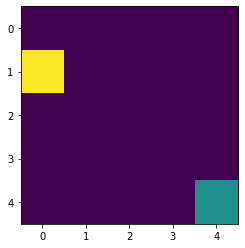

Action: Discrete(4)
Q_table: [[[ 4.15883045 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95022574 -0.04208223]
  [ 0.36       -0.32699215  3.68880981  0.09753448]
  [ 3.36144439  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95195823 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999145 -0.5904    ]
  [ 0.         -0.2         1

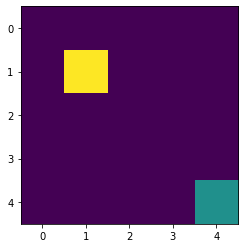

Action: Discrete(4)
Q_table: [[[ 4.15883045 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95039016 -0.04208223]
  [ 0.36       -0.32699215  3.68880981  0.09753448]
  [ 3.36144439  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95195823 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999145 -0.5904    ]
  [ 0.         -0.2         1

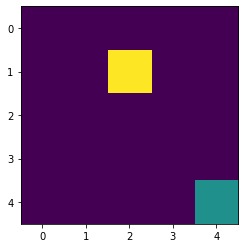

Action: Discrete(4)
Q_table: [[[ 4.15883045 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95039016 -0.04208223]
  [ 0.36       -0.32699215  3.68887895  0.09753448]
  [ 3.36144439  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95195823 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999145 -0.5904    ]
  [ 0.         -0.2         1

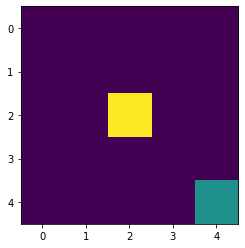

Action: Discrete(4)
Q_table: [[[ 4.15883045 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95039016 -0.04208223]
  [ 0.36       -0.32699215  3.68887895  0.09753448]
  [ 3.36146883  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95195823 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999145 -0.5904    ]
  [ 0.         -0.2         1

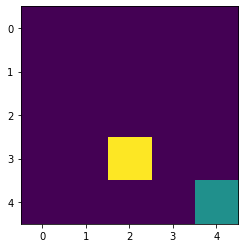

Action: Discrete(4)
Q_table: [[[ 4.15883045 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95039016 -0.04208223]
  [ 0.36       -0.32699215  3.68887895  0.09753448]
  [ 3.36146883  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95196522 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999145 -0.5904    ]
  [ 0.         -0.2         1

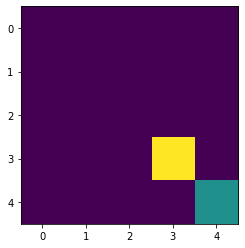

Action: Discrete(4)
Q_table: [[[ 4.15883045 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95039016 -0.04208223]
  [ 0.36       -0.32699215  3.68887895  0.09753448]
  [ 3.36146883  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95196522 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999297 -0.5904    ]
  [ 0.         -0.2         1

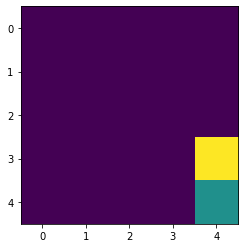

Action: Discrete(4)
Q_table: [[[ 4.15883045 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95039016 -0.04208223]
  [ 0.36       -0.32699215  3.68887895  0.09753448]
  [ 3.36146883  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95196522 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999297 -0.5904    ]
  [ 0.         -0.2         1

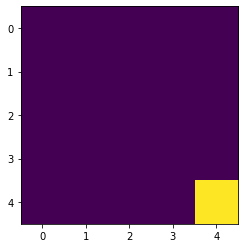

Round 95
Action: Discrete(4)
Q_table: [[[ 4.15883045 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95039016 -0.04208223]
  [ 0.36       -0.32699215  3.68887895  0.09753448]
  [ 3.36146883  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95196522 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999297 -0.5904    ]
  [ 0.         -0.2 

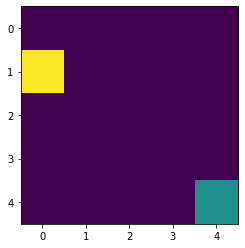

Action: Discrete(4)
Q_table: [[[ 4.15912679 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95039016 -0.04208223]
  [ 0.36       -0.32699215  3.68887895  0.09753448]
  [ 3.36146883  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95196522 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999297 -0.5904    ]
  [ 0.         -0.2         1

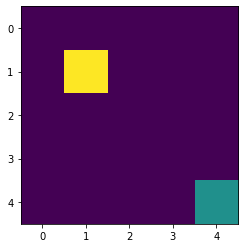

Action: Discrete(4)
Q_table: [[[ 4.15912679 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95053276 -0.04208223]
  [ 0.36       -0.32699215  3.68887895  0.09753448]
  [ 3.36146883  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95196522 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999297 -0.5904    ]
  [ 0.         -0.2         1

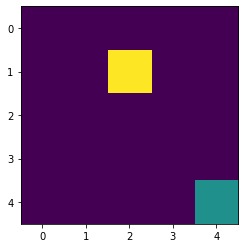

Action: Discrete(4)
Q_table: [[[ 4.15912679 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95053276 -0.04208223]
  [ 0.36       -0.32699215  3.68893817  0.09753448]
  [ 3.36146883  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95196522 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999297 -0.5904    ]
  [ 0.         -0.2         1

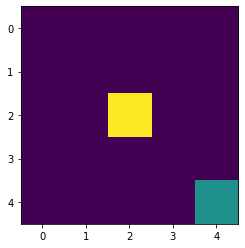

Action: Discrete(4)
Q_table: [[[ 4.15912679 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95053276 -0.04208223]
  [ 0.36       -0.32699215  3.68893817  0.09753448]
  [ 3.3614895   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95196522 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999297 -0.5904    ]
  [ 0.         -0.2         1

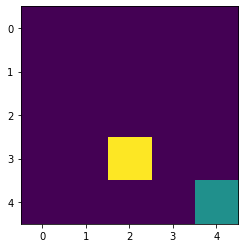

Action: Discrete(4)
Q_table: [[[ 4.15912679 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95053276 -0.04208223]
  [ 0.36       -0.32699215  3.68893817  0.09753448]
  [ 3.3614895   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95197105 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999297 -0.5904    ]
  [ 0.         -0.2         1

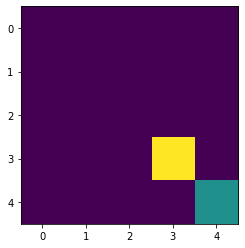

Action: Discrete(4)
Q_table: [[[ 4.15912679 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95053276 -0.04208223]
  [ 0.36       -0.32699215  3.68893817  0.09753448]
  [ 3.3614895   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95197105 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999422 -0.5904    ]
  [ 0.         -0.2         1

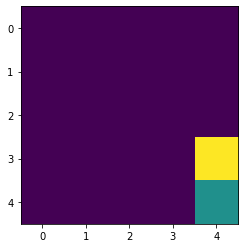

Action: Discrete(4)
Q_table: [[[ 4.15912679 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95053276 -0.04208223]
  [ 0.36       -0.32699215  3.68893817  0.09753448]
  [ 3.3614895   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95197105 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999422 -0.5904    ]
  [ 0.         -0.2         1

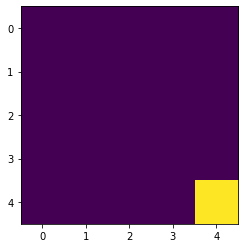

Round 96
Action: Discrete(4)
Q_table: [[[ 4.15912679 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95053276 -0.04208223]
  [ 0.36       -0.32699215  3.68893817  0.09753448]
  [ 3.3614895   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95197105 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999422 -0.5904    ]
  [ 0.         -0.2 

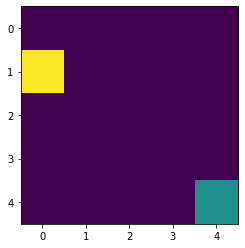

Action: Discrete(4)
Q_table: [[[ 4.15938667 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95053276 -0.04208223]
  [ 0.36       -0.32699215  3.68893817  0.09753448]
  [ 3.3614895   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95197105 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999422 -0.5904    ]
  [ 0.         -0.2         1

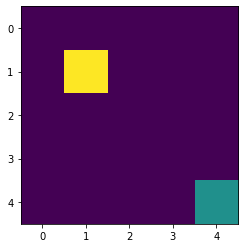

Action: Discrete(4)
Q_table: [[[ 4.15938667 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95065631 -0.04208223]
  [ 0.36       -0.32699215  3.68893817  0.09753448]
  [ 3.3614895   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95197105 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999422 -0.5904    ]
  [ 0.         -0.2         1

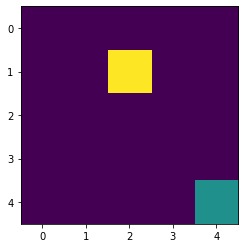

Action: Discrete(4)
Q_table: [[[ 4.15938667 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95065631 -0.04208223]
  [ 0.36       -0.32699215  3.68898886  0.09753448]
  [ 3.3614895   0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95197105 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999422 -0.5904    ]
  [ 0.         -0.2         1

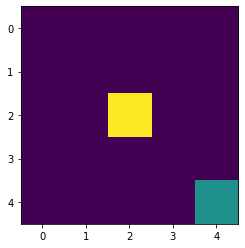

Action: Discrete(4)
Q_table: [[[ 4.15938667 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95065631 -0.04208223]
  [ 0.36       -0.32699215  3.68898886  0.09753448]
  [ 3.36150697  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95197105 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999422 -0.5904    ]
  [ 0.         -0.2         1

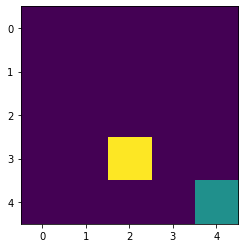

Action: Discrete(4)
Q_table: [[[ 4.15938667 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95065631 -0.04208223]
  [ 0.36       -0.32699215  3.68898886  0.09753448]
  [ 3.36150697  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95197592 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999422 -0.5904    ]
  [ 0.         -0.2         1

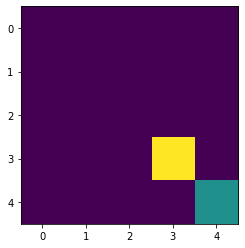

Action: Discrete(4)
Q_table: [[[ 4.15938667 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95065631 -0.04208223]
  [ 0.36       -0.32699215  3.68898886  0.09753448]
  [ 3.36150697  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95197592 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999525 -0.5904    ]
  [ 0.         -0.2         1

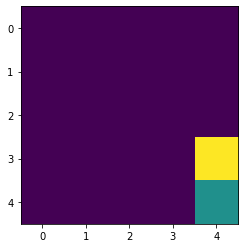

Action: Discrete(4)
Q_table: [[[ 4.15938667 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95065631 -0.04208223]
  [ 0.36       -0.32699215  3.68898886  0.09753448]
  [ 3.36150697  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95197592 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999525 -0.5904    ]
  [ 0.         -0.2         1

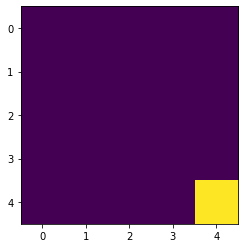

Round 97
Action: Discrete(4)
Q_table: [[[ 4.15938667 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95065631 -0.04208223]
  [ 0.36       -0.32699215  3.68898886  0.09753448]
  [ 3.36150697  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95197592 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999525 -0.5904    ]
  [ 0.         -0.2 

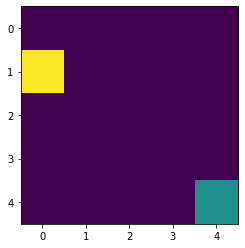

Action: Discrete(4)
Q_table: [[[ 4.15961435 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95065631 -0.04208223]
  [ 0.36       -0.32699215  3.68898886  0.09753448]
  [ 3.36150697  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95197592 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999525 -0.5904    ]
  [ 0.         -0.2         1

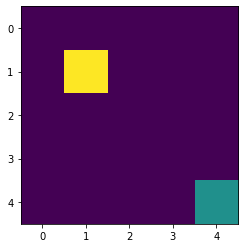

Action: Discrete(4)
Q_table: [[[ 4.15961435 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95076327 -0.04208223]
  [ 0.36       -0.32699215  3.68898886  0.09753448]
  [ 3.36150697  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95197592 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999525 -0.5904    ]
  [ 0.         -0.2         1

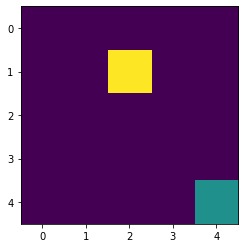

Action: Discrete(4)
Q_table: [[[ 4.15961435 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95076327 -0.04208223]
  [ 0.36       -0.32699215  3.6890322   0.09753448]
  [ 3.36150697  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95197592 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999525 -0.5904    ]
  [ 0.         -0.2         1

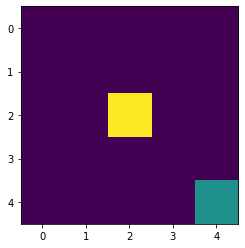

Action: Discrete(4)
Q_table: [[[ 4.15961435 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95076327 -0.04208223]
  [ 0.36       -0.32699215  3.6890322   0.09753448]
  [ 3.36152172  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95197592 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999525 -0.5904    ]
  [ 0.         -0.2         1

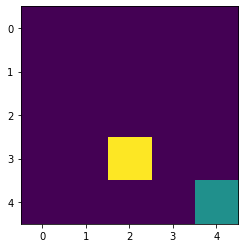

Action: Discrete(4)
Q_table: [[[ 4.15961435 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95076327 -0.04208223]
  [ 0.36       -0.32699215  3.6890322   0.09753448]
  [ 3.36152172  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95197997 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999525 -0.5904    ]
  [ 0.         -0.2         1

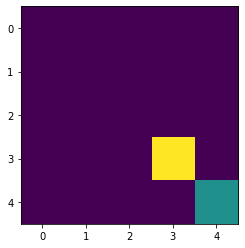

Action: Discrete(4)
Q_table: [[[ 4.15961435 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95076327 -0.04208223]
  [ 0.36       -0.32699215  3.6890322   0.09753448]
  [ 3.36152172  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95197997 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4399961  -0.5904    ]
  [ 0.         -0.2         1

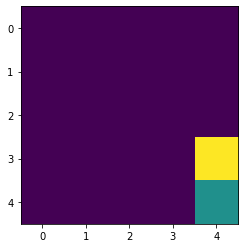

Action: Discrete(4)
Q_table: [[[ 4.15961435 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95076327 -0.04208223]
  [ 0.36       -0.32699215  3.6890322   0.09753448]
  [ 3.36152172  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95197997 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4399961  -0.5904    ]
  [ 0.         -0.2         1

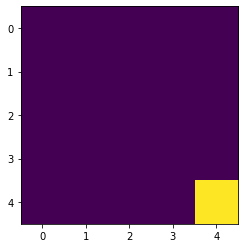

Round 98
Action: Discrete(4)
Q_table: [[[ 4.15961435 -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95076327 -0.04208223]
  [ 0.36       -0.32699215  3.6890322   0.09753448]
  [ 3.36152172  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95197997 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4399961  -0.5904    ]
  [ 0.         -0.2 

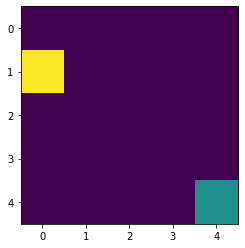

Action: Discrete(4)
Q_table: [[[ 4.1598136  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95076327 -0.04208223]
  [ 0.36       -0.32699215  3.6890322   0.09753448]
  [ 3.36152172  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95197997 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4399961  -0.5904    ]
  [ 0.         -0.2         1

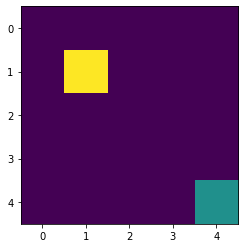

Action: Discrete(4)
Q_table: [[[ 4.1598136  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95085577 -0.04208223]
  [ 0.36       -0.32699215  3.6890322   0.09753448]
  [ 3.36152172  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95197997 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4399961  -0.5904    ]
  [ 0.         -0.2         1

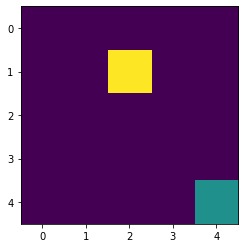

Action: Discrete(4)
Q_table: [[[ 4.1598136  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95085577 -0.04208223]
  [ 0.36       -0.32699215  3.68906924  0.09753448]
  [ 3.36152172  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95197997 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4399961  -0.5904    ]
  [ 0.         -0.2         1

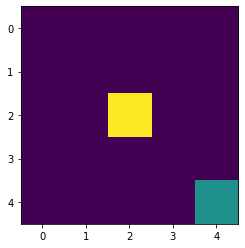

Action: Discrete(4)
Q_table: [[[ 4.1598136  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95085577 -0.04208223]
  [ 0.36       -0.32699215  3.68906924  0.09753448]
  [ 3.36153417  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95197997 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4399961  -0.5904    ]
  [ 0.         -0.2         1

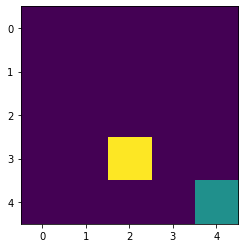

Action: Discrete(4)
Q_table: [[[ 4.1598136  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95085577 -0.04208223]
  [ 0.36       -0.32699215  3.68906924  0.09753448]
  [ 3.36153417  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95198335 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4399961  -0.5904    ]
  [ 0.         -0.2         1

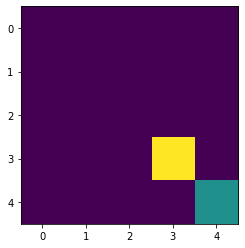

Action: Discrete(4)
Q_table: [[[ 4.1598136  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95085577 -0.04208223]
  [ 0.36       -0.32699215  3.68906924  0.09753448]
  [ 3.36153417  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95198335 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4399968  -0.5904    ]
  [ 0.         -0.2         1

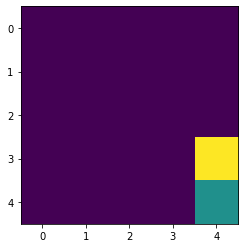

Action: Discrete(4)
Q_table: [[[ 4.1598136  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95085577 -0.04208223]
  [ 0.36       -0.32699215  3.68906924  0.09753448]
  [ 3.36153417  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95198335 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4399968  -0.5904    ]
  [ 0.         -0.2         1

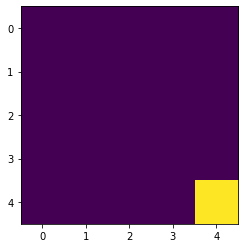

Round 99
Action: Discrete(4)
Q_table: [[[ 4.1598136  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95085577 -0.04208223]
  [ 0.36       -0.32699215  3.68906924  0.09753448]
  [ 3.36153417  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95198335 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4399968  -0.5904    ]
  [ 0.         -0.2 

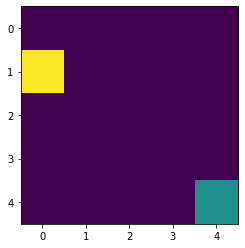

Action: Discrete(4)
Q_table: [[[ 4.1599878  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95085577 -0.04208223]
  [ 0.36       -0.32699215  3.68906924  0.09753448]
  [ 3.36153417  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95198335 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4399968  -0.5904    ]
  [ 0.         -0.2         1

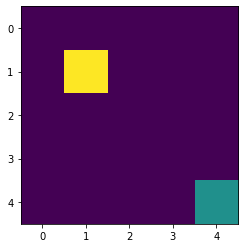

Action: Discrete(4)
Q_table: [[[ 4.1599878  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95093569 -0.04208223]
  [ 0.36       -0.32699215  3.68906924  0.09753448]
  [ 3.36153417  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95198335 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4399968  -0.5904    ]
  [ 0.         -0.2         1

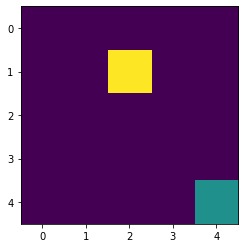

Action: Discrete(4)
Q_table: [[[ 4.1599878  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95093569 -0.04208223]
  [ 0.36       -0.32699215  3.68910086  0.09753448]
  [ 3.36153417  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95198335 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4399968  -0.5904    ]
  [ 0.         -0.2         1

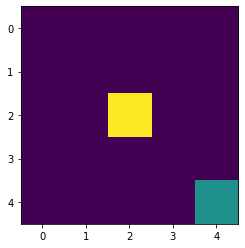

Action: Discrete(4)
Q_table: [[[ 4.1599878  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95093569 -0.04208223]
  [ 0.36       -0.32699215  3.68910086  0.09753448]
  [ 3.36154467  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95198335 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4399968  -0.5904    ]
  [ 0.         -0.2         1

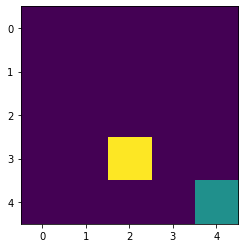

Action: Discrete(4)
Q_table: [[[ 4.1599878  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95093569 -0.04208223]
  [ 0.36       -0.32699215  3.68910086  0.09753448]
  [ 3.36154467  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95198617 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.4399968  -0.5904    ]
  [ 0.         -0.2         1

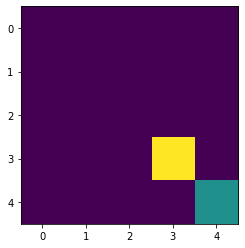

Action: Discrete(4)
Q_table: [[[ 4.1599878  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95093569 -0.04208223]
  [ 0.36       -0.32699215  3.68910086  0.09753448]
  [ 3.36154467  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95198617 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999737 -0.5904    ]
  [ 0.         -0.2         1

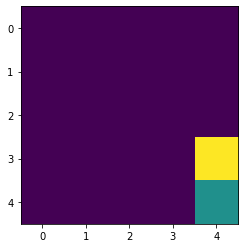

Action: Discrete(4)
Q_table: [[[ 4.1599878  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95093569 -0.04208223]
  [ 0.36       -0.32699215  3.68910086  0.09753448]
  [ 3.36154467  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95198617 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999737 -0.5904    ]
  [ 0.         -0.2         1

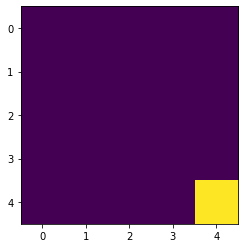

In [62]:
env = GridEnvironment() # note: we do not normalize
agent = QLearningAgent(env)
episodes = 100 # number of games we want the agent to play
delta_epsilon = agent.epsilon/episodes
decay_rate = 0.9

total_rewards = []
epsilons = [agent.epsilon]

# Training Process (Task 3) (20 points)
for i in range(episodes):
    obs = env.reset()
    done = False
    curr_state = obs.copy()
    rewards = 0

    print("Round", i)
    while not done:
        action = agent.step(curr_state)
        obs, reward, done, info = env.step(action)
        next_state = obs.copy()
        agent.update(curr_state, action, reward, next_state)
        curr_state = next_state.copy()
        rewards += reward
        
        print("State", curr_state)
        env.render()
        plt.show()
        
    #Exponential Decay Epsilon
    
    #As delta_epsilon is too low for exponential decay, so using a higher decay rate instead
    new_epsilon = agent.epsilon * decay_rate  #agent.epsilon * delta_epsilon
    agent.set_epsilon(new_epsilon)
    epsilons.append(new_epsilon)
    
    total_rewards.append(rewards)


#### Visualize $\epsilon$
Plot our value of $\epsilon$ over each episode

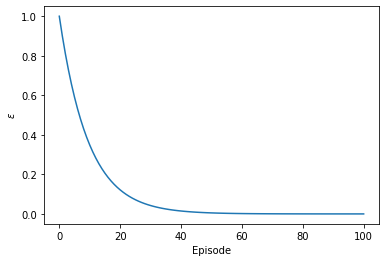

In [63]:
plt.xlabel('Episode')
plt.ylabel('$\epsilon$')
plt.plot(epsilons)

#### Visualize Rewards
Plot total_rewards per episode.  We apply a rolling mean of window $10$ to visualize easier.

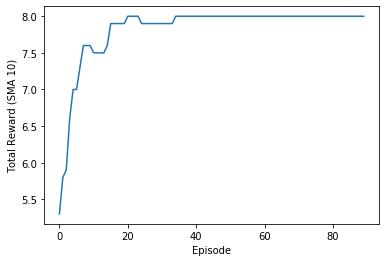

In [64]:
window = 10
plt.xlabel('Episode')
plt.ylabel('Total Reward (SMA 10)')
plt.plot([np.mean(total_rewards[tr:tr+window]) for tr in range(window, len(total_rewards))])

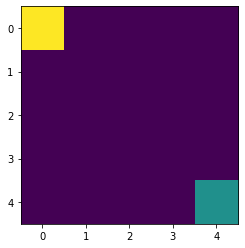

Action: Discrete(4)
Q_table: [[[ 4.1599878  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95093569 -0.04208223]
  [ 0.36       -0.32699215  3.68910086  0.09753448]
  [ 3.36154467  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95198617 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999737 -0.5904    ]
  [ 0.         -0.2         1

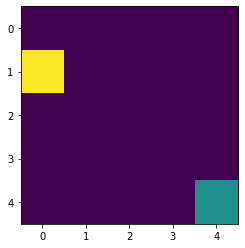

Action: Discrete(4)
Q_table: [[[ 4.1599878  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95093569 -0.04208223]
  [ 0.36       -0.32699215  3.68910086  0.09753448]
  [ 3.36154467  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95198617 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999737 -0.5904    ]
  [ 0.         -0.2         1

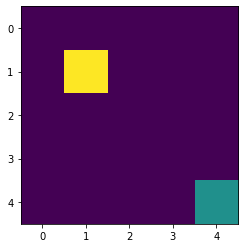

Action: Discrete(4)
Q_table: [[[ 4.1599878  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95093569 -0.04208223]
  [ 0.36       -0.32699215  3.68910086  0.09753448]
  [ 3.36154467  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95198617 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999737 -0.5904    ]
  [ 0.         -0.2         1

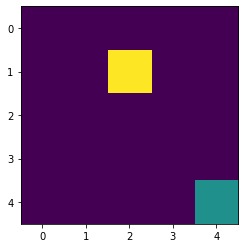

Action: Discrete(4)
Q_table: [[[ 4.1599878  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95093569 -0.04208223]
  [ 0.36       -0.32699215  3.68910086  0.09753448]
  [ 3.36154467  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95198617 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999737 -0.5904    ]
  [ 0.         -0.2         1

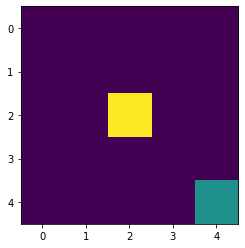

Action: Discrete(4)
Q_table: [[[ 4.1599878  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95093569 -0.04208223]
  [ 0.36       -0.32699215  3.68910086  0.09753448]
  [ 3.36154467  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95198617 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999737 -0.5904    ]
  [ 0.         -0.2         1

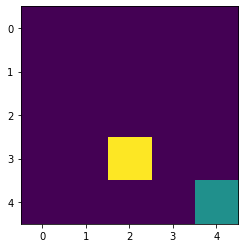

Action: Discrete(4)
Q_table: [[[ 4.1599878  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95093569 -0.04208223]
  [ 0.36       -0.32699215  3.68910086  0.09753448]
  [ 3.36154467  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95198617 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999737 -0.5904    ]
  [ 0.         -0.2         1

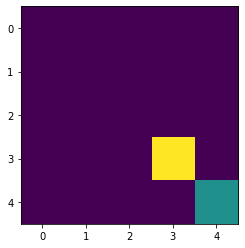

Action: Discrete(4)
Q_table: [[[ 4.1599878  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95093569 -0.04208223]
  [ 0.36       -0.32699215  3.68910086  0.09753448]
  [ 3.36154467  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95198617 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999737 -0.5904    ]
  [ 0.         -0.2         1

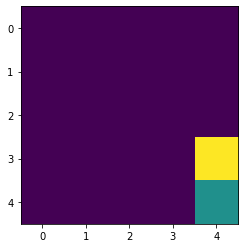

Action: Discrete(4)
Q_table: [[[ 4.1599878  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95093569 -0.04208223]
  [ 0.36       -0.32699215  3.68910086  0.09753448]
  [ 3.36154467  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95198617 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999737 -0.5904    ]
  [ 0.         -0.2         1

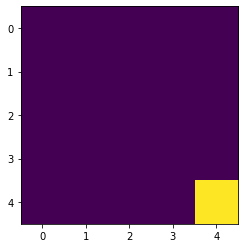

In [65]:
env = GridEnvironment()

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.ion()
plt.show()

while not done:
    action = agent.step(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()
    plt.pause(0.05)

In [66]:
print(agent.q_table)

[[[ 4.1599878  -0.0928892   0.72803584  0.17387276]
  [ 1.57902184  0.          0.2        -0.11660339]
  [ 0.         -0.36        0.         -0.112704  ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.232      -0.10097159  3.95093569 -0.04208223]
  [ 0.36       -0.32699215  3.68910086  0.09753448]
  [ 3.36154467  0.          0.          0.10746342]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.4653184  -0.168     ]
  [ 0.          0.          1.0047616  -0.2       ]
  [ 2.95198617 -0.168       0.         -0.16715008]
  [ 0.2576      0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.         -0.32288     0.         -0.2       ]
  [ 0.2        -0.09632     2.43999737 -0.5904    ]
  [ 0.         -0.2         1.79999966 -0.1203106 ]
  [ 0.